# Customer segmentation project

Your are a datascientist working as a consultant for [Olist](https://olist.com/), a sales solution for online marketplaces.


Olist wants you to develop a customer segmentation that its marketing teams can use on a routine basis for their communicaion campaigns. 


You have an initial meeting with Olist's Marketing Director, Sophia, to better understand the need of the project. Here somme notes you took : 
- Olist marketing teams need an actionable description of the segmentation that allows them to thoroughly grasp its underlying logic (Notebook format).
- The [database](https://www.kaggle.com/olistbr/brazilian-ecommerce) contains information such as order history, products purchased, customer satisfaction comments, and location.
- The quality of the data is somewhat poor. The idea is to create the best possible features for making optimum use of them.
- Customer segmentation means understand the different types of users. Unsupervised algorithm is probably the best to use. 
- The segmentation needs to be robust: adding a few new customers to the database and creating a new segmentation using the same model should not result in totally different conclusions.

TIPS : Feel free to take inspiration from the notebooks available on Kaggle. 

# 1. Join the different datasets into one dataset

TIPS : Use the function `merge` feel free to use the [doc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html). 

In [221]:
pip install natsort

In [222]:
pip install chart_studio

In [223]:
pip install kneed

In [224]:
import pandas as pd
import numpy as np
from functools import reduce
from datetime import datetime,timedelta
import time
import matplotlib.pyplot as plt 
import seaborn as sns
from natsort import index_natsorted,order_by_index
import re
from functools import reduce
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
import plotly.graph_objs as go
from plotly import tools
from plotly.graph_objs import Scatter,Figure,Layout
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,adjusted_rand_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

Import the datasets

In [225]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [226]:
closed_deals = pd.read_csv('/content/gdrive/MyDrive/Project_2/olist_closed_deals_dataset.csv')
customers = pd.read_csv('/content/gdrive/MyDrive/Project_2/olist_customers_dataset.csv')
geoloc = pd.read_csv('/content/gdrive/MyDrive/Project_2/olist_geolocation_dataset.csv')
mktg_qualified_leads = pd.read_csv('/content/gdrive/MyDrive/Project_2/olist_marketing_qualified_leads_dataset.csv')
order_items = pd.read_csv('/content/gdrive/MyDrive/Project_2/olist_order_items_dataset.csv')
order_payments = pd.read_csv('/content/gdrive/MyDrive/Project_2/olist_order_payments_dataset.csv')
order_review = pd.read_csv('/content/gdrive/MyDrive/Project_2/olist_order_reviews_dataset.csv')
orders = pd.read_csv('/content/gdrive/MyDrive/Project_2/olist_orders_dataset.csv')
products = pd.read_csv('/content/gdrive/MyDrive/Project_2/olist_products_dataset.csv')
sellers = pd.read_csv('/content/gdrive/MyDrive/Project_2/olist_sellers_dataset.csv')
product_category = pd.read_csv('/content/gdrive/MyDrive/Project_2/product_category_name_translation.csv')

The datasets are very heavy, therefore we only merge the ones that may interest us for the customer segmentation.

Most information needed are in the customer and order datasets

In [227]:
df1 = orders.merge(customers, on='customer_id', how='inner')
df1.head()

order_id  ... customer_state
0  e481f51cbdc54678b7cc49136f2d6af7  ...             SP
1  53cdb2fc8bc7dce0b6741e2150273451  ...             BA
2  47770eb9100c2d0c44946d9cf07ec65d  ...             GO
3  949d5b44dbf5de918fe9c16f97b45f8a  ...             RN
4  ad21c59c0840e6cb83a9ceb5573f8159  ...             SP

[5 rows x 12 columns]

Order reviews and payment may also be interesting

In [228]:
nb_installments = order_payments[['order_id','payment_installments']]

In [229]:
df2 = df1.merge(nb_installments, on='order_id', how='inner')

In [230]:
df2.head()

order_id  ... payment_installments
0  e481f51cbdc54678b7cc49136f2d6af7  ...                    1
1  e481f51cbdc54678b7cc49136f2d6af7  ...                    1
2  e481f51cbdc54678b7cc49136f2d6af7  ...                    1
3  53cdb2fc8bc7dce0b6741e2150273451  ...                    1
4  47770eb9100c2d0c44946d9cf07ec65d  ...                    3

[5 rows x 13 columns]

In [231]:
review_score = order_review[['order_id','review_score']]

In [232]:
df3 = df2.merge(review_score, on="order_id", how='inner')
df3.head()

order_id  ... review_score
0  e481f51cbdc54678b7cc49136f2d6af7  ...            4
1  e481f51cbdc54678b7cc49136f2d6af7  ...            4
2  e481f51cbdc54678b7cc49136f2d6af7  ...            4
3  53cdb2fc8bc7dce0b6741e2150273451  ...            4
4  47770eb9100c2d0c44946d9cf07ec65d  ...            5

[5 rows x 14 columns]

In [233]:
df3['review_score_mean'] = df3.groupby(by='customer_unique_id')['review_score'].transform('mean')
df3.head()

order_id  ... review_score_mean
0  e481f51cbdc54678b7cc49136f2d6af7  ...              4.25
1  e481f51cbdc54678b7cc49136f2d6af7  ...              4.25
2  e481f51cbdc54678b7cc49136f2d6af7  ...              4.25
3  53cdb2fc8bc7dce0b6741e2150273451  ...              4.00
4  47770eb9100c2d0c44946d9cf07ec65d  ...              5.00

[5 rows x 15 columns]

In [234]:
df3['installments_mean'] = df3.groupby(by='customer_unique_id')['payment_installments'].transform('mean')
df3.head()

order_id  ... installments_mean
0  e481f51cbdc54678b7cc49136f2d6af7  ...               1.0
1  e481f51cbdc54678b7cc49136f2d6af7  ...               1.0
2  e481f51cbdc54678b7cc49136f2d6af7  ...               1.0
3  53cdb2fc8bc7dce0b6741e2150273451  ...               1.0
4  47770eb9100c2d0c44946d9cf07ec65d  ...               3.0

[5 rows x 16 columns]

# 2. Understand, analyse and clean the dataset

TIPS : The quality of the dataset is not very good, don't hesitate to remove the variables with too many missing values. 

In [235]:
df3.shape #huge dataset 

(104485, 16)

In [236]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104485 entries, 0 to 104484
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       104485 non-null  object 
 1   customer_id                    104485 non-null  object 
 2   order_status                   104485 non-null  object 
 3   order_purchase_timestamp       104485 non-null  object 
 4   order_approved_at              104309 non-null  object 
 5   order_delivered_carrier_date   102587 non-null  object 
 6   order_delivered_customer_date  101331 non-null  object 
 7   order_estimated_delivery_date  104485 non-null  object 
 8   customer_unique_id             104485 non-null  object 
 9   customer_zip_code_prefix       104485 non-null  int64  
 10  customer_city                  104485 non-null  object 
 11  customer_state                 104485 non-null  object 
 12  payment_installments          

## Clean the data

Let's correct the orthograph of the city Sao Paulo:

In [237]:
customers['customer_city'] = list(map(lambda x : 'sao paulo' if x == 'são paulo' else x, customers['customer_city']))

Let's check the missing values:

In [238]:
def missing_values_table(df3):
        # Total missing values
        mis_val = df3.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df3.isnull().sum() / len(df3)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df3.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [239]:
missing_values = missing_values_table(df3)
missing_values.head(20)

Your selected dataframe has 16 columns.
There are 3 columns that have missing values.


Missing Values  % of Total Values
order_delivered_customer_date            3154                3.0
order_delivered_carrier_date             1898                1.8
order_approved_at                         176                0.2

There is no column with a high proportion of missing values, so we won't drop any.

## Geolocation analysis

## Analysis of the customers

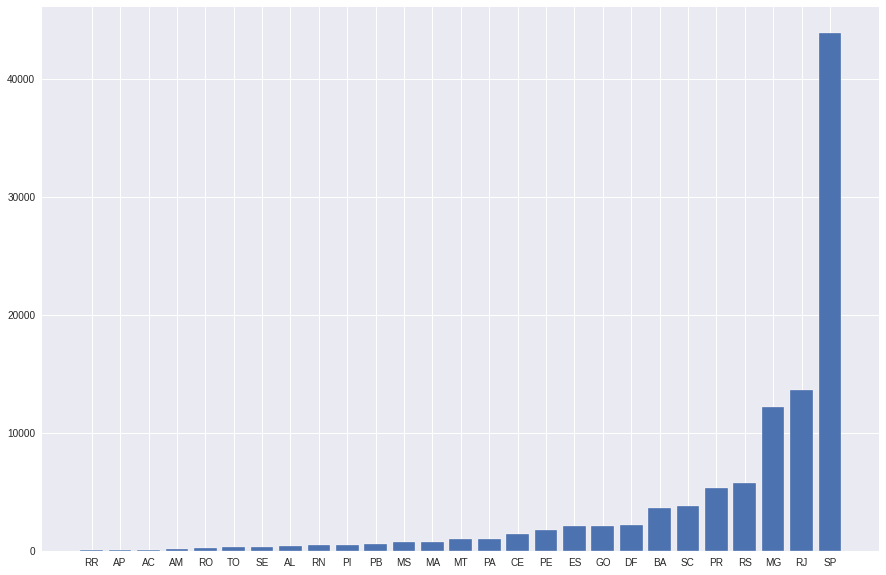

In [240]:
customer_by_state = df3[['customer_unique_id', 'customer_state']].groupby('customer_state').count().reset_index()
customer_by_state = customer_by_state.sort_values(by=['customer_unique_id'])

plt.style.use('seaborn')
plt.figure(figsize=(15,10))
plt.bar(customer_by_state['customer_state'], customer_by_state['customer_unique_id'])
plt.show()

We can see that most customers are from the state SP (This is Sao Paulo)

In [241]:
popular_cities_customer = pd.DataFrame(df3['customer_city'].value_counts())

In [242]:
import plotly.graph_objects as go

fig = go.Figure(go.Bar(y=popular_cities_customer.head(20).index, x=popular_cities_customer['customer_city'].head(20), 
                      orientation="h", marker=dict(color="green")))

fig.update_layout(title_text='Top Cities For Customers',xaxis_title="No. of Orders")
fig.update_xaxes(type="log")
fig.show()

## Analysis of the sellers

In [243]:
popular_cities_seller = pd.DataFrame(sellers['seller_city'].value_counts())#### Analysis of the customers

In [244]:
fig = go.Figure(go.Bar(y=popular_cities_seller.head(20).index, x=popular_cities_seller['seller_city'].head(20), 
                      orientation="h"))

fig.update_layout(title_text='Top Cities For Sellers',xaxis_title="No. of Orders")
fig.update_xaxes(type="log")
fig.show()

We can see that Olist has most of their customers and sellers are located in Sao Paulo, which is part of the state SP.

## Unique customers analysis

We can see the recurrence of customers. Did they buy once? twice? How many has bought once? twice? 

In [245]:
customers['customer_id'].describe()

count                                99441
unique                               99441
top       92e31a98ed57084b5b8d4a0457b12fa1
freq                                     1
Name: customer_id, dtype: object

In [246]:
customers['customer_unique_id'].describe()

count                                99441
unique                               96096
top       8d50f5eadf50201ccdcedfb9e2ac8455
freq                                    17
Name: customer_unique_id, dtype: object

In [247]:
products_by_unique = customers['customer_unique_id'].value_counts()
products_by_unique = products_by_unique.value_counts().sort_index().to_frame().reset_index()
products_by_unique = products_by_unique.rename(columns={'index':'Total number of products purchased','customer_unique_id':'Number of unique customers'})
products_by_unique['Proportion of unique customers'] = products_by_unique['Number of unique customers']/products_by_unique['Number of unique customers'].sum()*100
products_by_unique



Total number of products purchased  ...  Proportion of unique customers
0                                   1  ...                       96.881244
1                                   2  ...                        2.856518
2                                   3  ...                        0.211247
3                                   4  ...                        0.031219
4                                   5  ...                        0.008325
5                                   6  ...                        0.006244
6                                   7  ...                        0.003122
7                                   9  ...                        0.001041
8                                  17  ...                        0.001041

[9 rows x 3 columns]

In [248]:
print("There are", products_by_unique['Number of unique customers'].sum(), "unique customers. 96% of these customers purchased only one product on Olist and roughly 3% purchased two products within the period of 2016-2018.")


There are 96096 unique customers. 96% of these customers purchased only one product on Olist and roughly 3% purchased two products within the period of 2016-2018.


There are 96096 unique customers. 96% of these customers purchased only one product on Olist and roughly 3% purchased two products within the period of 2016-2018.

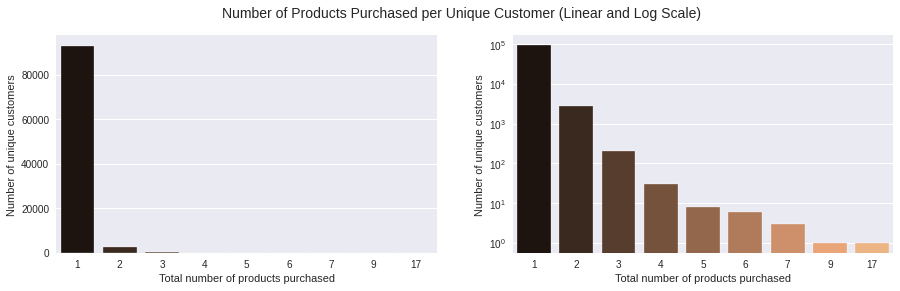

In [249]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

plt.suptitle("Number of Products Purchased per Unique Customer (Linear and Log Scale)", fontsize=14)

sns.barplot(data=products_by_unique, x='Total number of products purchased', y='Number of unique customers',ax=ax[0], palette='copper')
sns.barplot(data=products_by_unique, x='Total number of products purchased', y='Number of unique customers',ax=ax[1], palette='copper')
ax[1].set_yscale('log')

We can see that most customers buy only one product.

## Products analysis

In [250]:
products['product_category_name'].describe()

count               32341
unique                 73
top       cama_mesa_banho
freq                 3029
Name: product_category_name, dtype: object

73 unique products were ordered.

We can already see that the product category which is the most sold is cama_mesa_banho (bed_bath_table). Let's go deeper in our analysis. 

In [251]:
products.head()

product_id  ... product_width_cm
0  1e9e8ef04dbcff4541ed26657ea517e5  ...             14.0
1  3aa071139cb16b67ca9e5dea641aaa2f  ...             20.0
2  96bd76ec8810374ed1b65e291975717f  ...             15.0
3  cef67bcfe19066a932b7673e239eb23d  ...             26.0
4  9dc1a7de274444849c219cff195d0b71  ...             13.0

[5 rows x 9 columns]

In [252]:
customers.head()

customer_id  ... customer_state
0  06b8999e2fba1a1fbc88172c00ba8bc7  ...             SP
1  18955e83d337fd6b2def6b18a428ac77  ...             SP
2  4e7b3e00288586ebd08712fdd0374a03  ...             SP
3  b2b6027bc5c5109e529d4dc6358b12c3  ...             SP
4  4f2d8ab171c80ec8364f7c12e35b23ad  ...             SP

[5 rows x 5 columns]

In [253]:
#Most popular categories
df4 = products.merge(order_items, on="product_id", how='inner')
popular_categories = pd.DataFrame(df4.groupby(['product_category_name'])['order_id'].count().sort_values(ascending = False))


In [254]:
popular_categories.head()

order_id
product_category_name           
cama_mesa_banho            11115
beleza_saude                9670
esporte_lazer               8641
moveis_decoracao            8334
informatica_acessorios      7827

In [255]:
fig = go.Figure(go.Bar(
    x=popular_categories.head(10).index,y=popular_categories['order_id'].head(10),
    marker={'color': popular_categories['order_id'], 
    'colorscale': 'Viridis'},  
    text=popular_categories['order_id'],
    textposition = "outside",
))
fig.update_layout(title_text='Most popular categories',xaxis_title="Category Name",yaxis_title="No. of orders")
fig.show()

Here, we can see that the second most popular category is beleza_saude, which means beauty_health.

In [256]:
bottom_products = products['product_category_name'].value_counts().nsmallest(10)
bottom_products

cds_dvds_musicais                                 1
seguros_e_servicos                                2
pc_gamer                                          3
casa_conforto_2                                   5
fashion_roupa_infanto_juvenil                     5
tablets_impressao_imagem                          9
portateis_cozinha_e_preparadores_de_alimentos    10
moveis_colchao_e_estofado                        10
la_cuisine                                       10
fraldas_higiene                                  12
Name: product_category_name, dtype: int64

Review scores

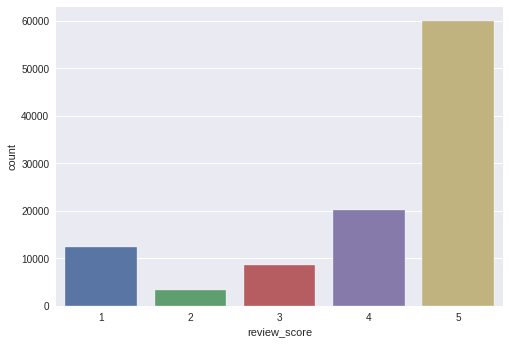

In [257]:
sns.countplot(x=df3['review_score'])

Overall, people well rank Olist's products (majority of 5's).

## Orders analysis

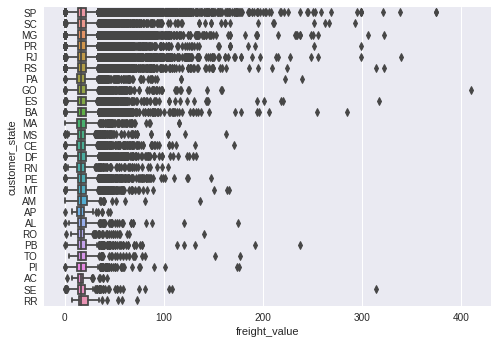

In [258]:
sns.boxplot(x=order_items['freight_value'], y=customers['customer_state'])

While the mean freight values are equivalent in all states, there are many outliers towards upper values in the Sao Paulo (SP) state. The state Goiás (GO) has the hisghest outlier freight value.

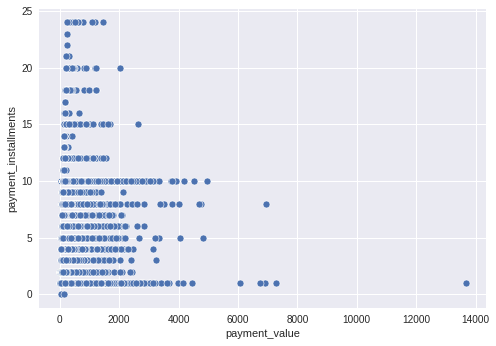

In [259]:
sns.scatterplot(x=order_payments['payment_value'], y=order_payments['payment_installments'])

There are more installements made for purchases of low values.

## Analyzing recency and frequency segments

In [260]:
order_payments.shape
x=pd.DataFrame(order_payments.groupby('order_id')['payment_value'].sum())
x.reset_index(0,inplace=True)

In [261]:
df_3=df1.merge(x,on='order_id',how='outer')
df_3.shape

(99441, 13)

In [262]:
df_3.dropna(subset=['order_purchase_timestamp'],inplace=True)
df_3.isna().sum()
df_3['order_purchase_timestamp']=pd.to_datetime(df_3['order_purchase_timestamp'],format="%Y-%m-%d %H:%M:%S")
df_3['new_date']=df_3['order_purchase_timestamp'].dt.year.astype(str)+'-'+df_3['order_purchase_timestamp'].dt.month.astype(str)+'-'+df_3['order_purchase_timestamp'].dt.day.astype(str)

df_3['new_date']=pd.to_datetime(df_3['new_date'],format="%Y-%m-%d")
df_3['new_date']

0       2017-10-02
1       2018-07-24
2       2018-08-08
3       2017-11-18
4       2018-02-13
           ...    
99436   2017-03-09
99437   2018-02-06
99438   2017-08-27
99439   2018-01-08
99440   2018-03-08
Name: new_date, Length: 99441, dtype: datetime64[ns]

In [263]:
df4=df_3.groupby('customer_unique_id').agg({'order_id':'count','new_date':[np.max,np.min],'payment_value':'sum'})


### Frequency segments regarding orders

In [264]:
def frequency_segment(x):
    if (x>=0) & (x<2):
        return '0-2 orders'
    if (x>=2) & (x<5):
        return '2-5 orders'
    if (x>5):
        return '>5 orders'
    

In [265]:
df4['frequency_segment']=df4[('order_id', 'count')].apply(frequency_segment)
df4

order_id  ... frequency_segment
                                    count  ...                  
customer_unique_id                         ...                  
0000366f3b9a7992bf8c76cfdf3221e2        1  ...        0-2 orders
0000b849f77a49e4a4ce2b2a4ca5be3f        1  ...        0-2 orders
0000f46a3911fa3c0805444483337064        1  ...        0-2 orders
0000f6ccb0745a6a4b88665a16c9f078        1  ...        0-2 orders
0004aac84e0df4da2b147fca70cf8255        1  ...        0-2 orders
...                                   ...  ...               ...
fffcf5a5ff07b0908bd4e2dbc735a684        1  ...        0-2 orders
fffea47cd6d3cc0a88bd621562a9d061        1  ...        0-2 orders
ffff371b4d645b6ecea244b27531430a        1  ...        0-2 orders
ffff5962728ec6157033ef9805bacc48        1  ...        0-2 orders
ffffd2657e2aad2907e67c3e9daecbeb        1  ...        0-2 orders

[96096 rows x 5 columns]

In [266]:
df4['frequency_segment'].describe()

count          96088
unique             3
top       0-2 orders
freq           93099
Name: frequency_segment, dtype: object

Most customers make 1 or 2 orders on Olist. (di

### Recency segments regarding orders

In [267]:
last_date=(df_3['order_purchase_timestamp'].max())
last_date=datetime(2018,9,11)
last_date

datetime.datetime(2018, 9, 11, 0, 0)

In [268]:
df4['recency']=(last_date-df4[('new_date','amax')]).dt.days

In [269]:
def recency_segment(x):
    if (x>=0) & (x<30):
        return '0-30 days'
    if (x>=30) & (x<90):
        return '30-90 days'
    if (x>=90) & (x<150):
        return '90-150 days'
    if (x>=150) & (x<250):
        return '150-250 days'
    if (x>=250) & (x<400):
        return '250-400 days'
    if (x>=400):
        return '>400 days'

In [270]:
df4['recency_segment']=df4['recency'].apply(recency_segment)
df4['recency_segment'].describe()

count            96086
unique               6
top       250-400 days
freq             25182
Name: recency_segment, dtype: object

Most customers made an order during the past 250 to 400 days before the last date. This makes sense with what we found in the frequency segment analysis : most customers made one order and don't come back. 

## Analyzing customer cohorts based on their first purchase date

In [271]:
df4['cohort']=df4[('new_date','amin')].dt.year.astype(str)+'-'+df4[('new_date','amin')].dt.month.astype(str)

In [272]:
df4.reset_index('customer_unique_id',inplace=True)
rename_list=['customer_unique_id','order count per customer','Max_date','Min_date','Total payment amounts','frequency_segment','recency','recency_segment','cohort']
df4.columns=rename_list

### Grouping cohort,recency_segment,frequency_segment and calculating count of customers and total payments per group

In [273]:
data2=pd.DataFrame(df4.groupby(['cohort','frequency_segment','recency_segment'])['Total payment amounts'].sum())


In [274]:
data3=pd.DataFrame(df4.groupby(['cohort','frequency_segment','recency_segment'])['customer_unique_id'].apply(lambda x:len(x.unique())))

In [275]:
data2.reset_index(['cohort','recency_segment','frequency_segment'],inplace=True)
data2.dtypes

cohort                    object
frequency_segment         object
recency_segment           object
Total payment amounts    float64
dtype: object

In [276]:
data3.reset_index(['cohort','recency_segment','frequency_segment'],inplace=True)
data3.dtypes

cohort                object
frequency_segment     object
recency_segment       object
customer_unique_id     int64
dtype: object

### Customer Lifecycle Grid


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:64: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:64: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



<Figure size 1440x1440 with 0 Axes>

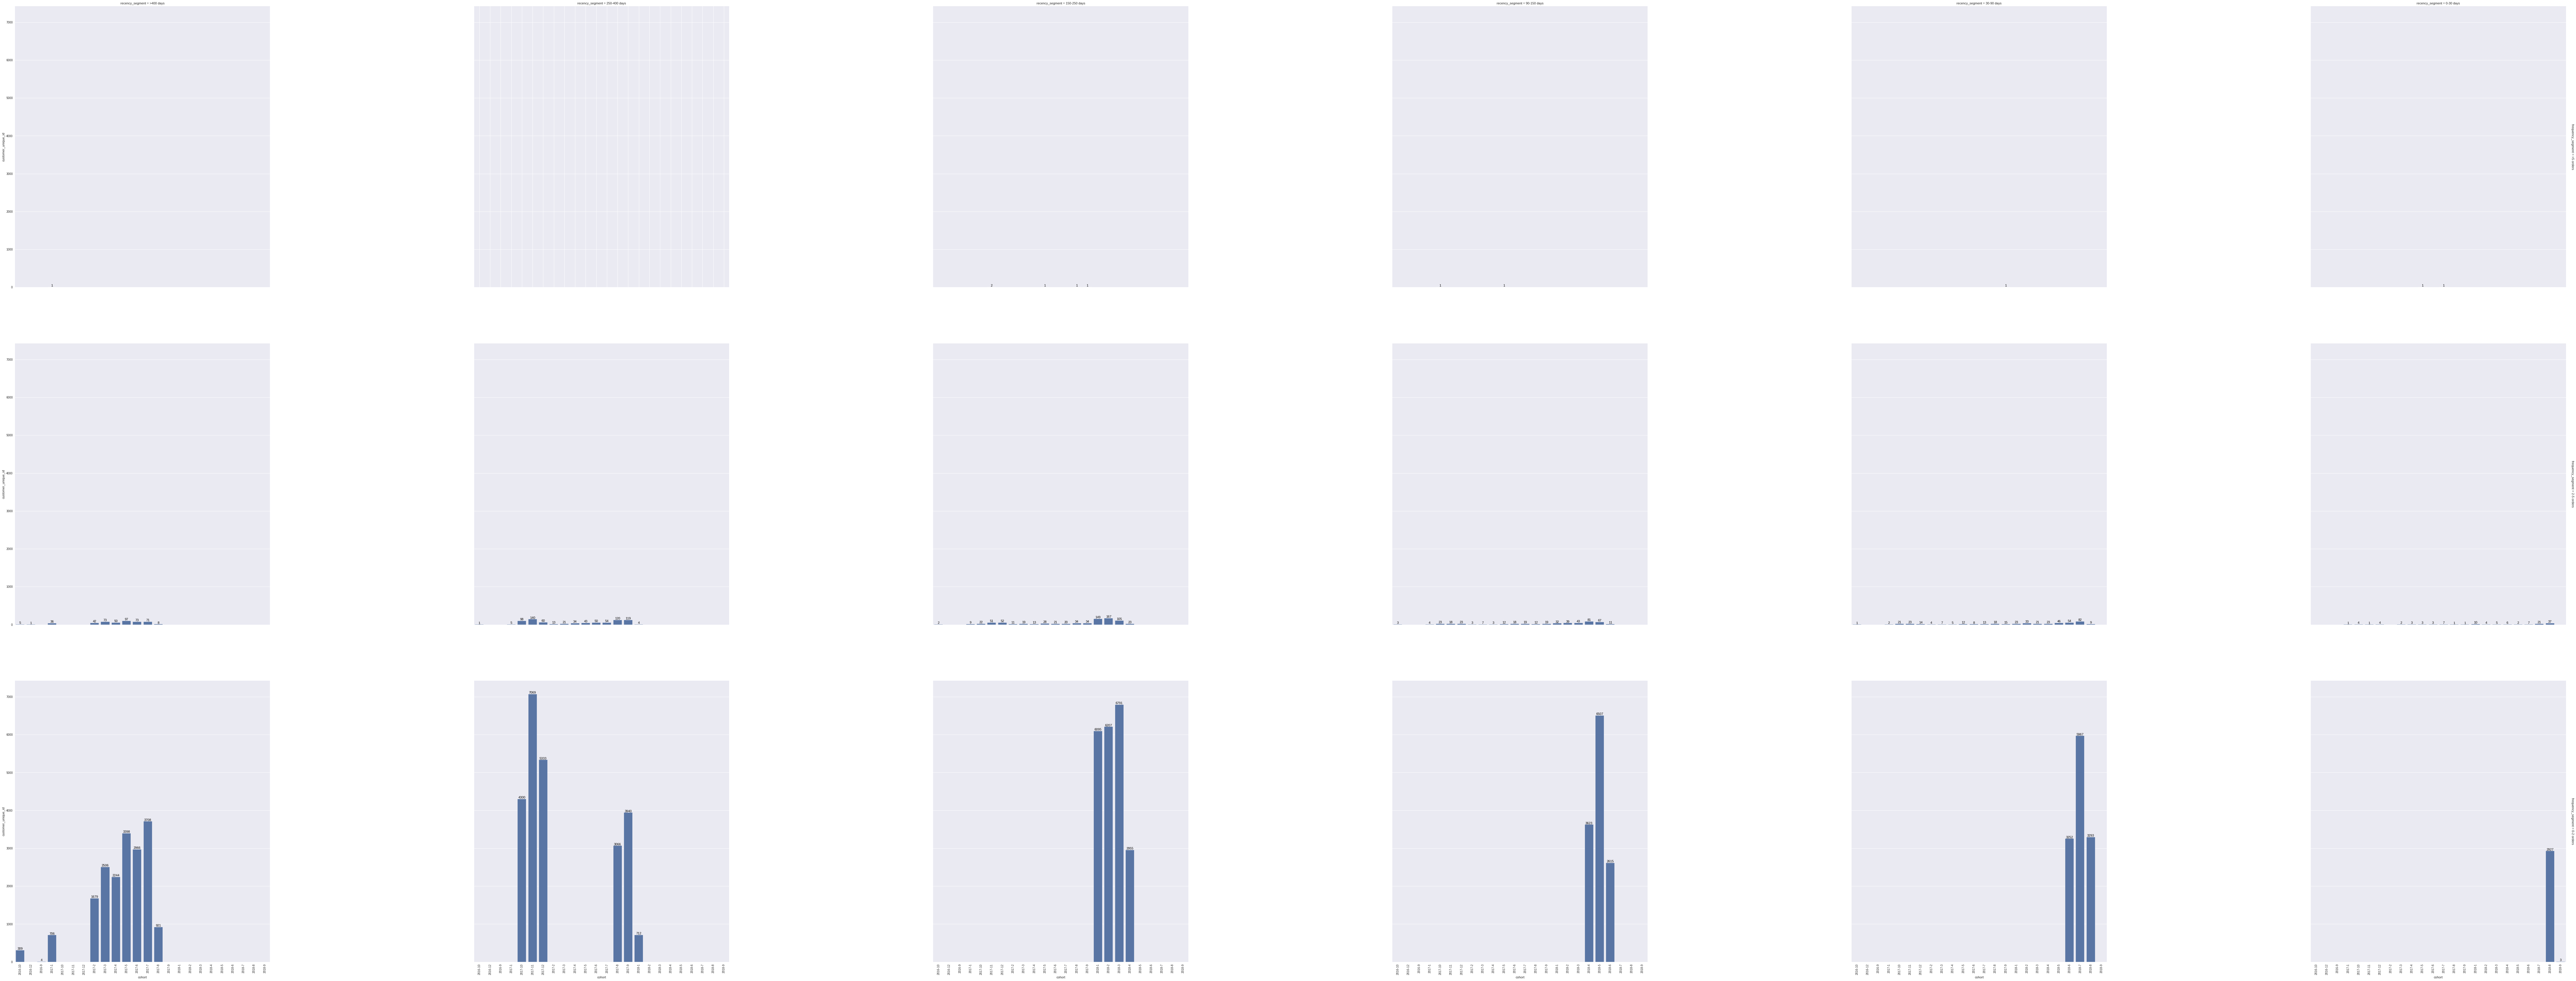

In [277]:
fig=plt.figure(figsize=(20,20))
graph=sns.FacetGrid(data3,col='recency_segment',row='frequency_segment',sharex=True,sharey=True,
                    margin_titles=True,aspect=1.3,row_order=['>5 orders','2-5 orders','0-2 orders']
                   ,col_order=['>400 days','250-400 days','150-250 days','90-150 days','30-90 days','0-30 days'],height=20,
                   gridspec_kws={"wspace":0.8})

fig.tight_layout()
order=data3['cohort'].unique()
graph.map(sns.barplot,'cohort','customer_unique_id',order=order)
for ax in graph.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                 textcoords='offset points')

We can see that most cohorts don't come back to Olist website ofter their first order. The life cycle grids thus confirms our previous analysis.

## Heatmap of the retention of customers 

In [278]:
df_3['year_month']=df_3['new_date'].dt.year.astype(str)+'-'+df_3['new_date'].dt.month.astype(str)
df_3.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [279]:
merged_data=df_3.merge(df4,on='customer_unique_id',how='left')
merged_data.order_status.unique()


array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [280]:
data_change=merged_data[['cohort','year_month','customer_unique_id']]
x=data_change.sort_values(by='cohort')


In [281]:
df5=pd.DataFrame(x.groupby(['cohort','year_month'])['customer_unique_id'].nunique()).reset_index(['cohort','year_month'])


In [282]:
df5=df5.reindex(index=order_by_index(df5.index,index_natsorted(df5['cohort'],reverse=False)))
df5['cohort'].unique()
df5.columns

Index(['cohort', 'year_month', 'customer_unique_id'], dtype='object')

In [283]:
wide_data=df5.pivot(index='cohort',columns='year_month',values='customer_unique_id')
wide_data=wide_data.replace(np.nan,0)

In [284]:
new_data1=pd.concat([pd.DataFrame(wide_data.iloc[2,:]).transpose(),wide_data.iloc[0:2,:],pd.DataFrame(wide_data.iloc[3,:]).transpose(),
wide_data.iloc[7:15,:],wide_data.iloc[4:7,:],pd.DataFrame(wide_data.iloc[15,:]).transpose(),wide_data.iloc[17:,:],pd.DataFrame(wide_data.iloc[16,:]).transpose()],axis=0)

new_data2=pd.concat([new_data1.iloc[:,2],new_data1.iloc[:,0:2],new_data1.iloc[:,3],
                   new_data1.iloc[:,7:15],new_data1.iloc[:,4:7],wide_data.iloc[:,15],new_data1.iloc[:,17:],wide_data.iloc[:,16]],axis=1)

In [285]:
new_data2.iloc[:,:]=new_data2.apply(lambda x:((x/x.max())).round(4),axis=1)

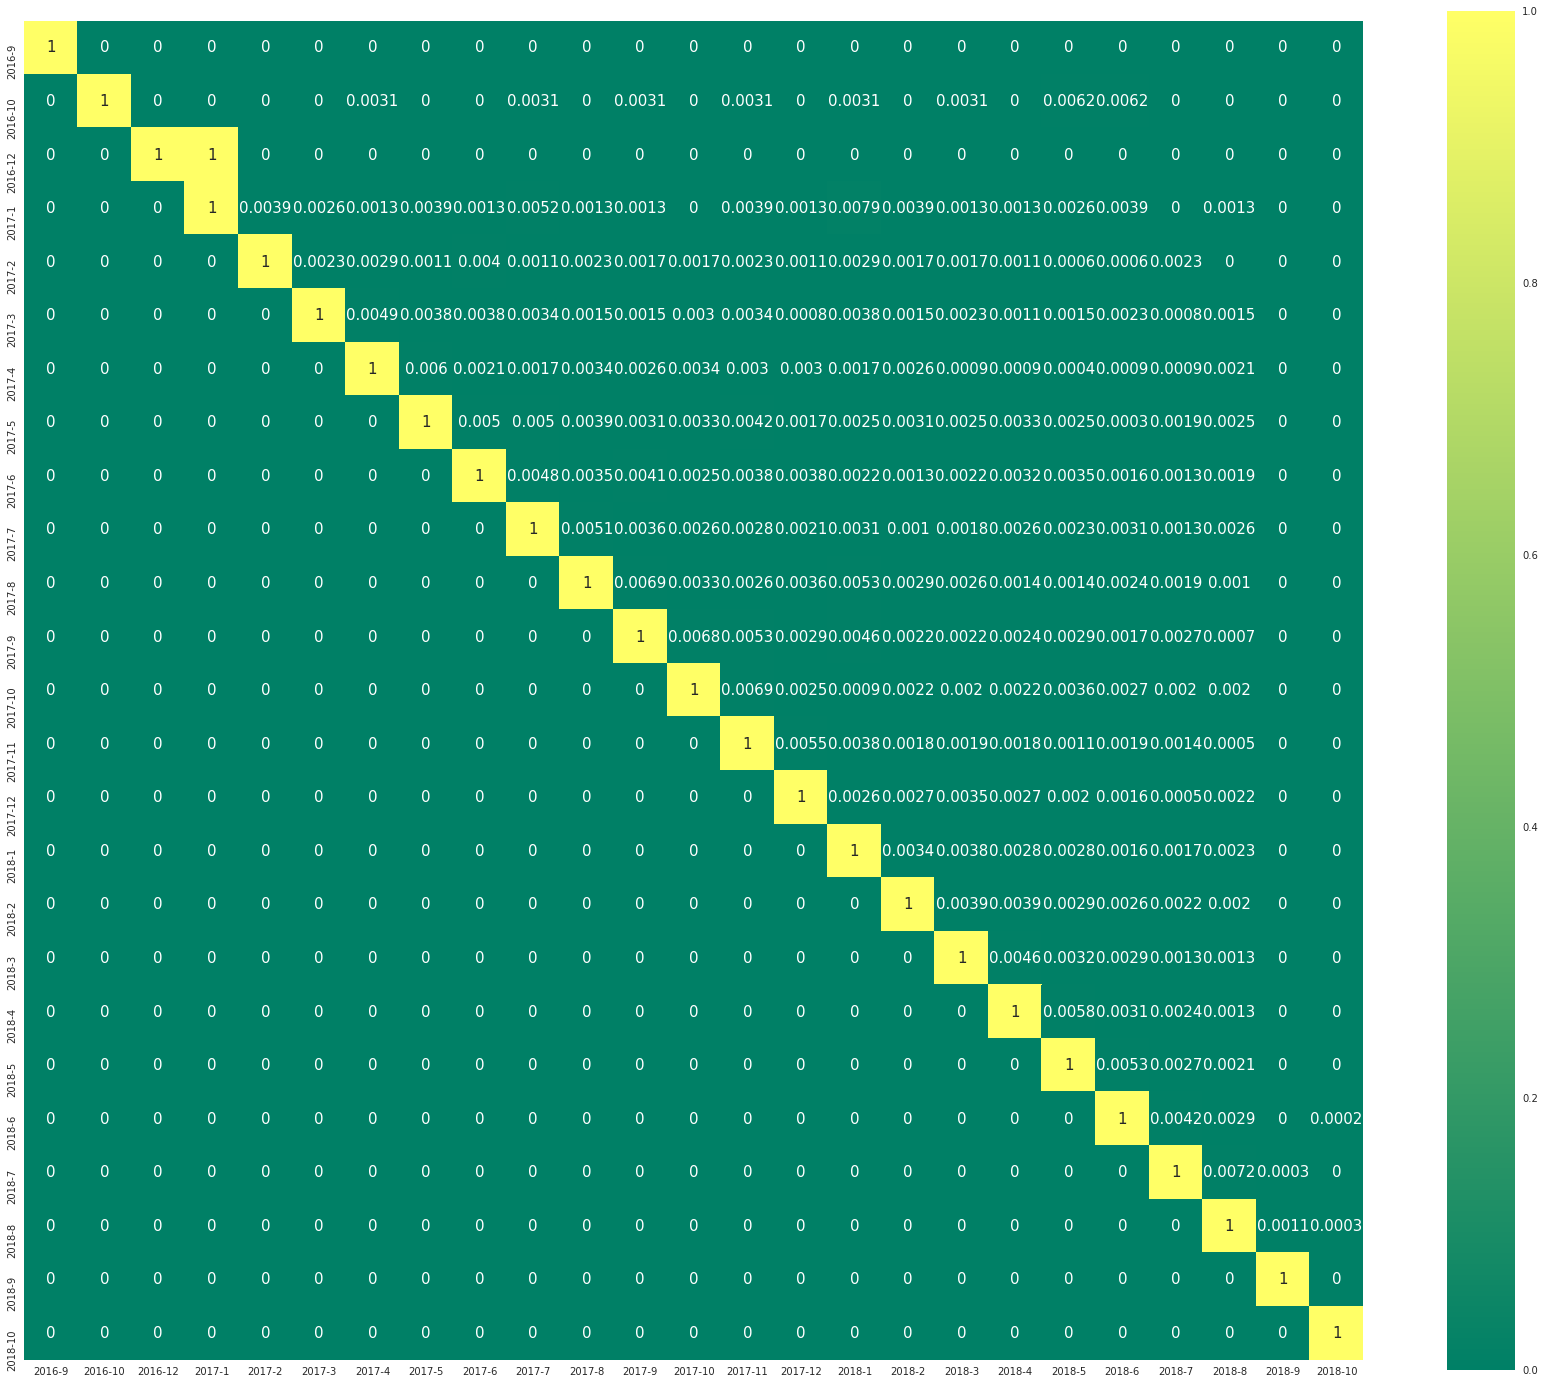

In [286]:
plt.figure(figsize=(30,25))
ax=plt.subplot(111)

sns.heatmap(new_data2,annot=True,cmap="summer",annot_kws={'size': 15},square=True,fmt='g')
sns.set(font_scale=2)

The retention rate is mostly low for all the cohorts. Especially, the 2016 cohorts of september and december never came back.

# Bar graph showing top 10 products in terms of orders made

In [287]:
order_items.drop_duplicates(subset='order_id',inplace=True,keep='first')

In [288]:
products.isna().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [289]:
combined_product_data=order_items.merge(products,on='product_id',how='left')
combined_product_data.isna().sum()
combined_product_data['product_category_name']=combined_product_data['product_category_name'].apply(lambda x: 'not_available' if pd.isnull(x) else x )

<Figure size 2160x1440 with 0 Axes>

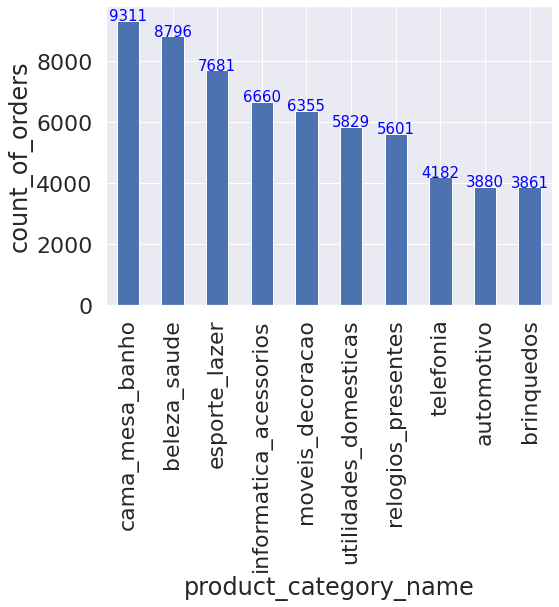

In [290]:
combined_product_data_customer=combined_product_data.merge(orders,on='order_id',how='right')
combined_product_data_customer['product_category_name']=combined_product_data_customer['product_category_name'].apply(lambda x: 'not_available' if pd.isnull(x) else x )
combined_product_data_customer
combined_product_data_customer['order_purchase_timestamp']=pd.to_datetime(combined_product_data_customer['order_purchase_timestamp'],format="%Y-%m-%d %H:%M:%S")
combined_product_data_customer['new_date']=combined_product_data_customer['order_purchase_timestamp'].dt.year.astype(str)+'-'+combined_product_data_customer['order_purchase_timestamp'].dt.month.astype(str)+'-'+combined_product_data_customer['order_purchase_timestamp'].dt.day.astype(str)

combined_product_data_customer['new_date']=pd.to_datetime(combined_product_data_customer['new_date'],format="%Y-%m-%d")
combined_product_data_customer['new_date']
combined_product_data_customer['year_month']=combined_product_data_customer['new_date'].dt.year.astype(str)+'-'+combined_product_data_customer['new_date'].dt.month.astype(str)


grouping_products_by_orders=pd.DataFrame(combined_product_data_customer.groupby('product_category_name')['order_id'].count())
grouping_products_by_orders.reset_index(inplace=True)
grouping_products_by_orders.columns=['product_category_name','count_of_orders']
grouping_products_by_orders=grouping_products_by_orders.sort_values(by='count_of_orders',ascending=False)
a=grouping_products_by_orders.head(10)
plt.figure(figsize=(30,20))
chart=a.plot(kind='bar',x='product_category_name',y='count_of_orders',legend=False)
plt.ylabel('count_of_orders')

for p in chart.patches:
    chart.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
    ha='center', va='center', fontsize=15, color='blue', xytext=(0, 5),
    textcoords='offset points')

# Bar graphs showing the sales of the top ten products during all the time 
# periods from start to end. The x axis contains combination of each month and    year

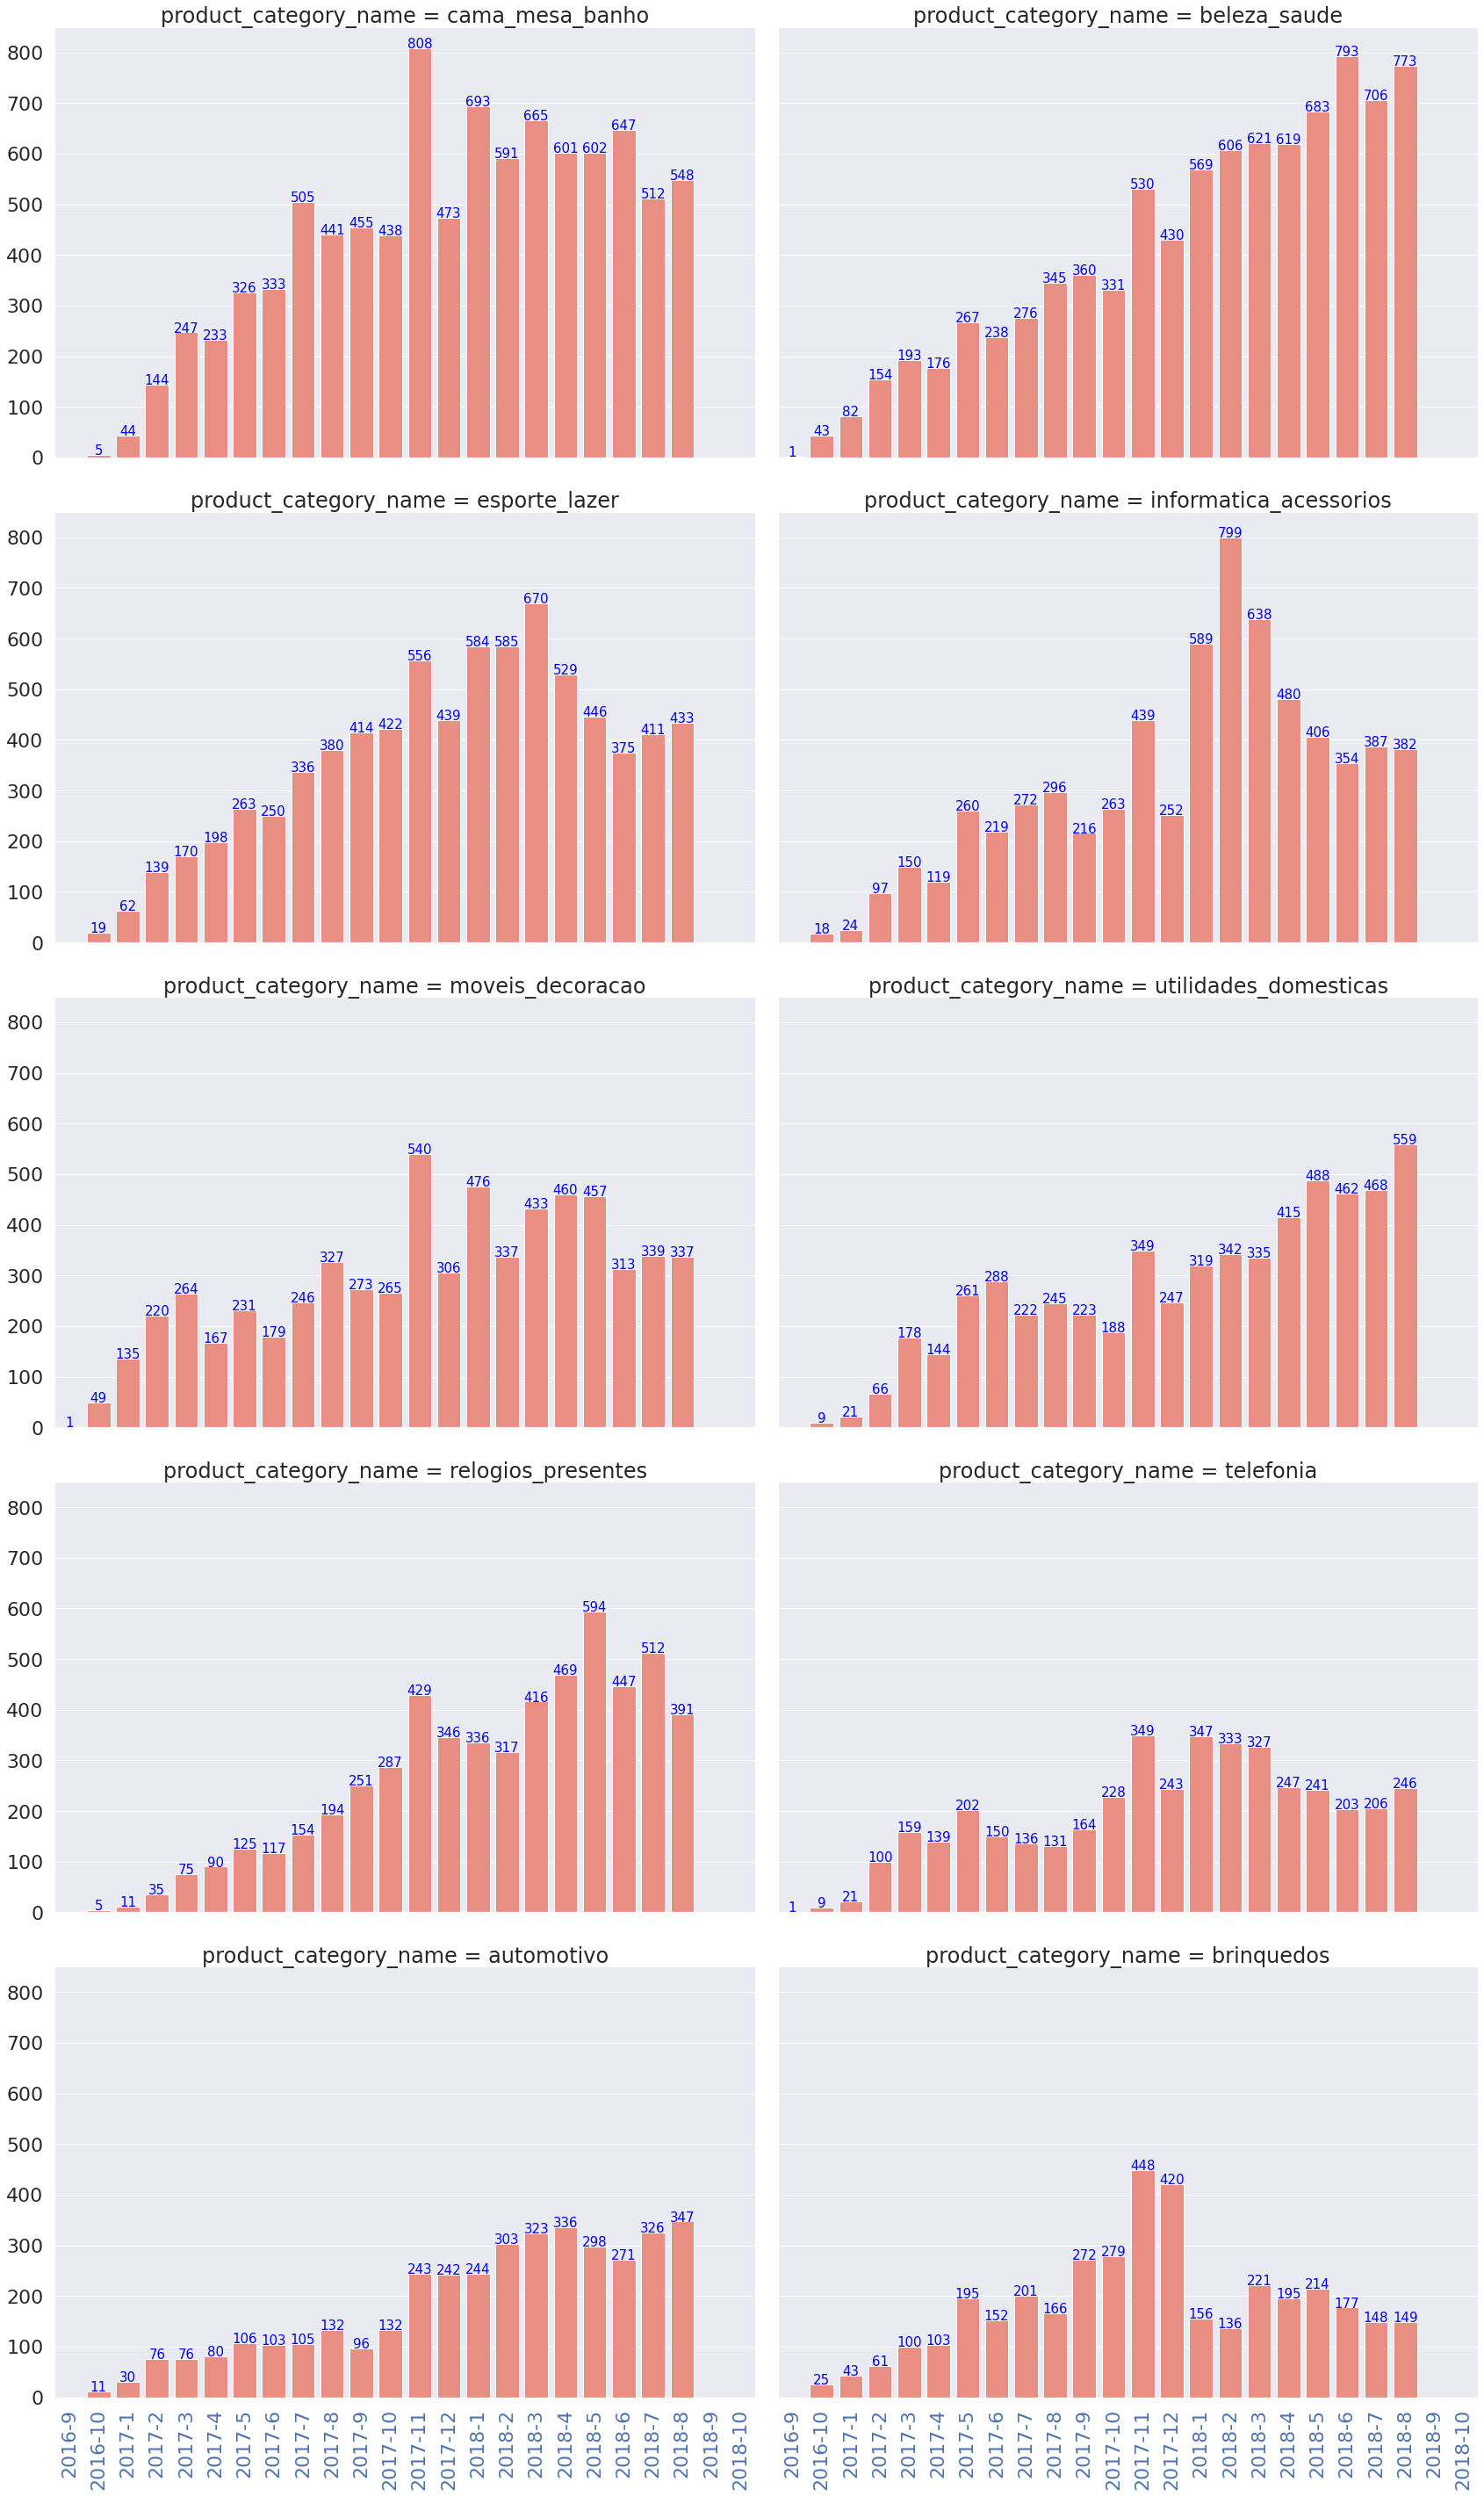

In [291]:
grouping_products_by_orders_month=pd.DataFrame(combined_product_data_customer.groupby(['product_category_name','year_month'])['order_id'].count())
grouping_products_by_orders_month.reset_index(inplace=True)
b=[]
for x in a['product_category_name'].unique():
    q=grouping_products_by_orders_month[grouping_products_by_orders_month['product_category_name']==x]
    b.append(q)
data=pd.concat(b)
order=['2016-9','2016-10', '2017-1', '2017-2',
       '2017-3', '2017-4', '2017-5', '2017-6', '2017-7', '2017-8',
       '2017-9', '2017-10', '2017-11', '2017-12','2018-1', '2018-2', '2018-3', '2018-4', '2018-5',
       '2018-6', '2018-7', '2018-8','2018-9','2018-10']

graph=sns.FacetGrid(data,col='product_category_name',sharey=True,col_wrap=2,height=8,aspect=1.5)
graph.map(sns.barplot,'year_month','order_id',color='salmon',order=order)
graph.map(plt.xticks,rotation=90)
for ax in graph.axes:
    for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=15, color='blue', xytext=(0, 5),
                 textcoords='offset points')
plt.show()

# Bar Graphs showing top ten products in terms of number of successful
# deliveries, number of cancelled orders and numbers of unavailable products

In [292]:
a=pd.get_dummies(combined_product_data_customer['order_status'])
a
combined_product_data_customer=pd.concat([combined_product_data_customer,a],axis=1)
product_status_dataframe=combined_product_data_customer.groupby('product_category_name').agg({'delivered':'sum','canceled':'sum','unavailable':'sum'})
product_status_dataframe

delivered  canceled  unavailable
product_category_name                                      
agro_industria_e_comercio      177.0         0          0.0
alimentos                      435.0         1          0.0
alimentos_bebidas              218.0         2          0.0
artes                          191.0         1          0.0
artes_e_artesanato              22.0         0          0.0
...                              ...       ...          ...
sinalizacao_e_seguranca        138.0         0          0.0
tablets_impressao_imagem        77.0         0          0.0
telefonia                     4076.0        16          0.0
telefonia_fixa                 212.0         3          0.0
utilidades_domesticas         5688.0        37          0.0

[74 rows x 3 columns]

In [293]:
product_status_dataframe.reset_index(inplace=True)
product_status_dataframe

product_category_name  delivered  canceled  unavailable
0   agro_industria_e_comercio      177.0         0          0.0
1                   alimentos      435.0         1          0.0
2           alimentos_bebidas      218.0         2          0.0
3                       artes      191.0         1          0.0
4          artes_e_artesanato       22.0         0          0.0
..                        ...        ...       ...          ...
69    sinalizacao_e_seguranca      138.0         0          0.0
70   tablets_impressao_imagem       77.0         0          0.0
71                  telefonia     4076.0        16          0.0
72             telefonia_fixa      212.0         3          0.0
73      utilidades_domesticas     5688.0        37          0.0

[74 rows x 4 columns]

In [294]:
product_status_dataframe_delivered_order=product_status_dataframe[['product_category_name','delivered']].sort_values(by='delivered',ascending=False).head(10)
product_status_dataframe_canceled_order=product_status_dataframe[['product_category_name','canceled']].sort_values(by='canceled',ascending=False).head(10)
product_status_dataframe_unavailable_order=product_status_dataframe[['product_category_name','unavailable']].sort_values(by='unavailable',ascending=False).head(10)
   

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

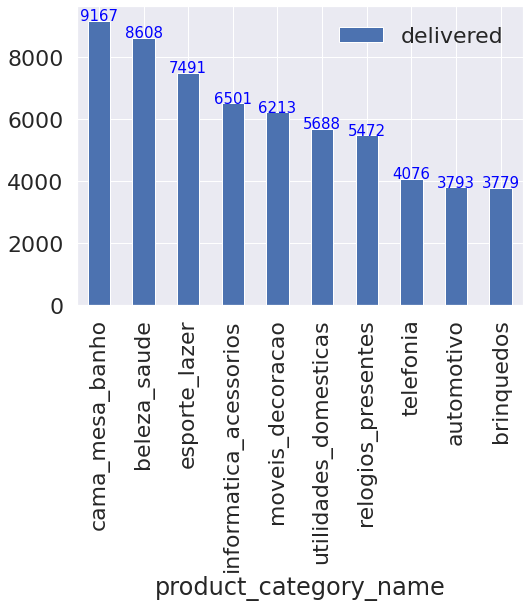

In [295]:
chart=product_status_dataframe_delivered_order.plot(x='product_category_name',y='delivered',kind='bar')
for p in chart.patches:
        chart.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=15, color='blue', xytext=(0, 5),
            textcoords='offset points')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

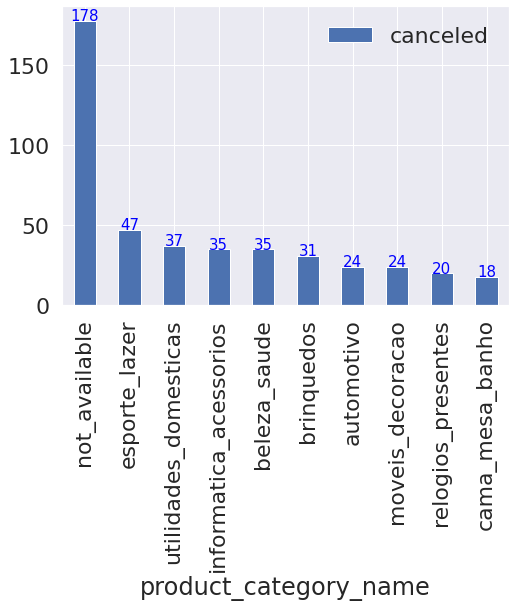

In [296]:
chart=product_status_dataframe_canceled_order.plot(x='product_category_name',y='canceled',kind='bar')
for p in chart.patches:
        chart.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=15, color='blue', xytext=(0, 5),
            textcoords='offset points')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

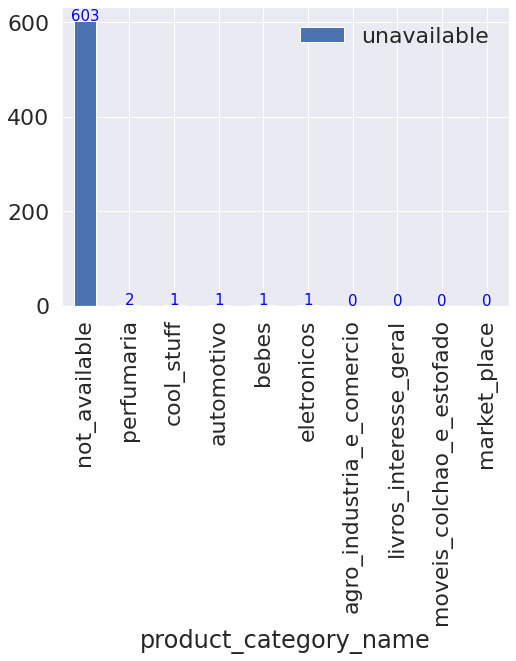

In [297]:
chart=product_status_dataframe_unavailable_order.plot(x='product_category_name',y='unavailable',kind='bar')
for p in chart.patches:
        chart.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=15, color='blue', xytext=(0, 5),
            textcoords='offset points')
plt.xticks(rotation=90)

# Bar graphs showing the count of deliveries of all top 10 delivered products during each combination of year and month

In [298]:
combined_product_data_customer_top_ten_products=combined_product_data_customer[combined_product_data_customer['product_category_name'].isin(product_status_dataframe_delivered_order['product_category_name'])]
combined_product_data_customer_top_ten_products

order_id  order_item_id  ... shipped unavailable
0      e481f51cbdc54678b7cc49136f2d6af7            1.0  ...       0           0
2      47770eb9100c2d0c44946d9cf07ec65d            1.0  ...       0           0
5      a4591c265e18cb1dcee52889e2d8acc3            1.0  ...       0           0
7      6514b8ad8028c9f2cc2374ded245783f            1.0  ...       0           0
8      76c6e866289321a7c93b82b54852dc33            1.0  ...       0           0
...                                 ...            ...  ...     ...         ...
99434  aa04ef5214580b06b10e2a378300db44            1.0  ...       0           0
99435  880675dff2150932f1601e1c07eadeeb            1.0  ...       0           0
99436  9c5dedf39a927c1b2549525ed64a053c            1.0  ...       0           0
99439  11c177c8e97725db2631073c19f07b62            1.0  ...       0           0
99440  66dea50a8b16d9b4dee7af250b4be1a5            1.0  ...       0           0

[62156 rows x 32 columns]

In [299]:
lists=[]
for i in combined_product_data_customer_top_ten_products['product_category_name'].unique():
    
    top_ten_products_group_by_month=combined_product_data_customer_top_ten_products[combined_product_data_customer_top_ten_products['product_category_name']==i]
    top_ten_products_group_by_month=pd.DataFrame( top_ten_products_group_by_month.groupby(['product_category_name','year_month'])['delivered'].sum())
    top_ten_products_group_by_month.reset_index(inplace=True)
    lists.append(top_ten_products_group_by_month)
lists

data=pd.concat(lists)
data

product_category_name year_month  delivered
0   utilidades_domesticas    2016-10        9.0
1   utilidades_domesticas     2017-1       21.0
2   utilidades_domesticas    2017-10      185.0
3   utilidades_domesticas    2017-11      341.0
4   utilidades_domesticas    2017-12      241.0
..                    ...        ...        ...
16          esporte_lazer     2018-4      517.0
17          esporte_lazer     2018-5      443.0
18          esporte_lazer     2018-6      369.0
19          esporte_lazer     2018-7      403.0
20          esporte_lazer     2018-8      429.0

[213 rows x 3 columns]

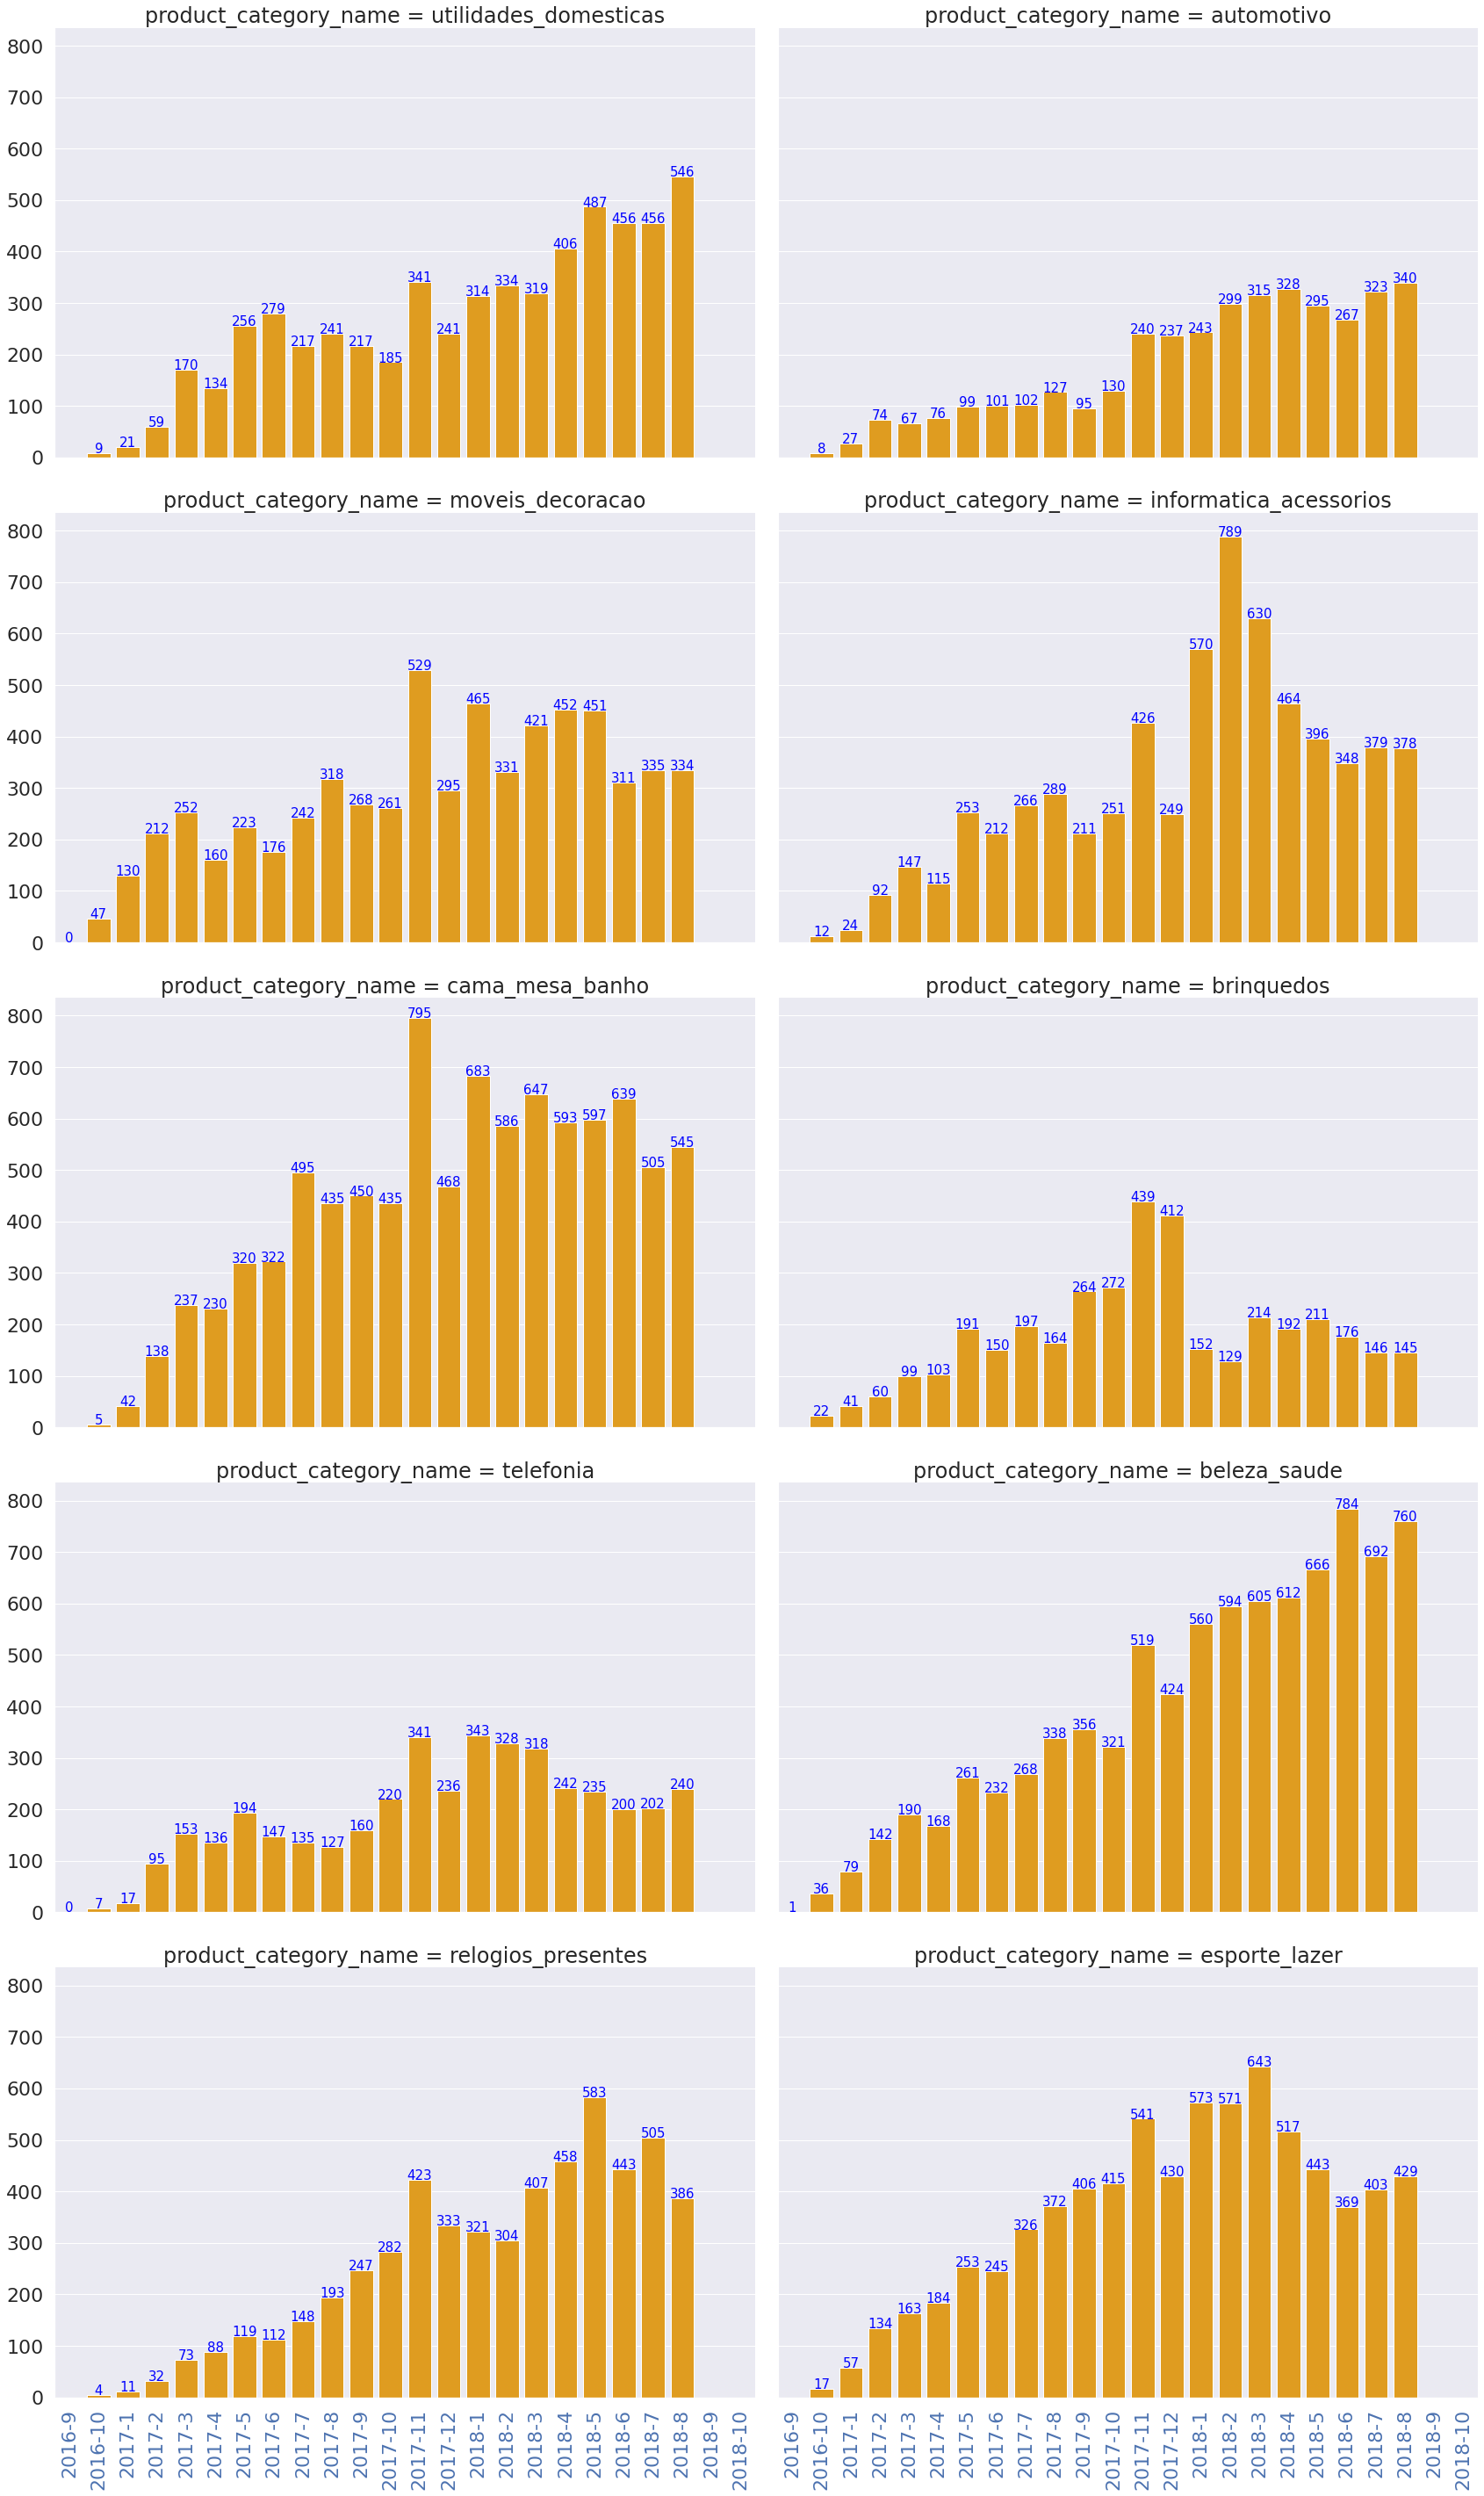

In [300]:
order=['2016-9','2016-10', '2017-1', '2017-2',
       '2017-3', '2017-4', '2017-5', '2017-6', '2017-7', '2017-8',
       '2017-9', '2017-10', '2017-11', '2017-12','2018-1', '2018-2', '2018-3', '2018-4', '2018-5',
       '2018-6', '2018-7', '2018-8','2018-9','2018-10']
graph=sns.FacetGrid(data,col='product_category_name',sharey=True,col_wrap=2,height=8,aspect=1.5)
graph.map(sns.barplot,'year_month','delivered',color='orange',order=order)
graph.map(plt.xticks,rotation=90)
for ax in graph.axes:
    for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=15, color='blue', xytext=(0, 5),
                 textcoords='offset points')

plt.show()

# Top ten products delivered late than the estimated delivery time

In [301]:
seller_merge_dataset=order_items.merge(sellers,on='seller_id',how='left')
seller_merge_dataset.shape

(98666, 10)

In [302]:
seller_merge_dataset=seller_merge_dataset.drop_duplicates(subset='order_id',inplace=False,keep='first')
seller_merge_dataset.shape

(98666, 10)

In [303]:
customer_seller_dataset=df1.merge(seller_merge_dataset,on='order_id',how='inner')
customer_seller_dataset['order_purchase_timestamp']

0        2017-10-02 10:56:33
1        2018-07-24 20:41:37
2        2018-08-08 08:38:49
3        2017-11-18 19:28:06
4        2018-02-13 21:18:39
                ...         
98661    2017-03-09 09:54:05
98662    2018-02-06 12:58:58
98663    2017-08-27 14:46:43
98664    2018-01-08 21:28:27
98665    2018-03-08 20:57:30
Name: order_purchase_timestamp, Length: 98666, dtype: object

In [304]:
customer_seller_dataset['customer_seller']=customer_seller_dataset['customer_state']+'-'+customer_seller_dataset['seller_state']
len(customer_seller_dataset['customer_seller'].unique())

414

In [305]:

customer_seller_dataset['order_purchase_timestamp']=pd.to_datetime(customer_seller_dataset['order_purchase_timestamp'],format="%Y-%m-%d %H:%M:%S")
customer_seller_dataset['new_date']=customer_seller_dataset['order_purchase_timestamp'].dt.year.astype(str)+'-'+customer_seller_dataset['order_purchase_timestamp'].dt.month.astype(str)+'-'+customer_seller_dataset['order_purchase_timestamp'].dt.day.astype(str)

customer_seller_dataset['new_date']=pd.to_datetime(customer_seller_dataset['new_date'],format="%Y-%m-%d")
customer_seller_dataset['new_date']


0       2017-10-02
1       2018-07-24
2       2018-08-08
3       2017-11-18
4       2018-02-13
           ...    
98661   2017-03-09
98662   2018-02-06
98663   2017-08-27
98664   2018-01-08
98665   2018-03-08
Name: new_date, Length: 98666, dtype: datetime64[ns]

In [306]:
customer_seller_dataset['order_delivered_customer_date']=pd.to_datetime(customer_seller_dataset['order_delivered_customer_date'],format="%Y-%m-%d %H:%M:%S")
customer_seller_dataset['new_date2']=customer_seller_dataset['order_delivered_customer_date'].dt.year.astype(str)+'-'+customer_seller_dataset['order_delivered_customer_date'].dt.month.astype(str)+'-'+customer_seller_dataset['order_delivered_customer_date'].dt.day.astype(str)
customer_seller_dataset['new_date2']=pd.to_datetime(customer_seller_dataset['new_date2'],format="%Y.0-%m.0-%d.0",errors='coerce')
customer_seller_dataset['new_date2']

0       2017-10-10
1       2018-08-07
2       2018-08-17
3       2017-12-02
4       2018-02-16
           ...    
98661   2017-03-17
98662   2018-02-28
98663   2017-09-21
98664   2018-01-25
98665   2018-03-16
Name: new_date2, Length: 98666, dtype: datetime64[ns]

In [307]:
customer_seller_dataset['order_estimated_delivery_date']=pd.to_datetime(customer_seller_dataset['order_estimated_delivery_date'],format="%Y-%m-%d %H:%M:%S")
customer_seller_dataset['new_date3']=customer_seller_dataset['order_estimated_delivery_date'].dt.year.astype(str)+'-'+customer_seller_dataset['order_estimated_delivery_date'].dt.month.astype(str)+'-'+customer_seller_dataset['order_estimated_delivery_date'].dt.day.astype(str)

customer_seller_dataset['new_date3']=pd.to_datetime(customer_seller_dataset['new_date3'],format="%Y-%m-%d")
customer_seller_dataset['new_date3']

0       2017-10-18
1       2018-08-13
2       2018-09-04
3       2017-12-15
4       2018-02-26
           ...    
98661   2017-03-28
98662   2018-03-02
98663   2017-09-27
98664   2018-02-15
98665   2018-04-03
Name: new_date3, Length: 98666, dtype: datetime64[ns]

In [308]:
customer_seller_dataset['actual_delivery']=(customer_seller_dataset['new_date2']-customer_seller_dataset['new_date'])
customer_seller_dataset['estimated_delivery']=(customer_seller_dataset['new_date3']-customer_seller_dataset['new_date'])

In [309]:
customer_seller_dataset['late_delivery']=(customer_seller_dataset['estimated_delivery']<customer_seller_dataset['actual_delivery']).astype(int)


In [310]:
customer_seller_dataset_2=customer_seller_dataset.merge(products,on='product_id',how='left')
print(customer_seller_dataset.shape)
sum(customer_seller_dataset_2['late_delivery'])

(98666, 28)


6535

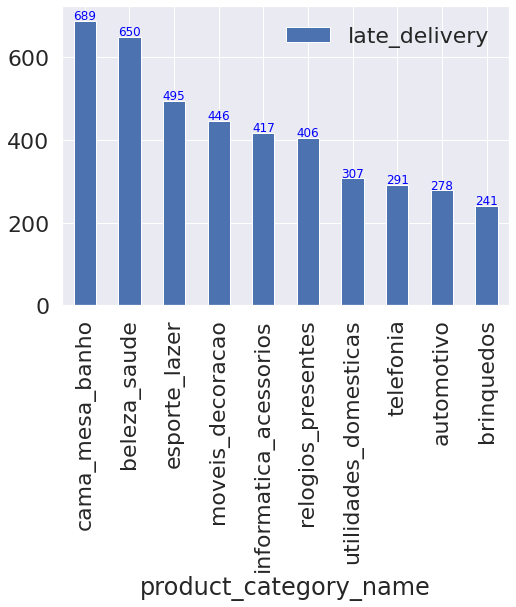

In [311]:
products_late_delivered=pd.DataFrame(customer_seller_dataset_2.groupby(['product_category_name'])['late_delivery'].sum())
products_late_delivered.reset_index(inplace=True)
chart=products_late_delivered.sort_values(by='late_delivery',ascending=False).head(10).plot(kind='bar',x='product_category_name',y='late_delivery')
products_late_delivered_2=products_late_delivered.sort_values(by='late_delivery',ascending=False).head(10)
for p in chart.patches:
        chart.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', fontsize=12, color='blue', xytext=(0, 5),
        textcoords='offset points')

# Count of late deliveries for all combinations of year and month for the top ten late delivered products

In [312]:
customer_seller_dataset_2['year_month']=customer_seller_dataset_2['new_date'].dt.year.astype(str)+'-'+customer_seller_dataset_2['new_date'].dt.month.astype(str)
a=products_late_delivered_2['product_category_name'].unique()
listd=[]
for i in a:
    customer_seller_dataset_3=customer_seller_dataset_2[customer_seller_dataset_2['product_category_name']==i]
    listd.append(customer_seller_dataset_3)
customer_seller_dataset_4=pd.concat(listd)
customer_seller_dataset_5=pd.DataFrame(customer_seller_dataset_4.groupby(['product_category_name','year_month'])['late_delivery'].sum())
customer_seller_dataset_5.reset_index(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning:

The handle <matplotlib.lines.Line2D object at 0x7f02860ebc10> has a label of '_' which cannot be automatically added to the legend.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning:

The handle <matplotlib.lines.Line2D object at 0x7f02860ef750> has a label of '_' which cannot be automatically added to the legend.



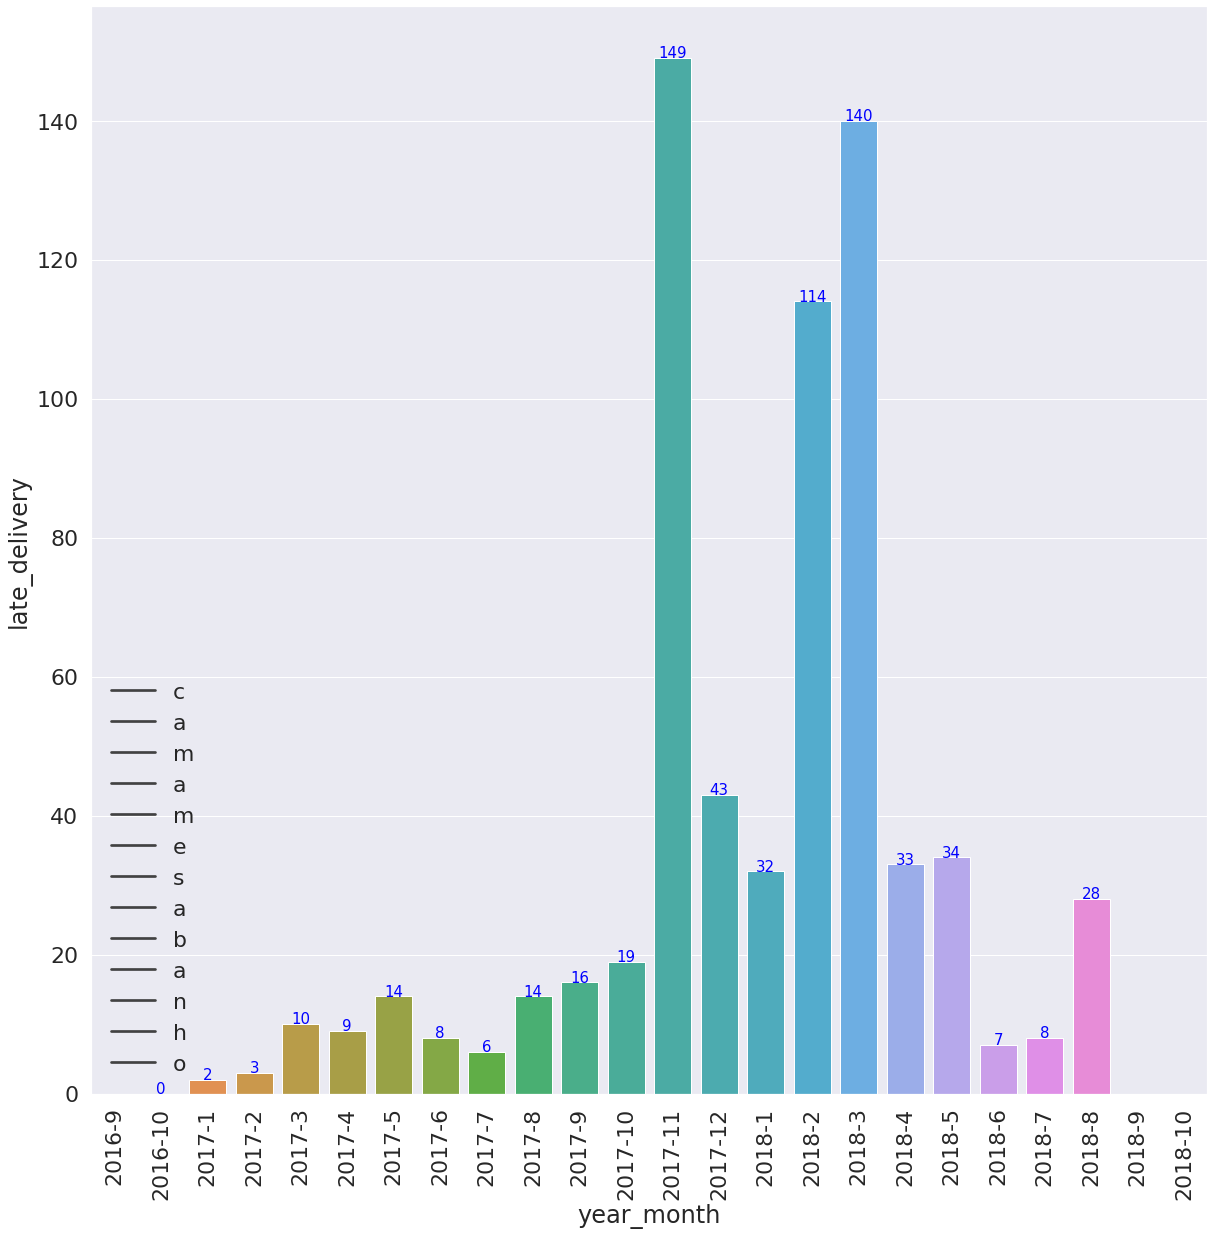

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning:

The handle <matplotlib.lines.Line2D object at 0x7f0286f22e90> has a label of '_' which cannot be automatically added to the legend.



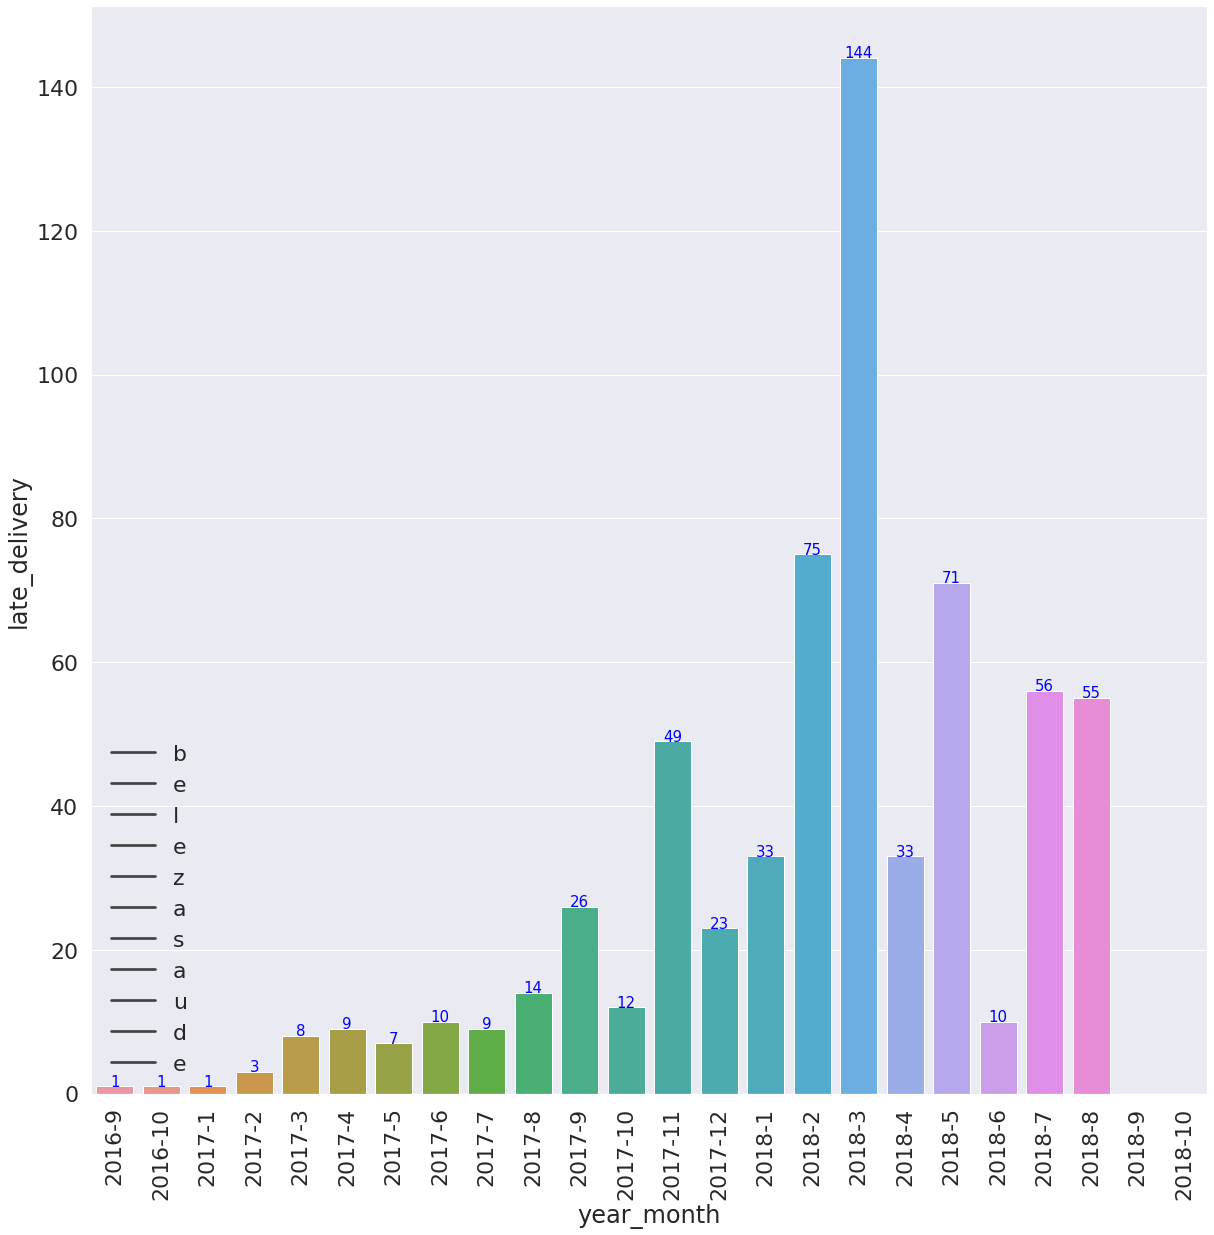

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning:

The handle <matplotlib.lines.Line2D object at 0x7f02870d9110> has a label of '_' which cannot be automatically added to the legend.



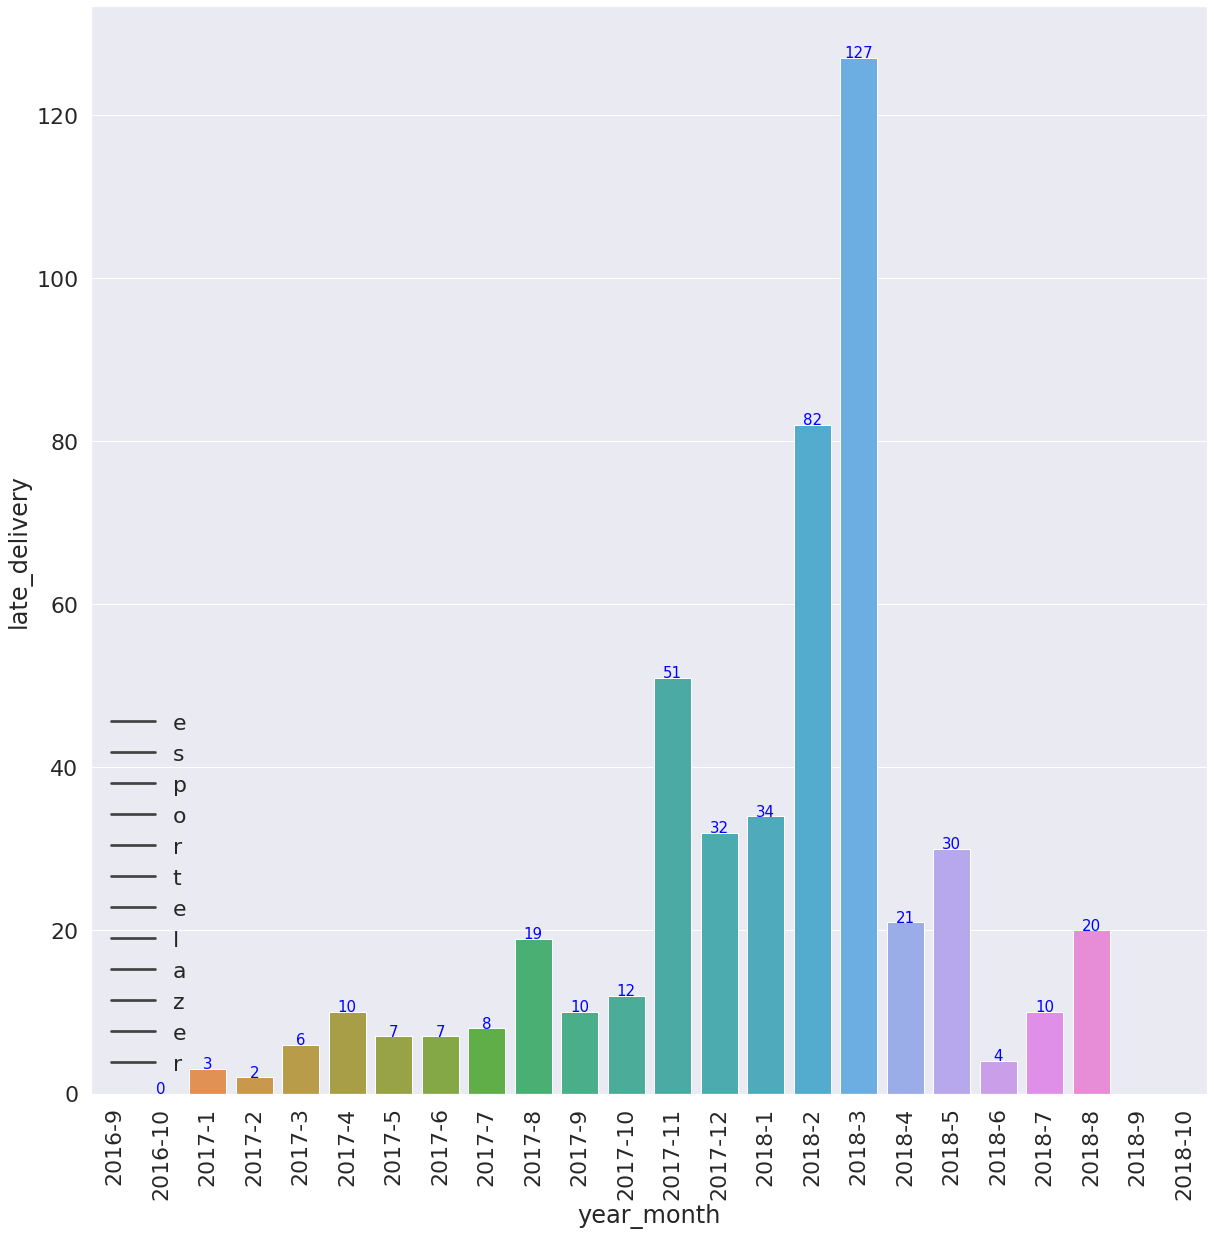

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning:

The handle <matplotlib.lines.Line2D object at 0x7f02871ee690> has a label of '_' which cannot be automatically added to the legend.



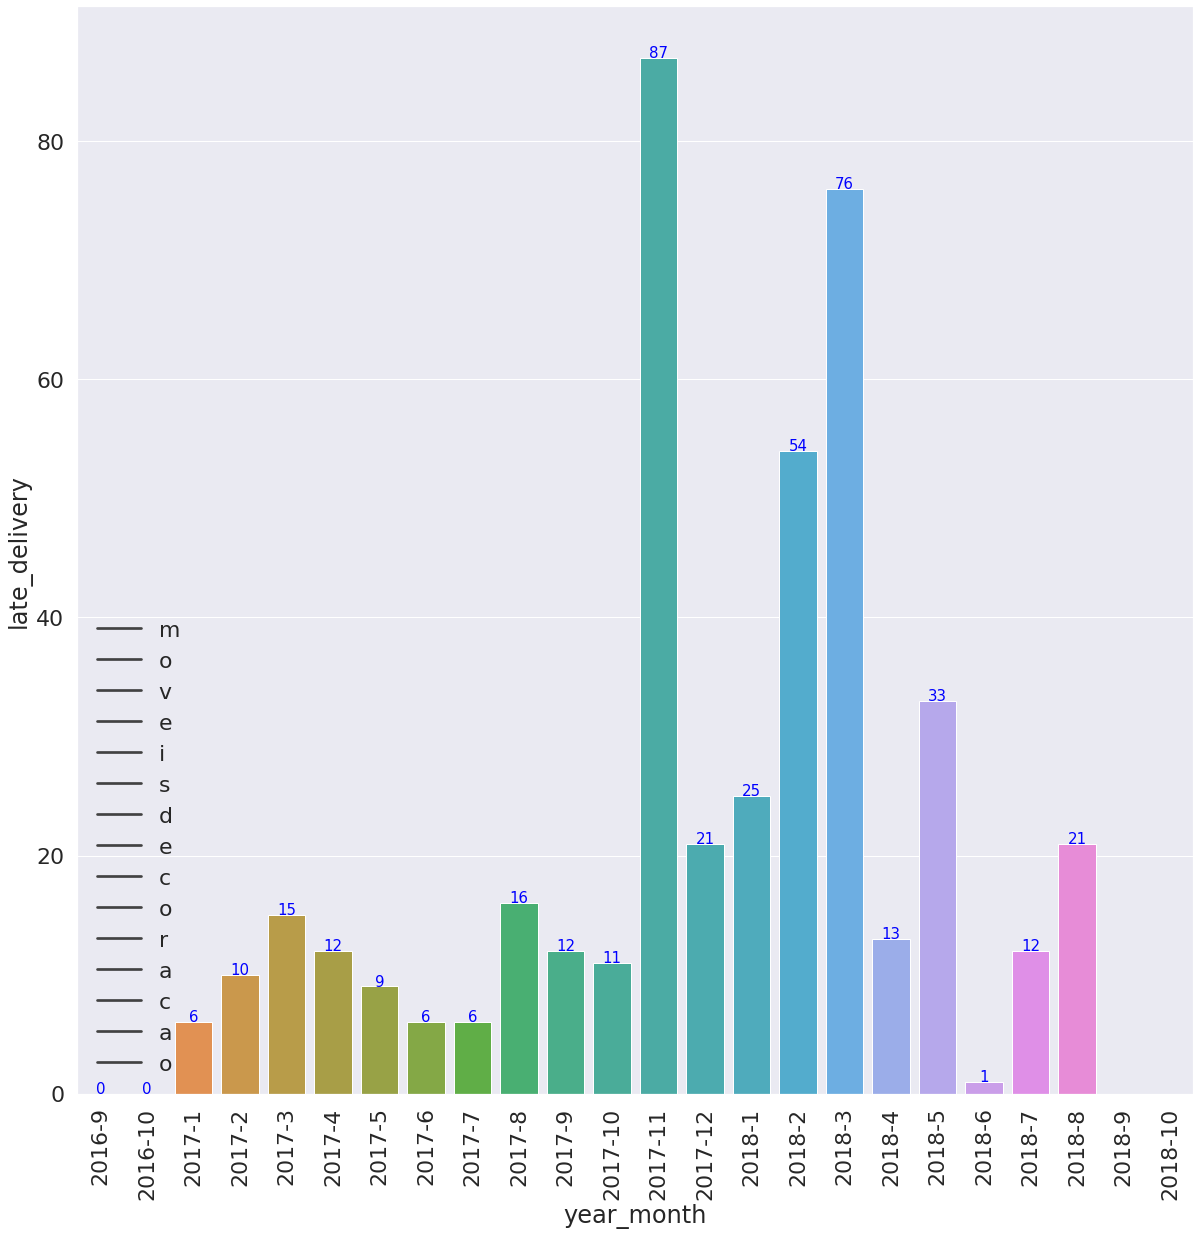

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning:

The handle <matplotlib.lines.Line2D object at 0x7f02872bb8d0> has a label of '_' which cannot be automatically added to the legend.



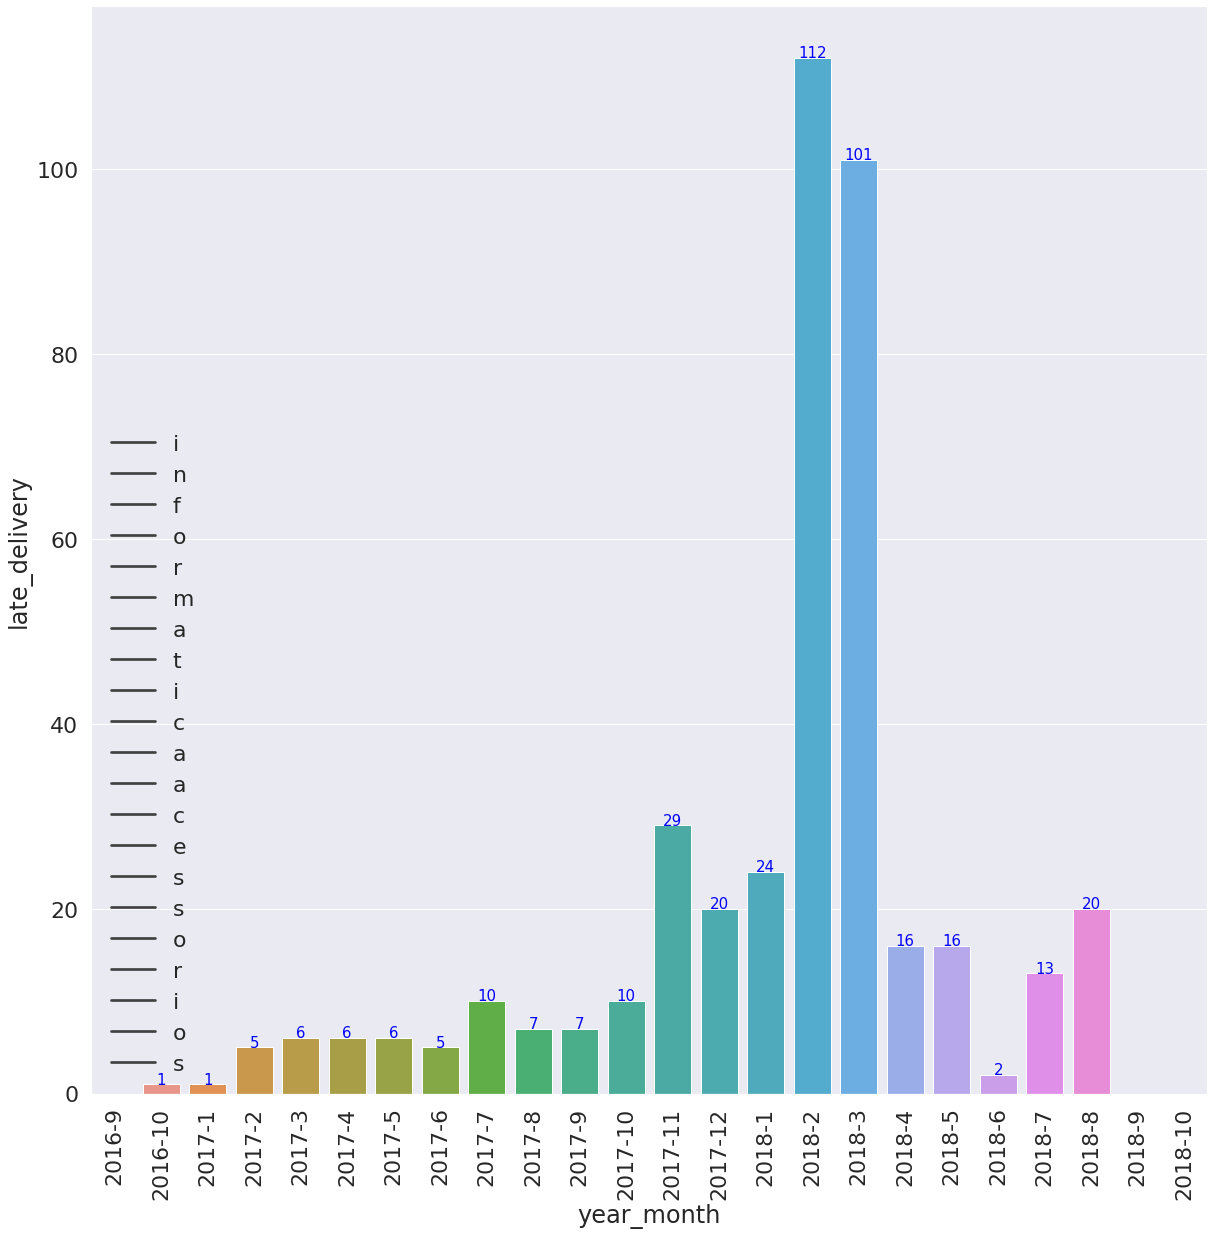

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning:

The handle <matplotlib.lines.Line2D object at 0x7f02872e3b10> has a label of '_' which cannot be automatically added to the legend.



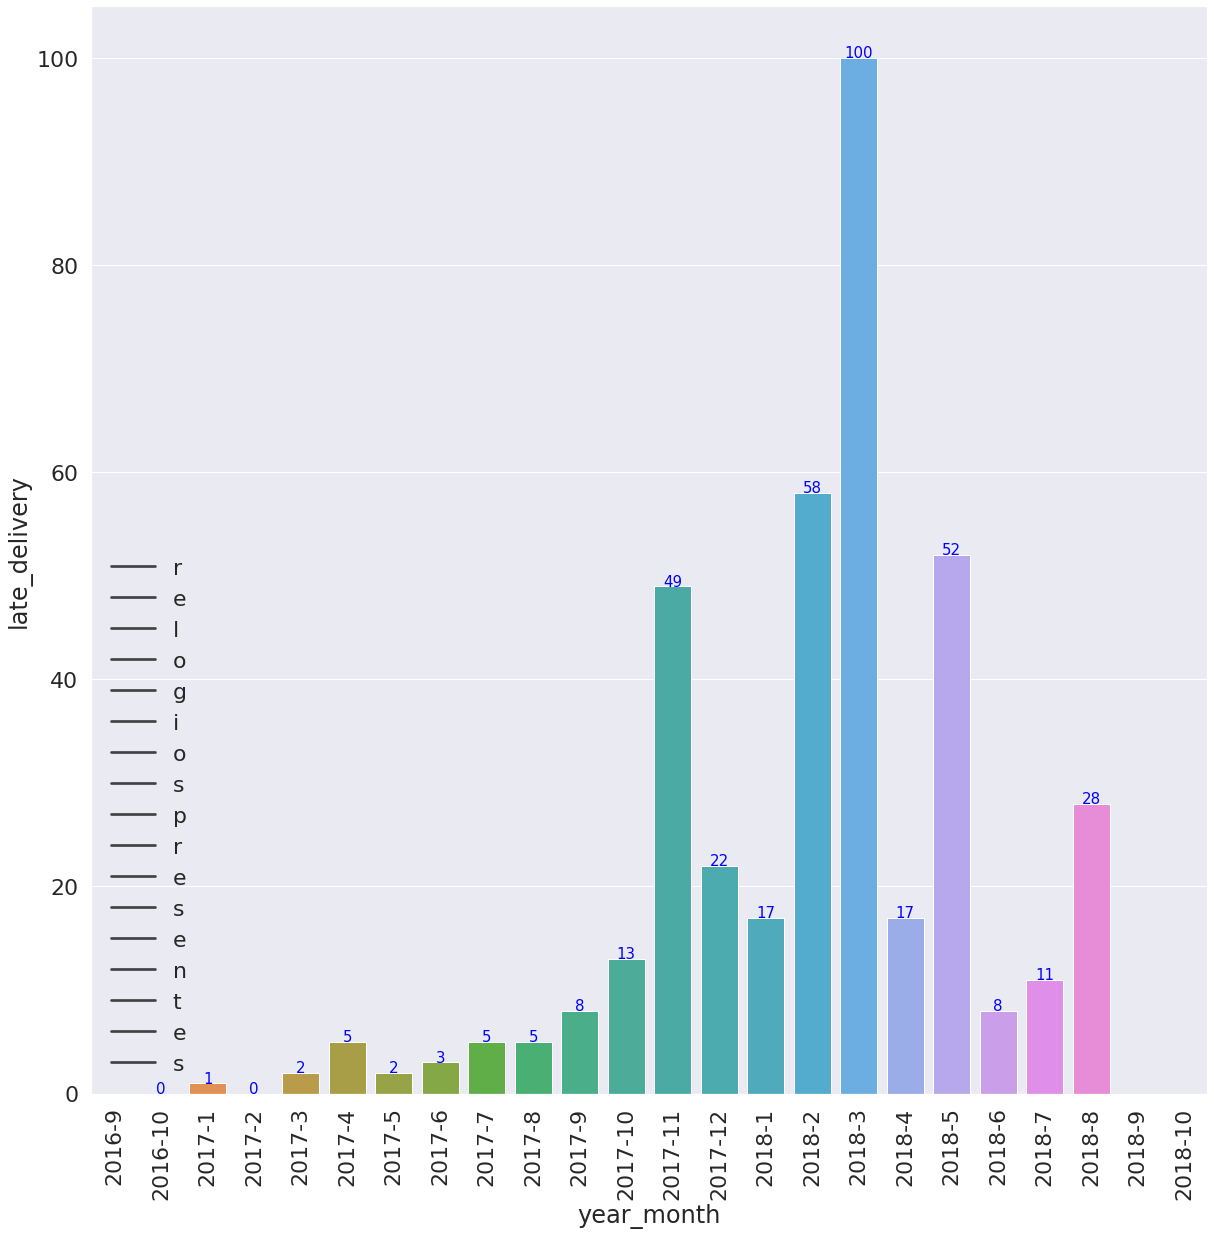

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning:

The handle <matplotlib.lines.Line2D object at 0x7f028732d450> has a label of '_' which cannot be automatically added to the legend.



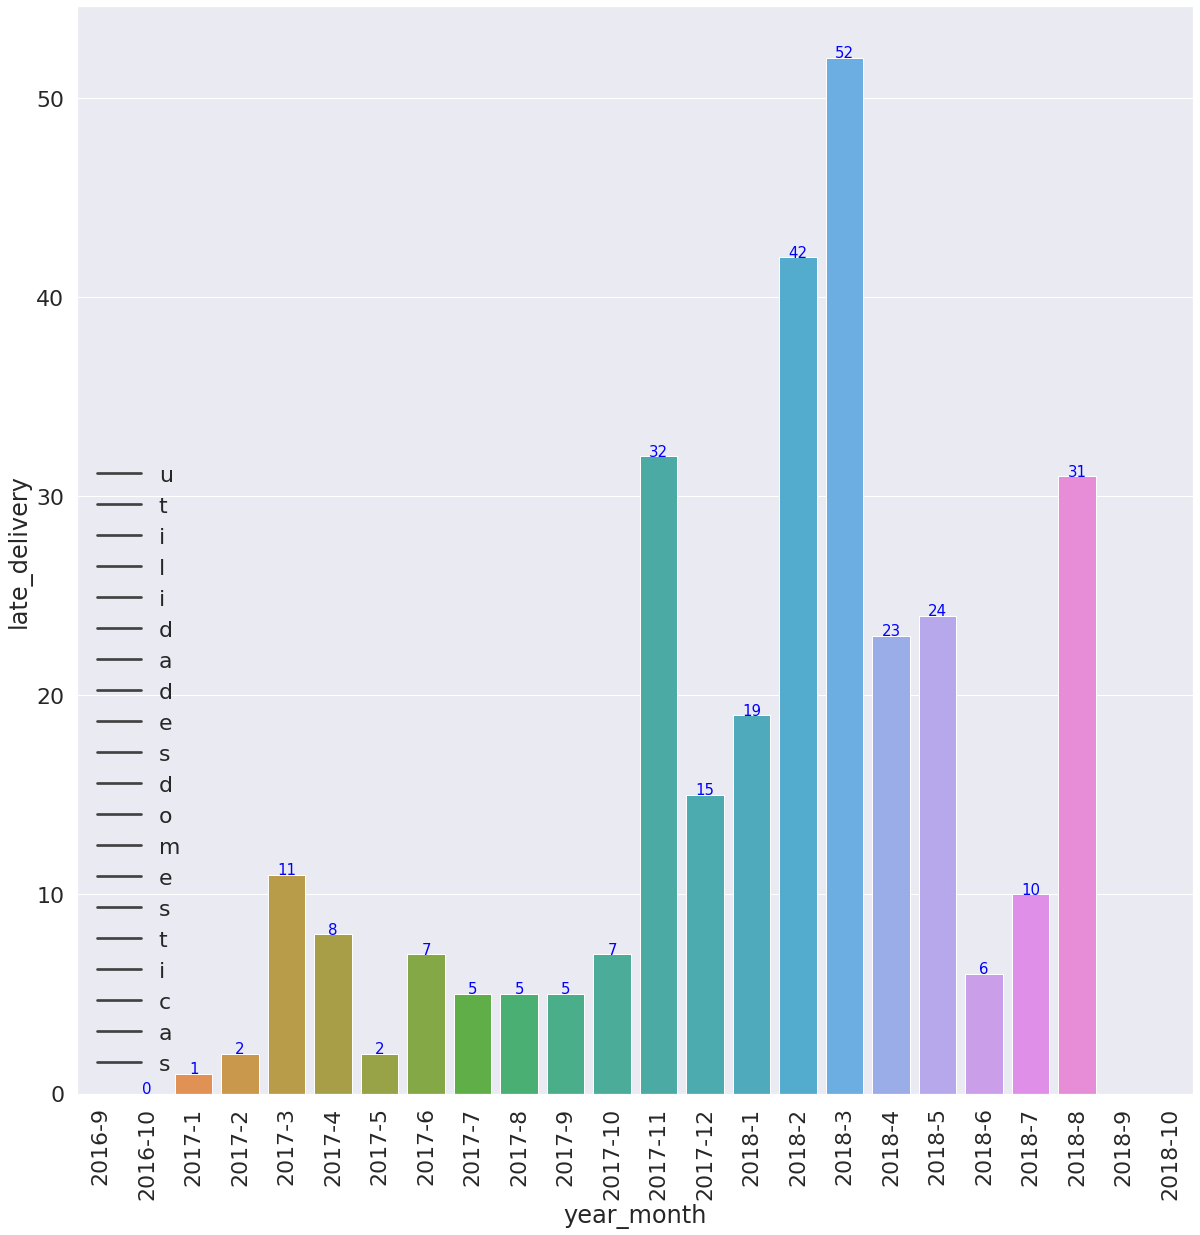

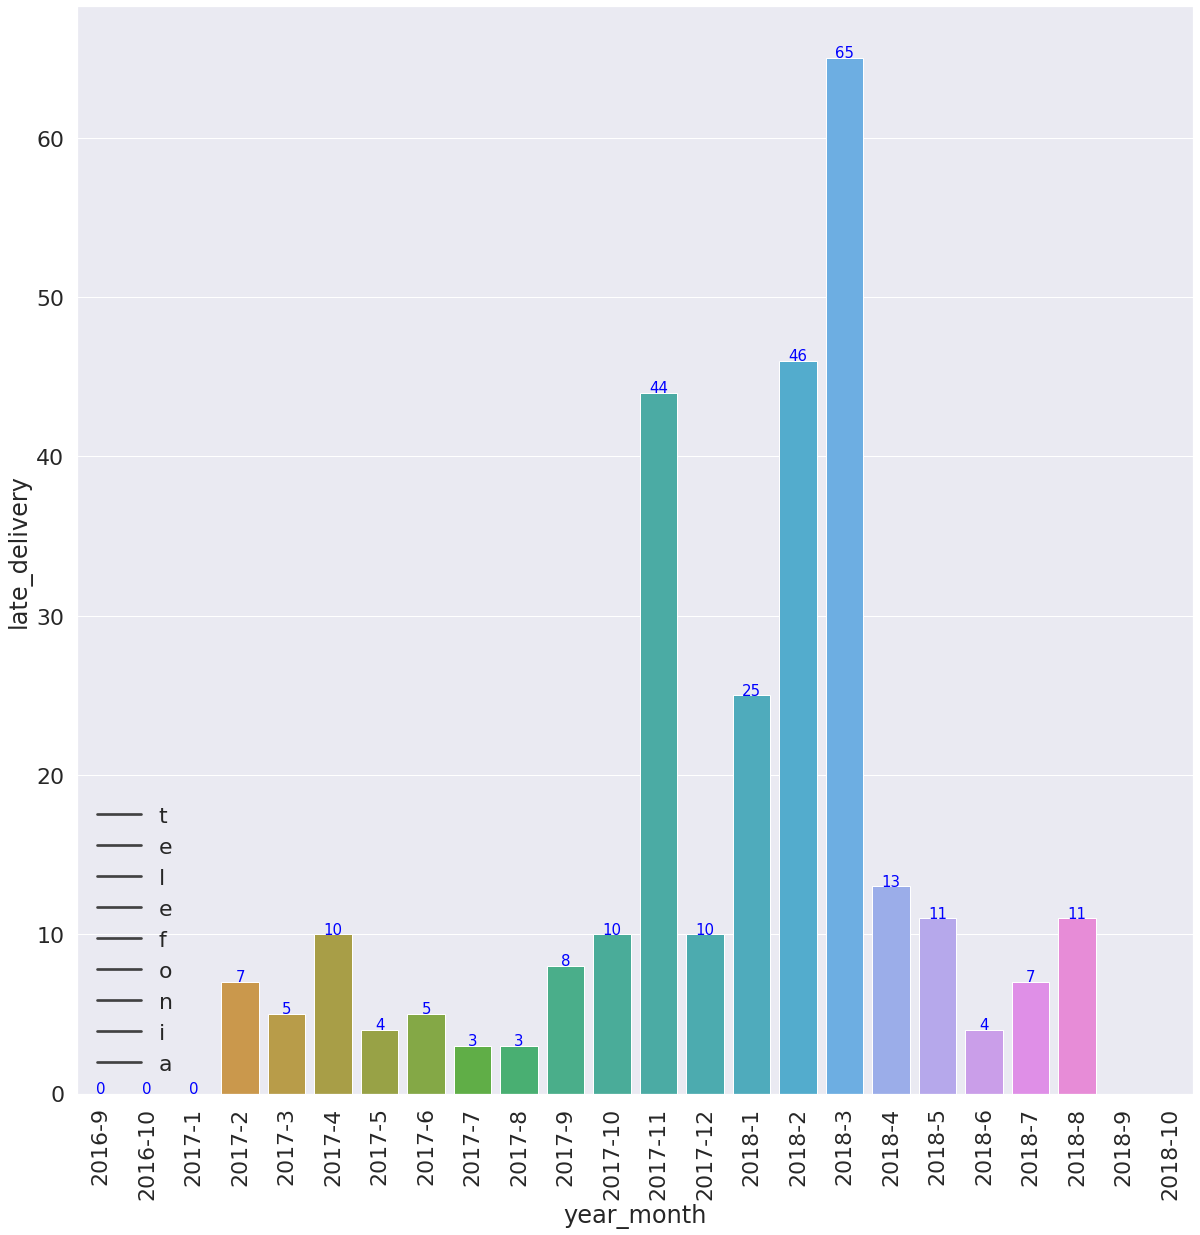

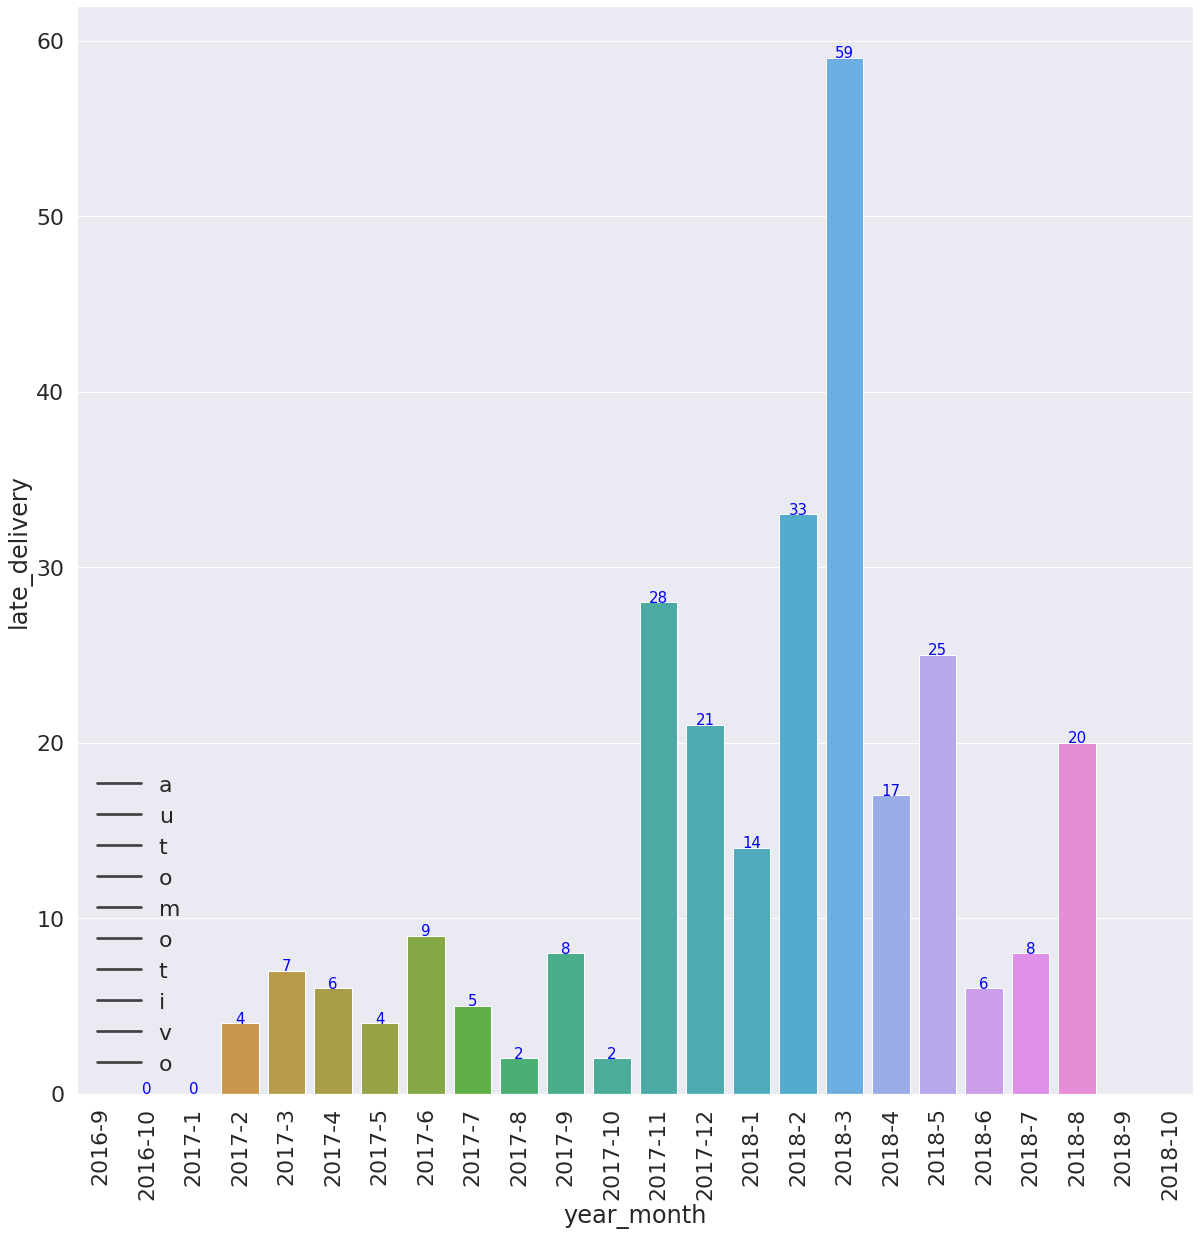

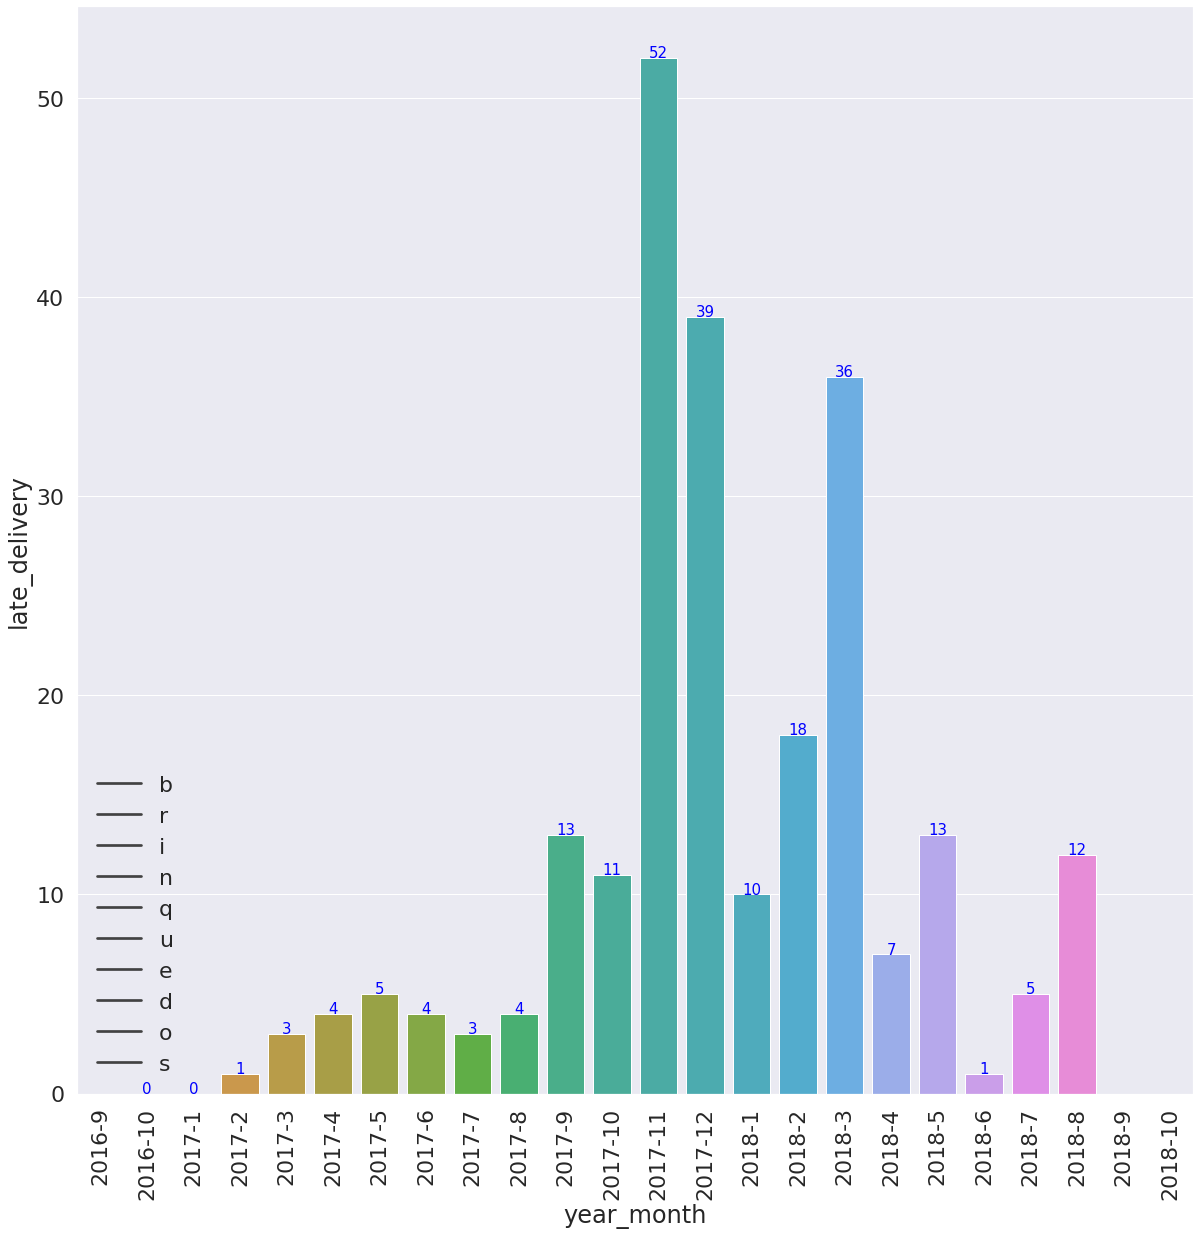

In [313]:
order=['2016-9','2016-10', '2017-1', '2017-2',
       '2017-3', '2017-4', '2017-5', '2017-6', '2017-7', '2017-8',
       '2017-9', '2017-10', '2017-11', '2017-12','2018-1', '2018-2', '2018-3', '2018-4', '2018-5',
       '2018-6', '2018-7', '2018-8','2018-9','2018-10']
legends=products_late_delivered_2['product_category_name'].unique()

for index,i in enumerate(a):
    plt.figure(figsize=(20,20))
    data=customer_seller_dataset_5[customer_seller_dataset_5['product_category_name']==i]
    chart=sns.barplot(data=data,x='year_month',y='late_delivery',order=order)
    plt.xticks(rotation=90)
    
    for p in chart.patches:
        chart.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', fontsize=15, color='blue', xytext=(0, 5),
        textcoords='offset points')
    plt.legend(legends[index],loc='lower left')
    plt.show()

# Bar graphs showing the top 10 products delivered late for different combinations of customer and seller. Also we take top 10 combinations of seller and customer in terms of count of late delivery


In [314]:
region_late_delivered_dataset=pd.DataFrame(customer_seller_dataset.groupby('customer_seller')['late_delivery'].sum())
region_late_delivered_dataset.reset_index(inplace=True)
region_late_delivered_dataset_top=region_late_delivered_dataset.sort_values(by='late_delivery',ascending=False).head(13)
region_late_delivered_dataset_top

customer_seller  late_delivery
401           SP-SP           1428
299           RJ-SP           1152
167           MG-SP            394
63            BA-SP            297
348           RS-SP            238
365           SC-SP            222
114           ES-SP            180
279           PR-SP            138
80            CE-SP            133
292           RJ-PR            117
245           PE-SP            111
130           GO-SP            106
395           SP-RJ            103

In [315]:
region_product_late_delivered_dataset=pd.DataFrame(customer_seller_dataset_2.groupby(['customer_seller','product_category_name'])['late_delivery'].sum())
region_product_late_delivered_dataset.reset_index(inplace=True)
listq=[]
for x in region_late_delivered_dataset_top['customer_seller'].unique():
    region_product_late_delivered_dataset_top=region_product_late_delivered_dataset[region_product_late_delivered_dataset['customer_seller']==x]
    region_product_late_delivered_dataset_top=region_product_late_delivered_dataset_top.sort_values(by='late_delivery',ascending=False).head(10)
    listq.append(region_product_late_delivered_dataset_top)

In [316]:
data=pd.concat(listq)
data

customer_seller   product_category_name  late_delivery
4424           SP-SP         cama_mesa_banho            153
4422           SP-SP            beleza_saude            137
4443           SP-SP           esporte_lazer            100
4464           SP-SP        moveis_decoracao             98
4481           SP-SP   utilidades_domesticas             90
...              ...                     ...            ...
4300           SP-RJ  informatica_acessorios              4
4295           SP-RJ             eletronicos              2
4282           SP-RJ              automotivo              2
4312           SP-RJ                pet_shop              2
4289           SP-RJ          consoles_games              2

[130 rows x 3 columns]

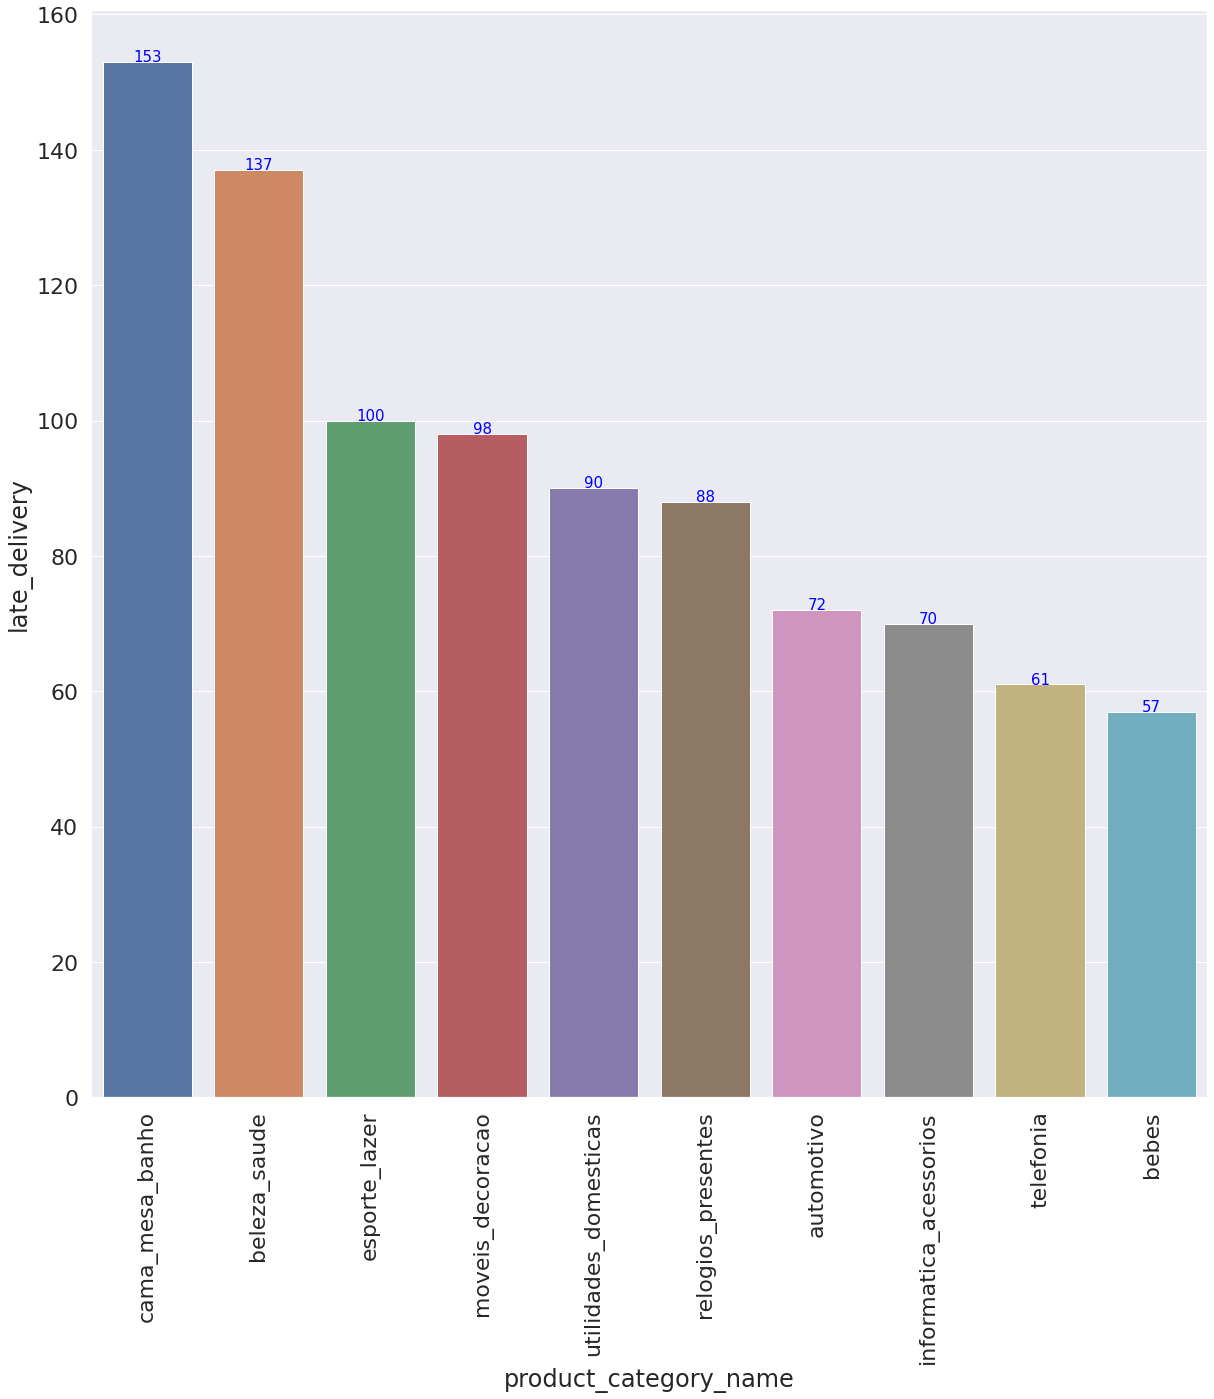

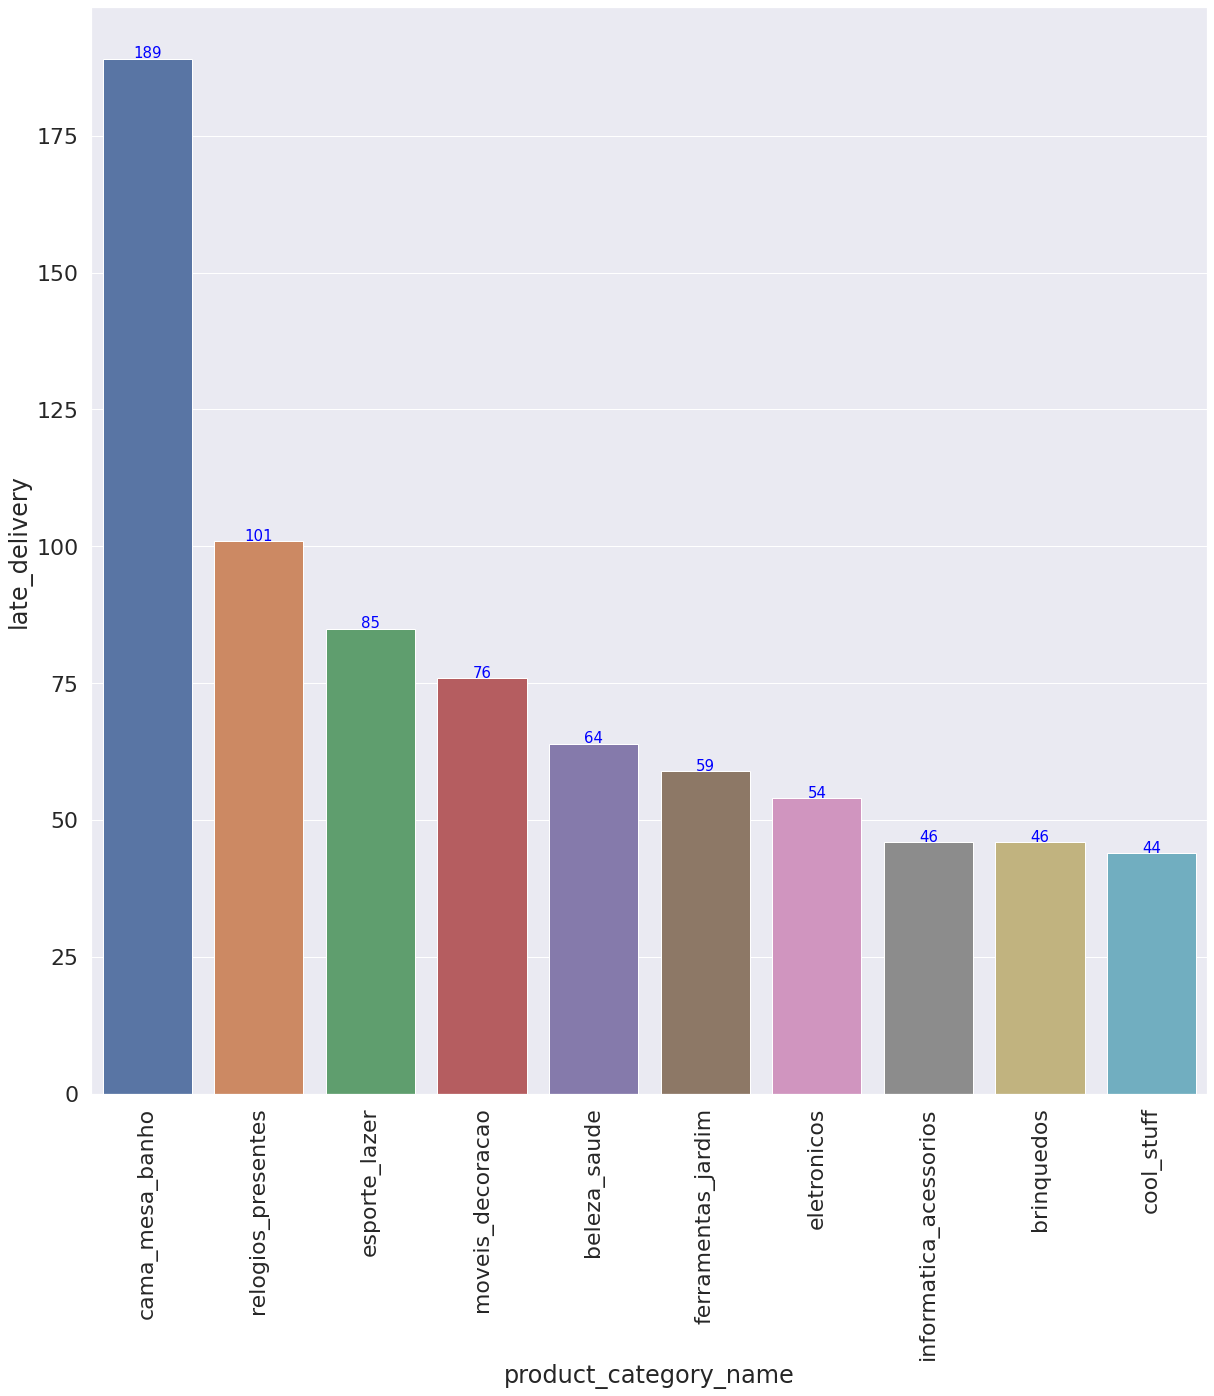

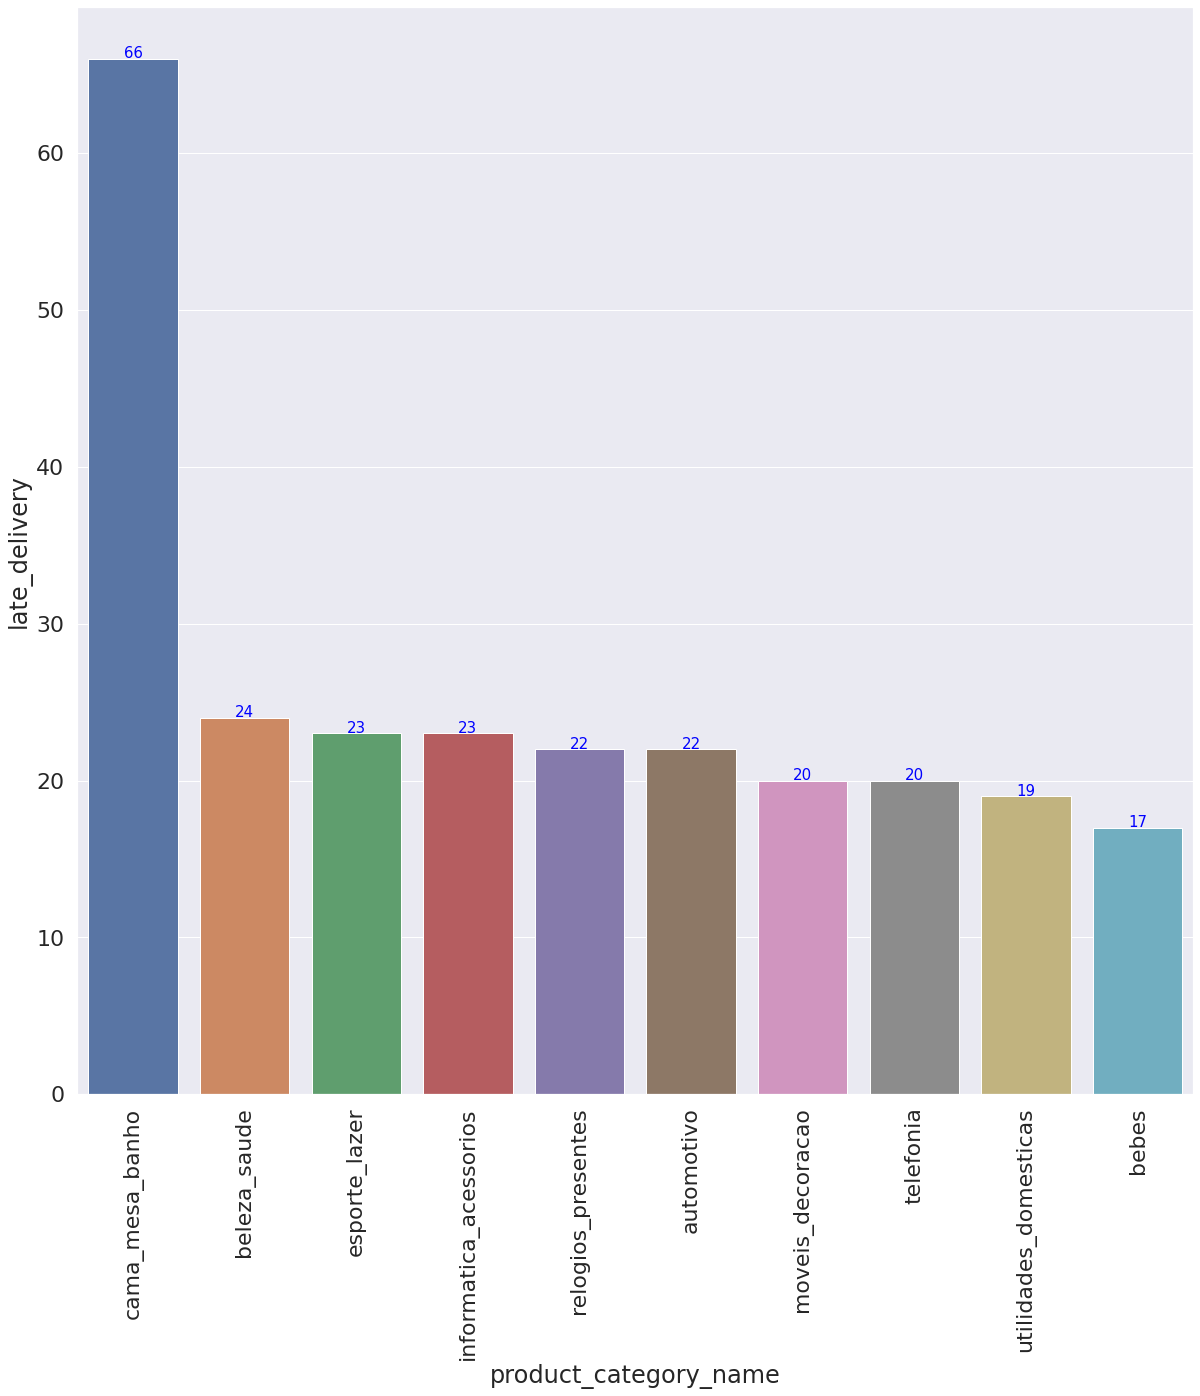

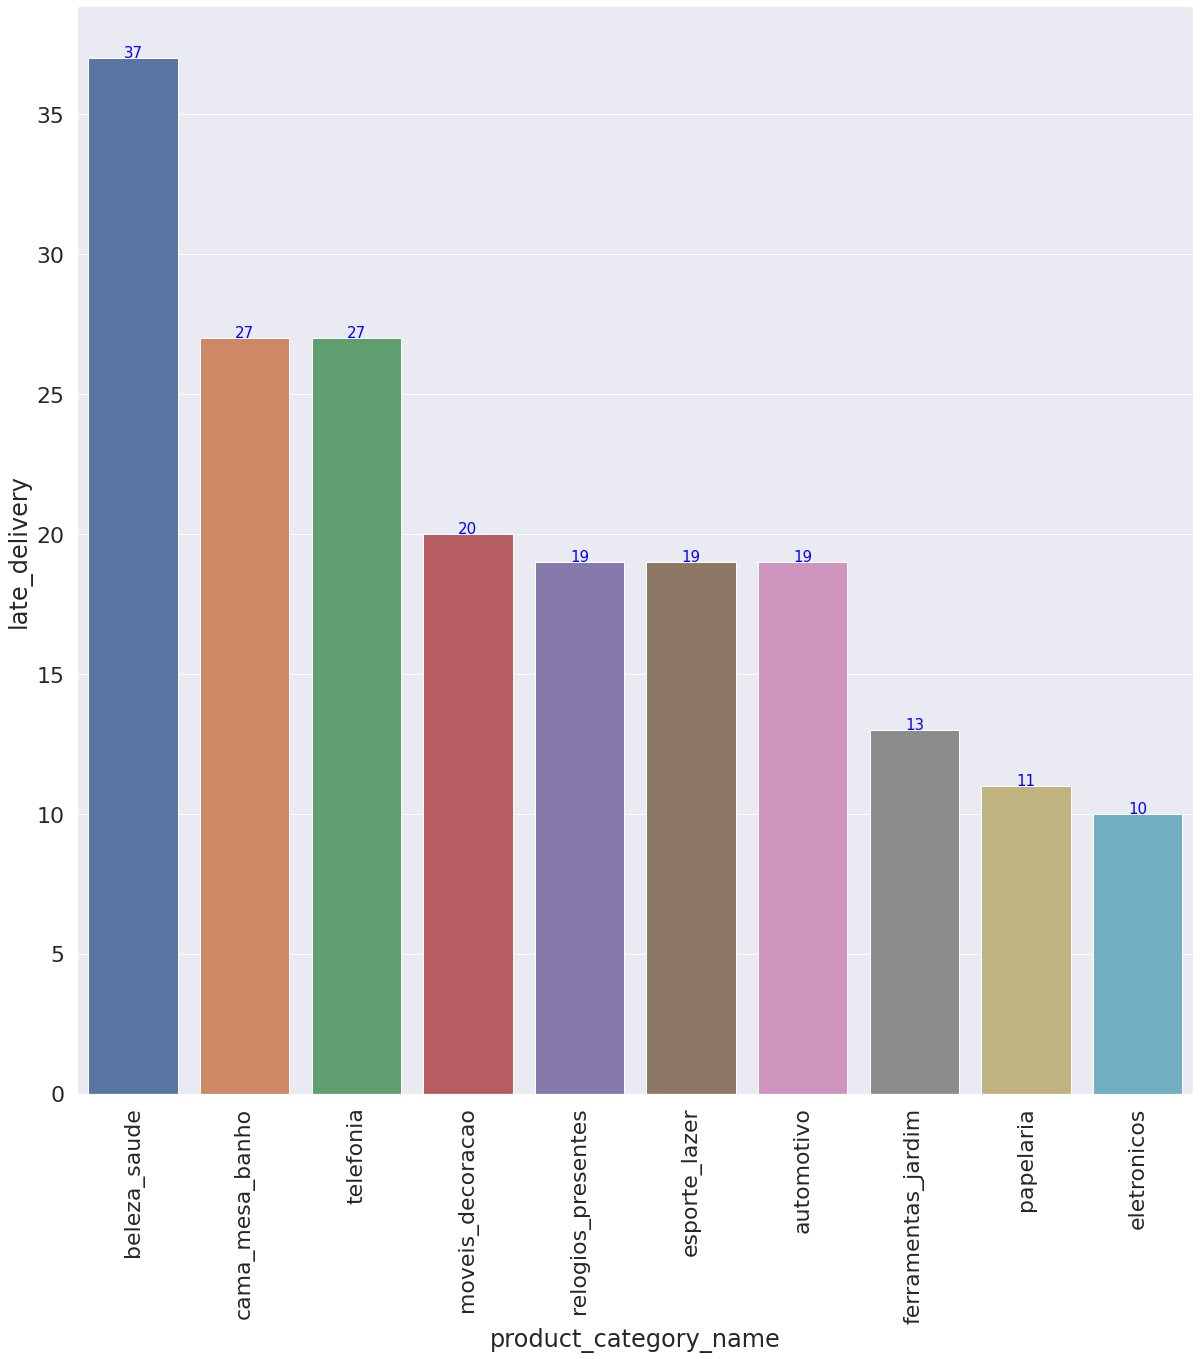

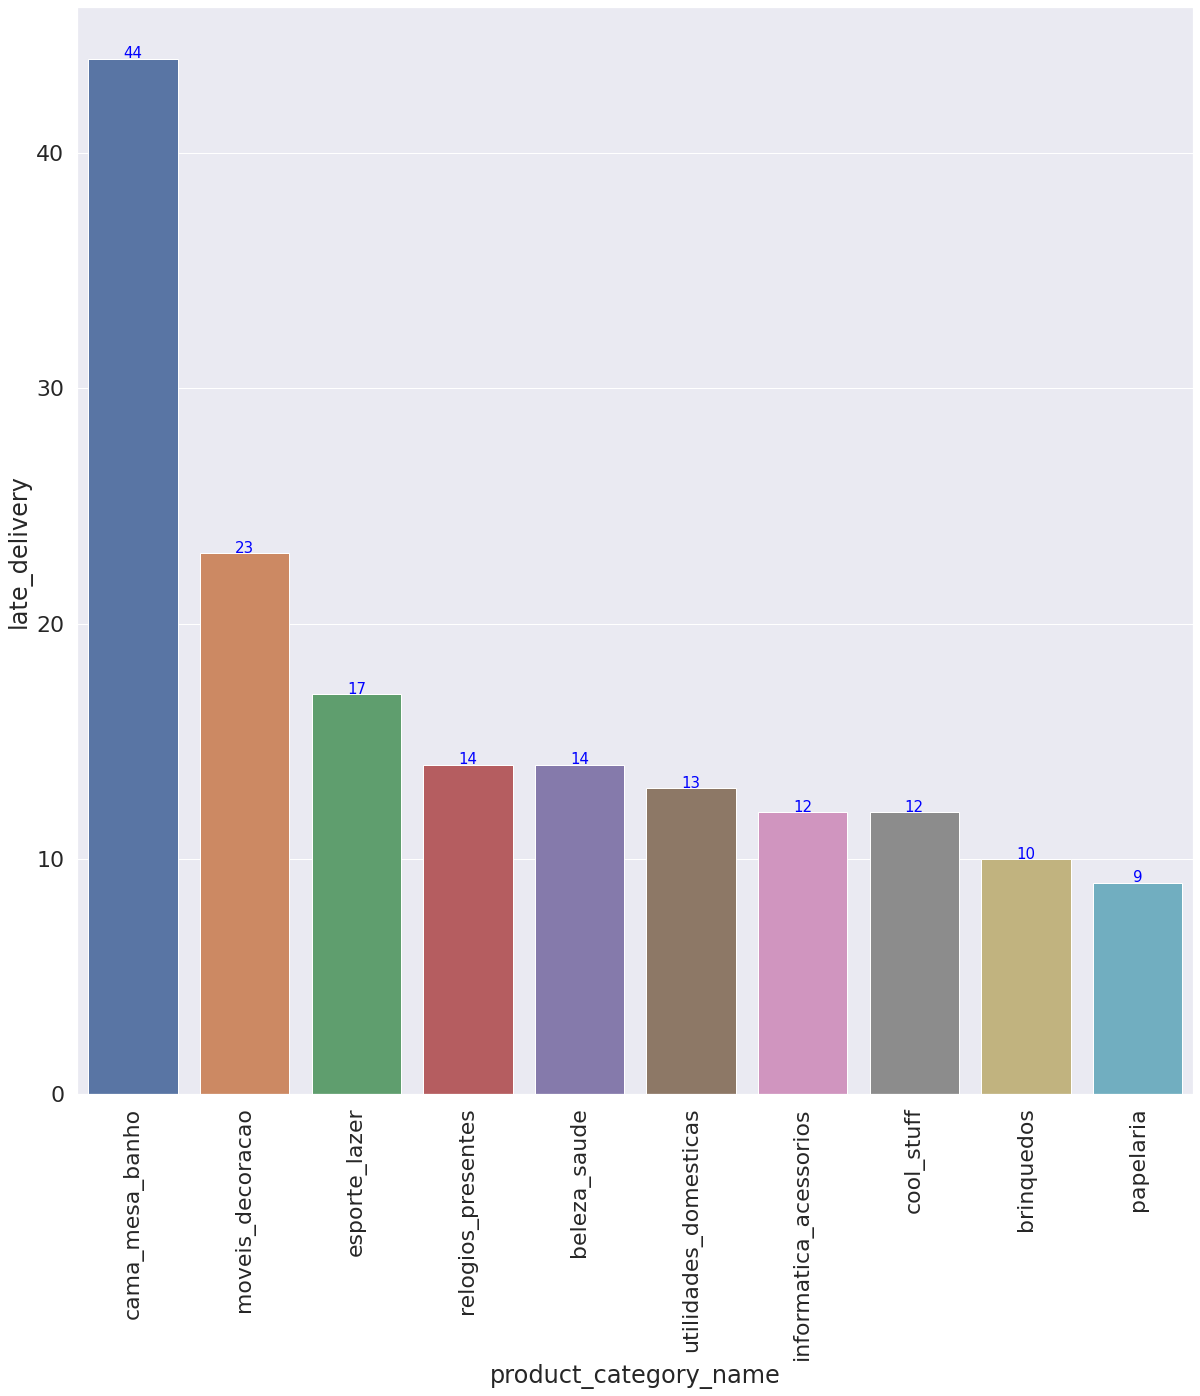

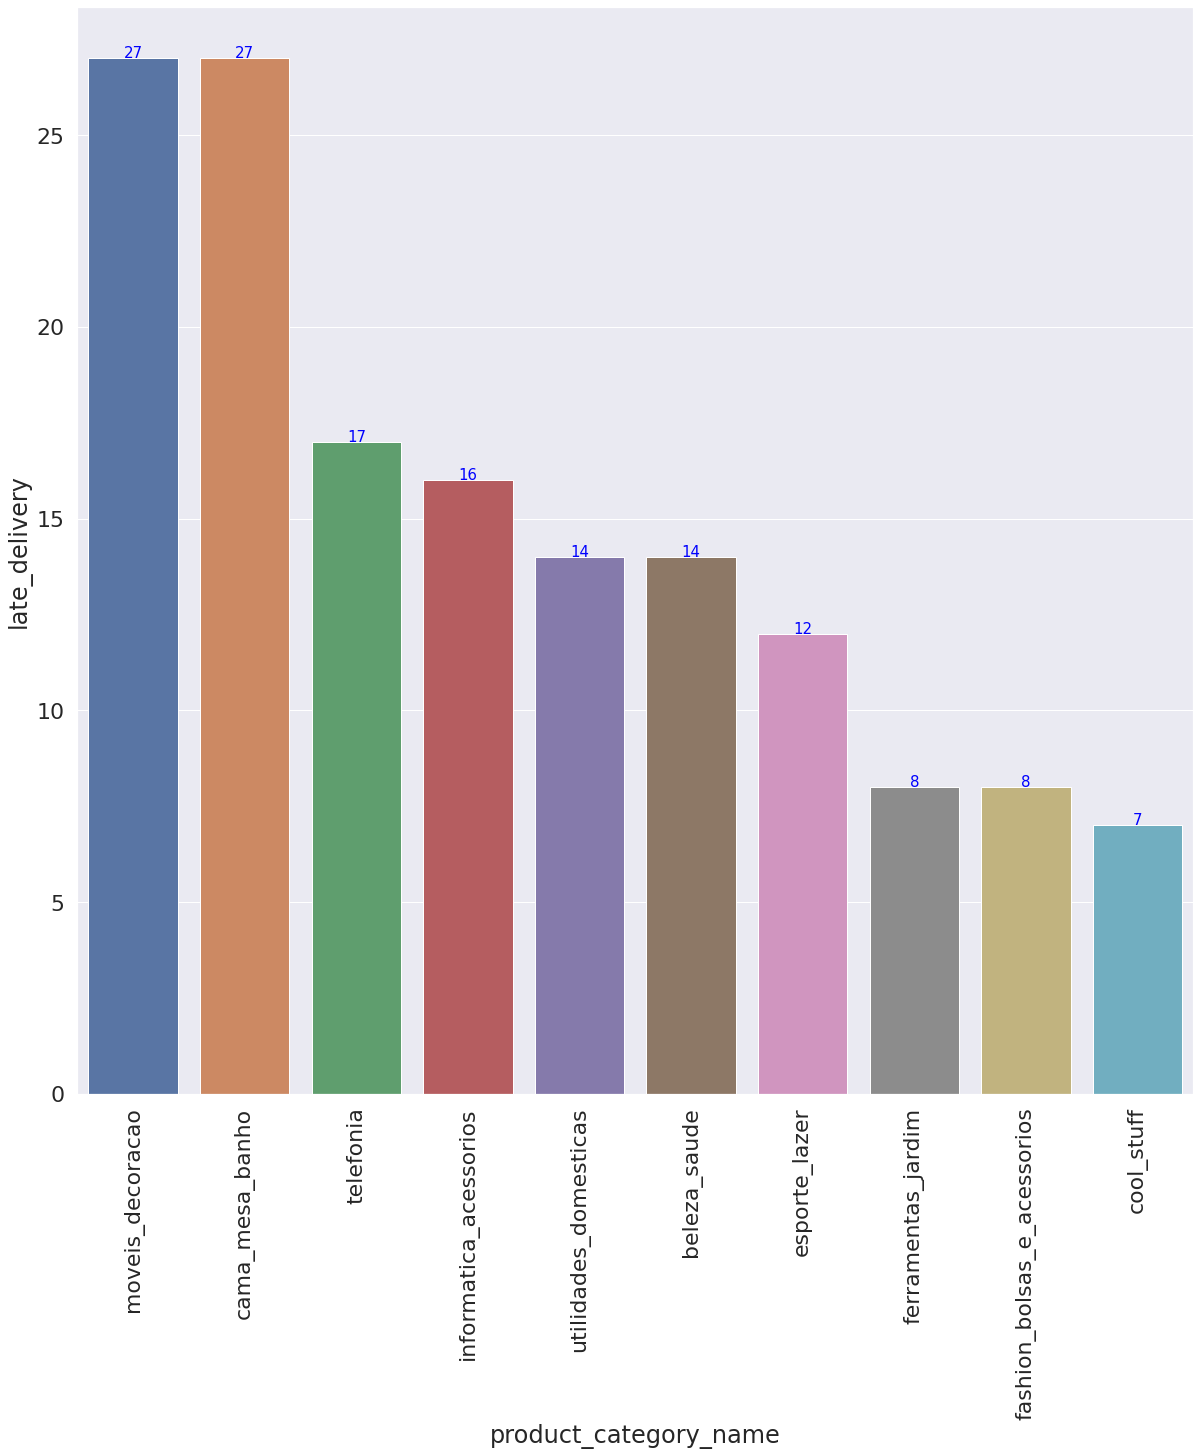

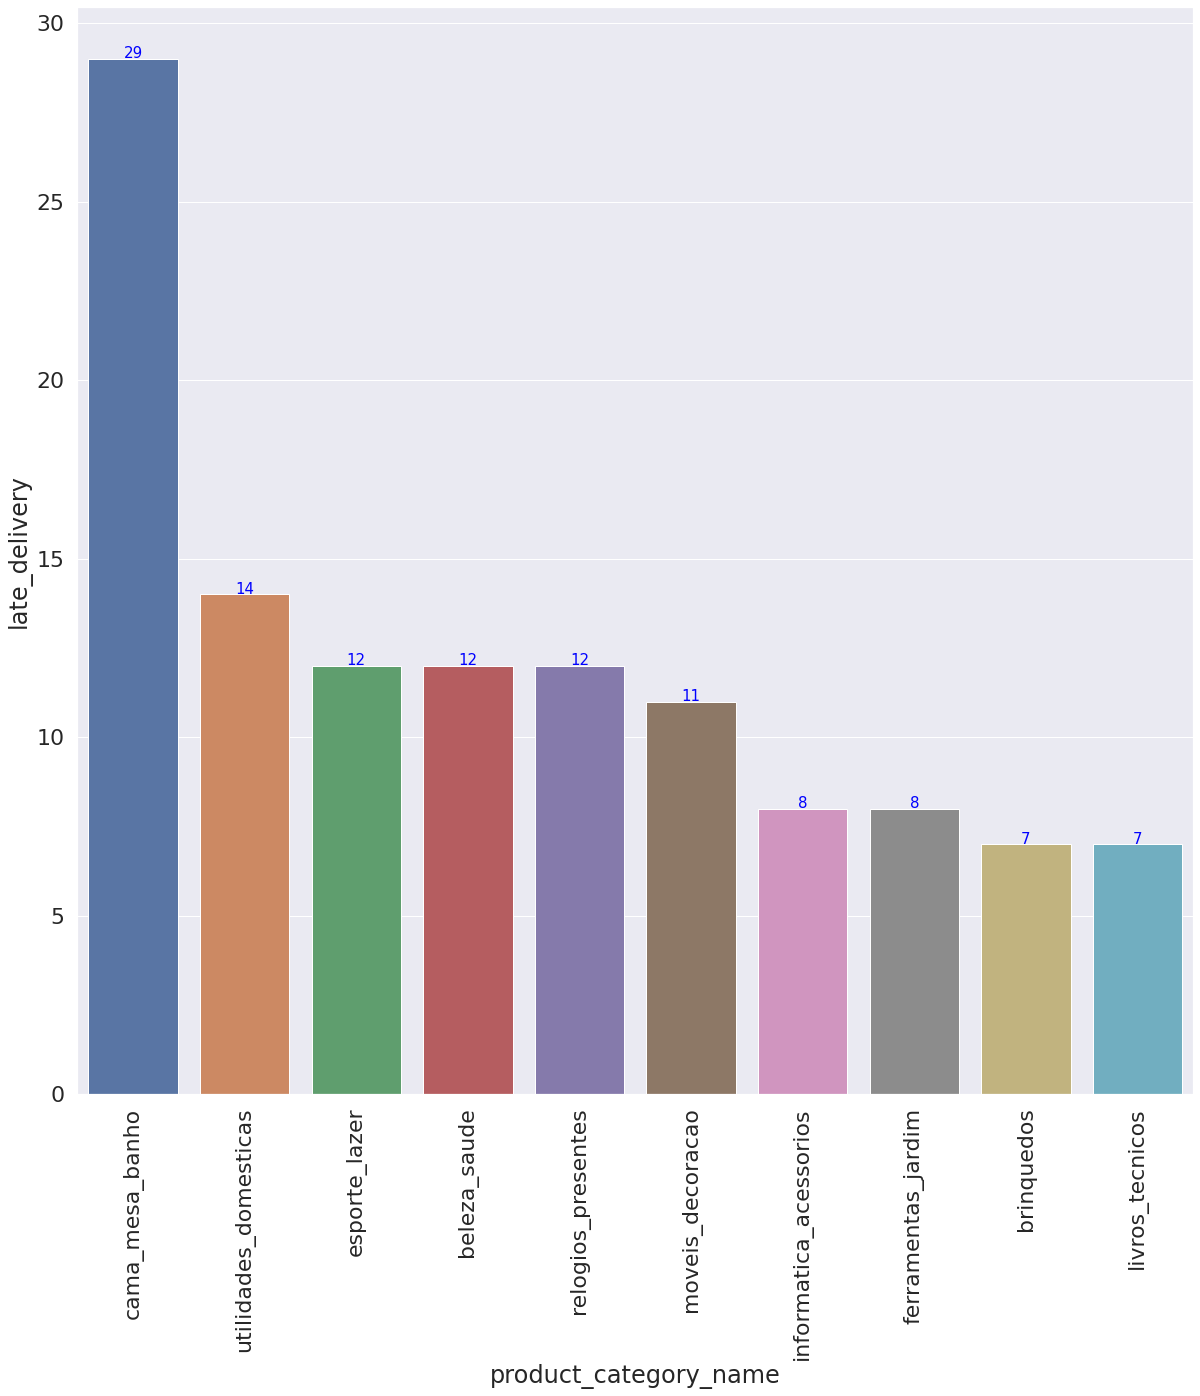

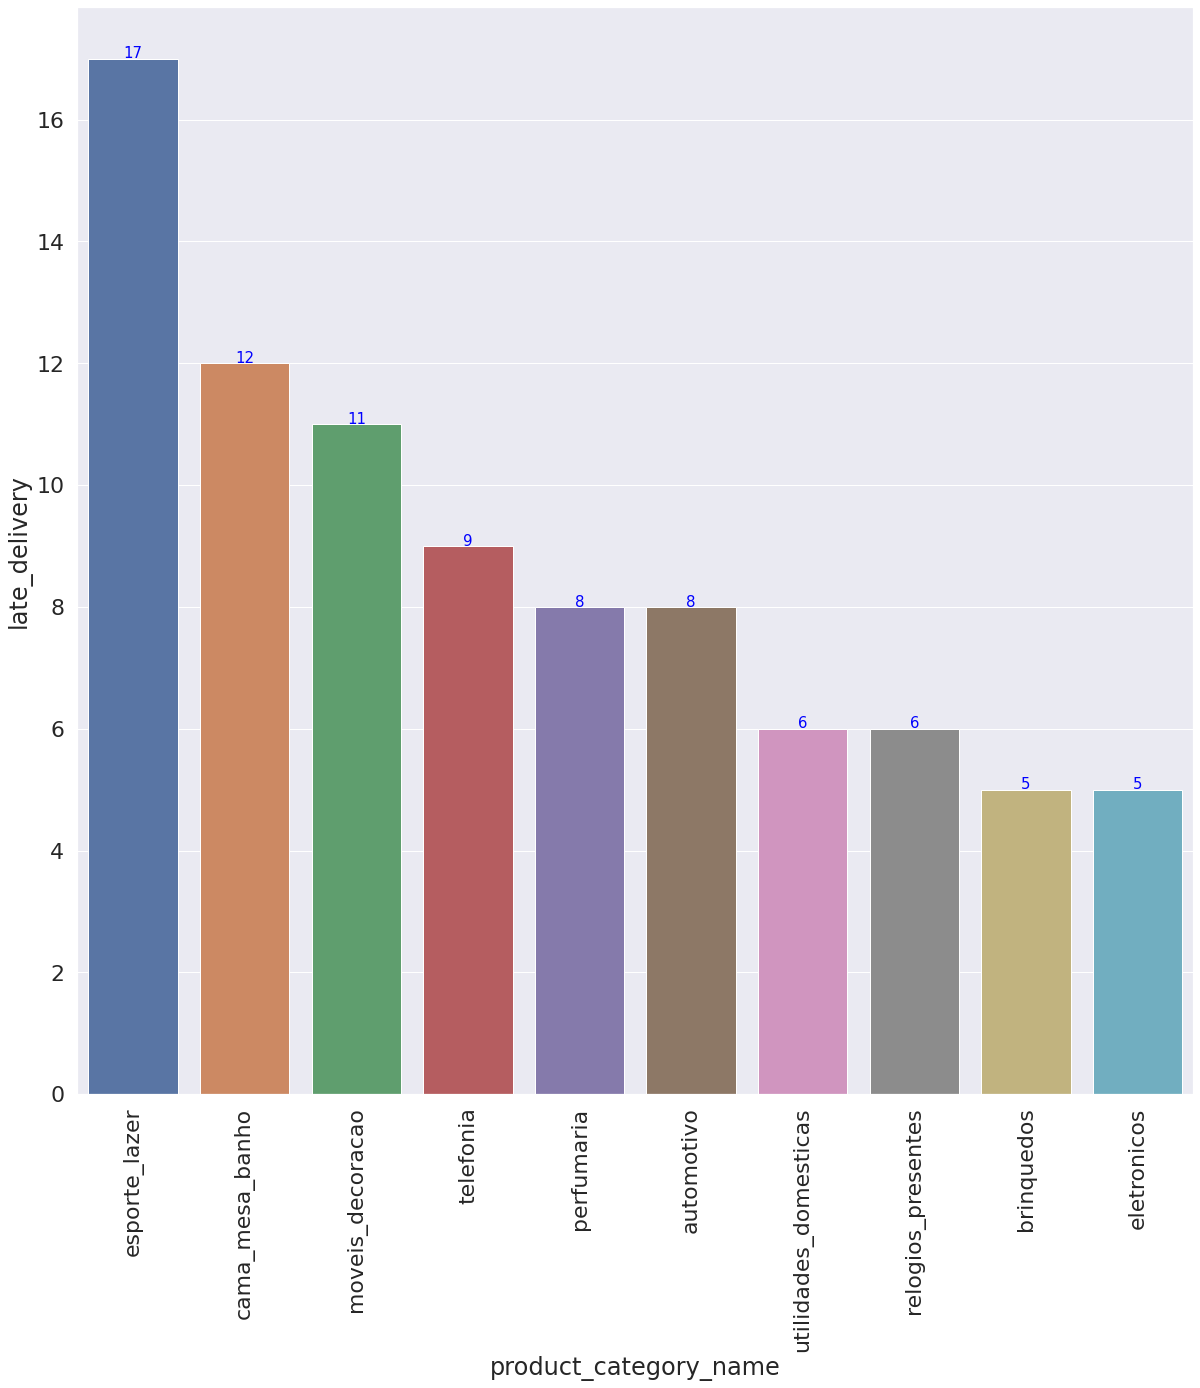

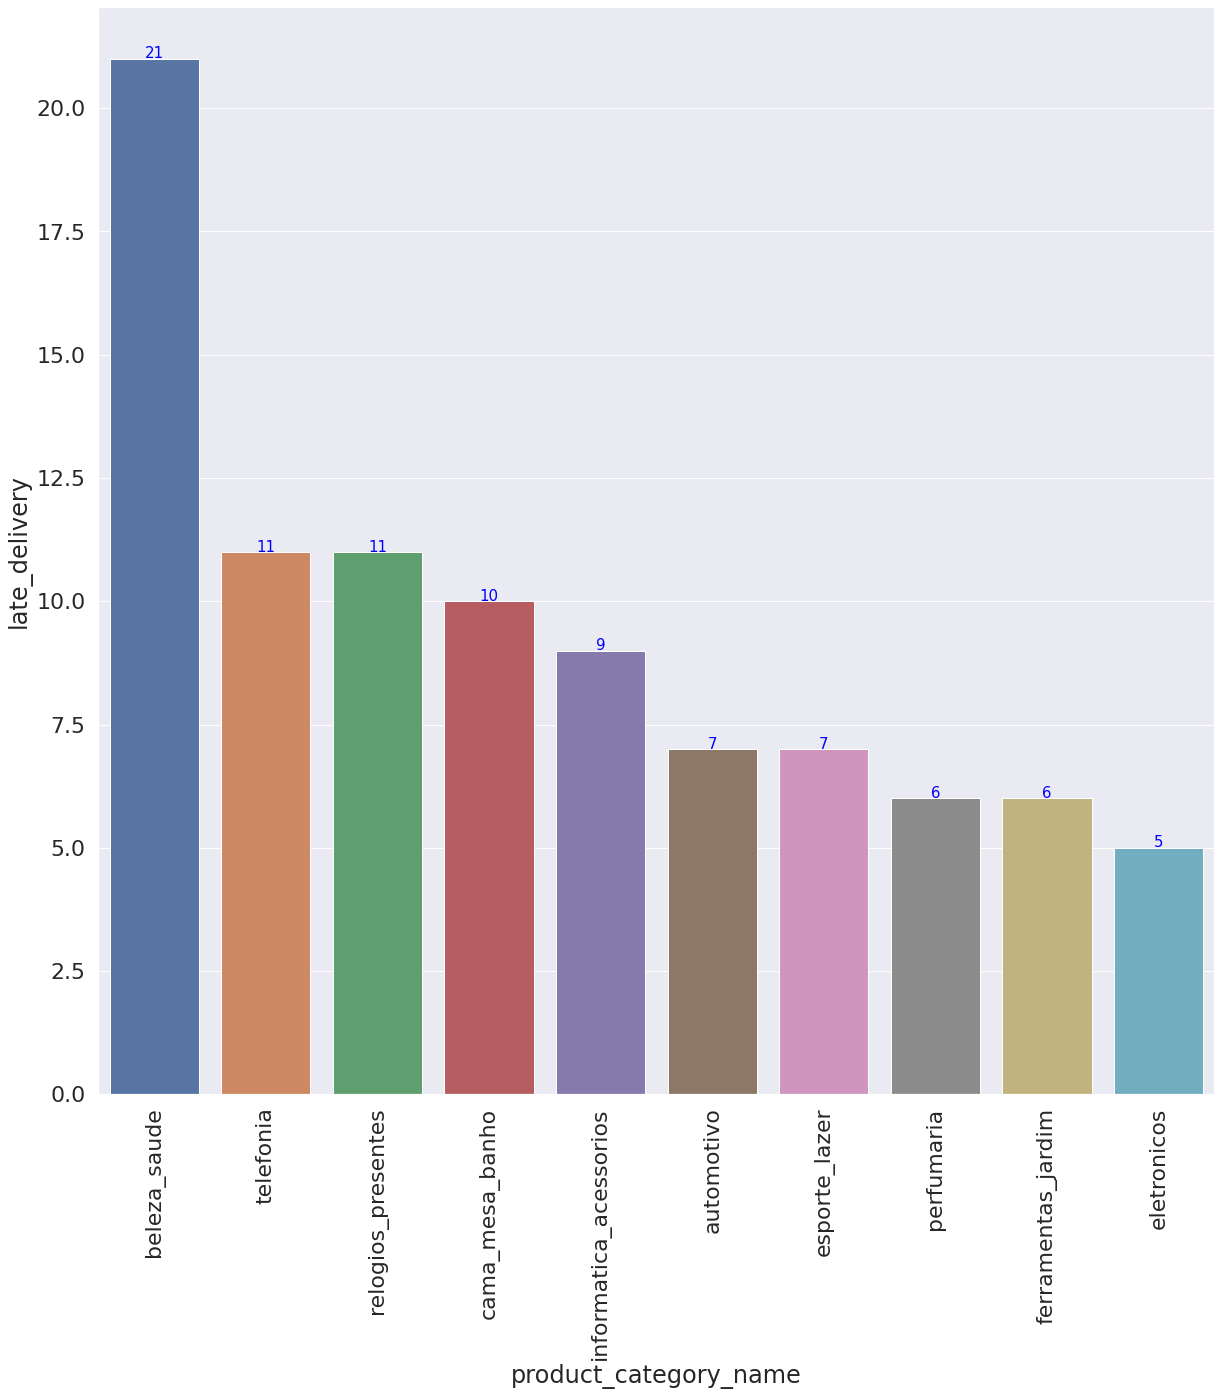

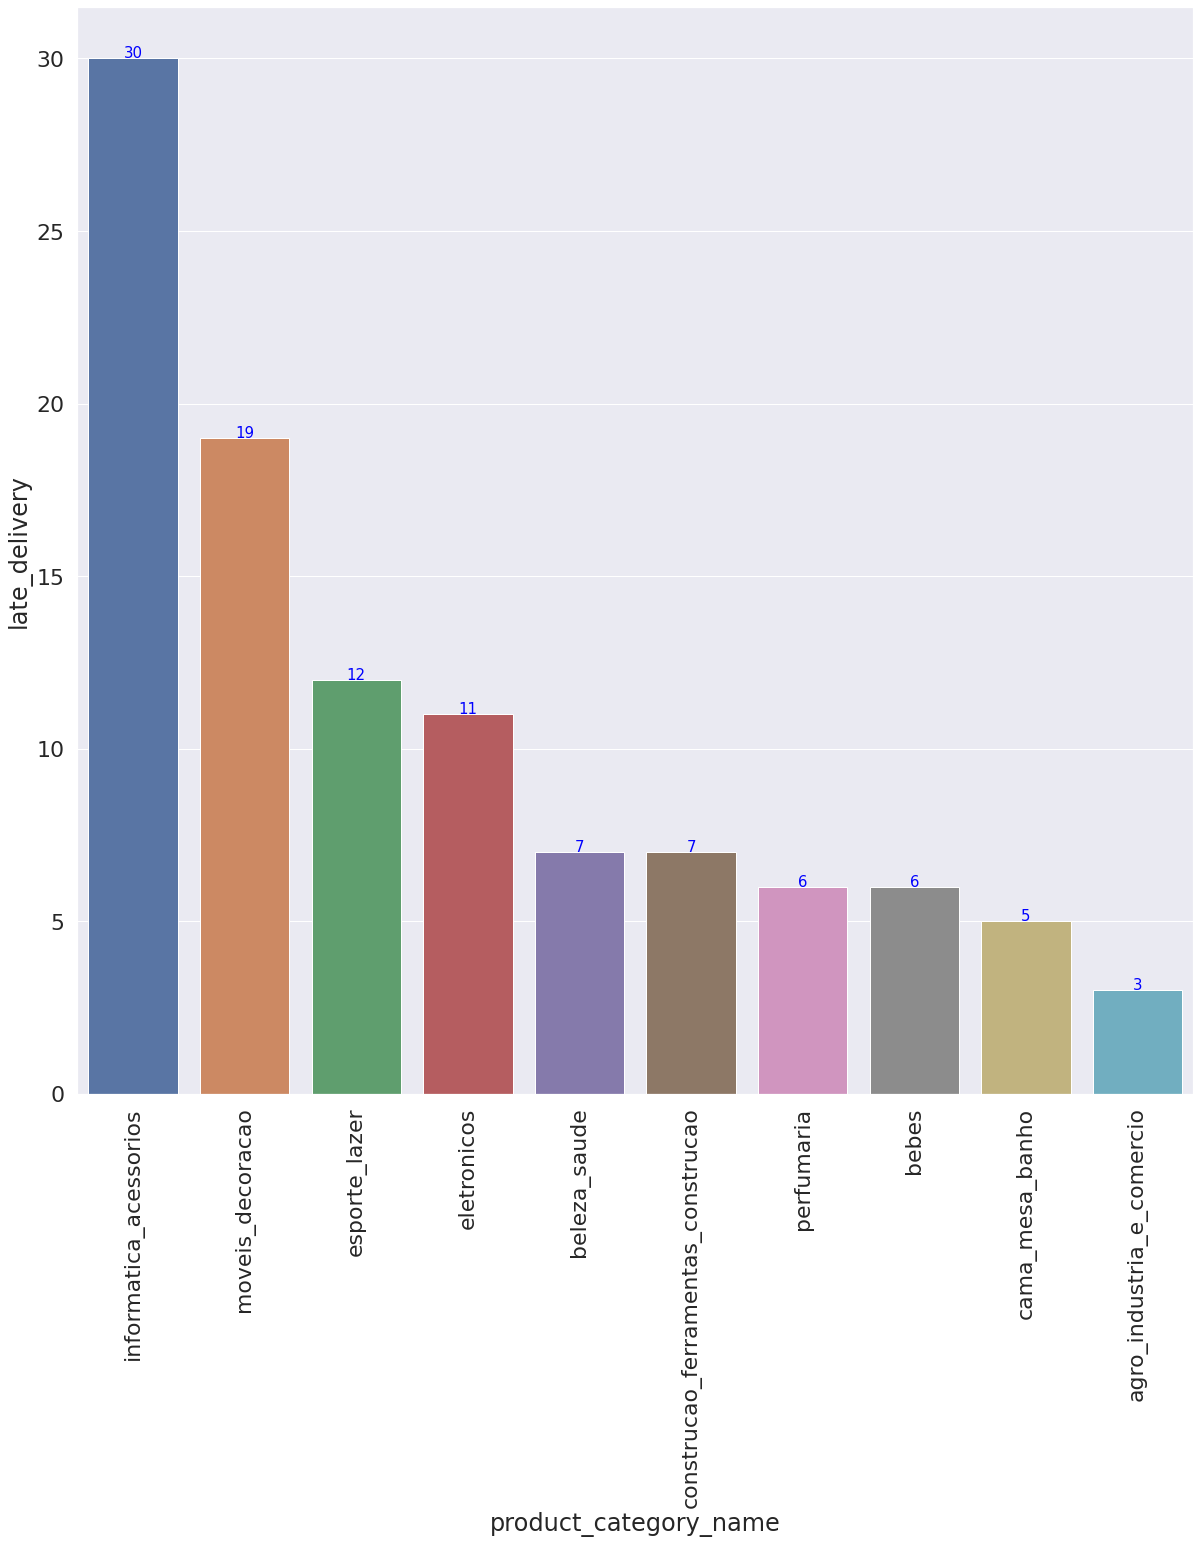

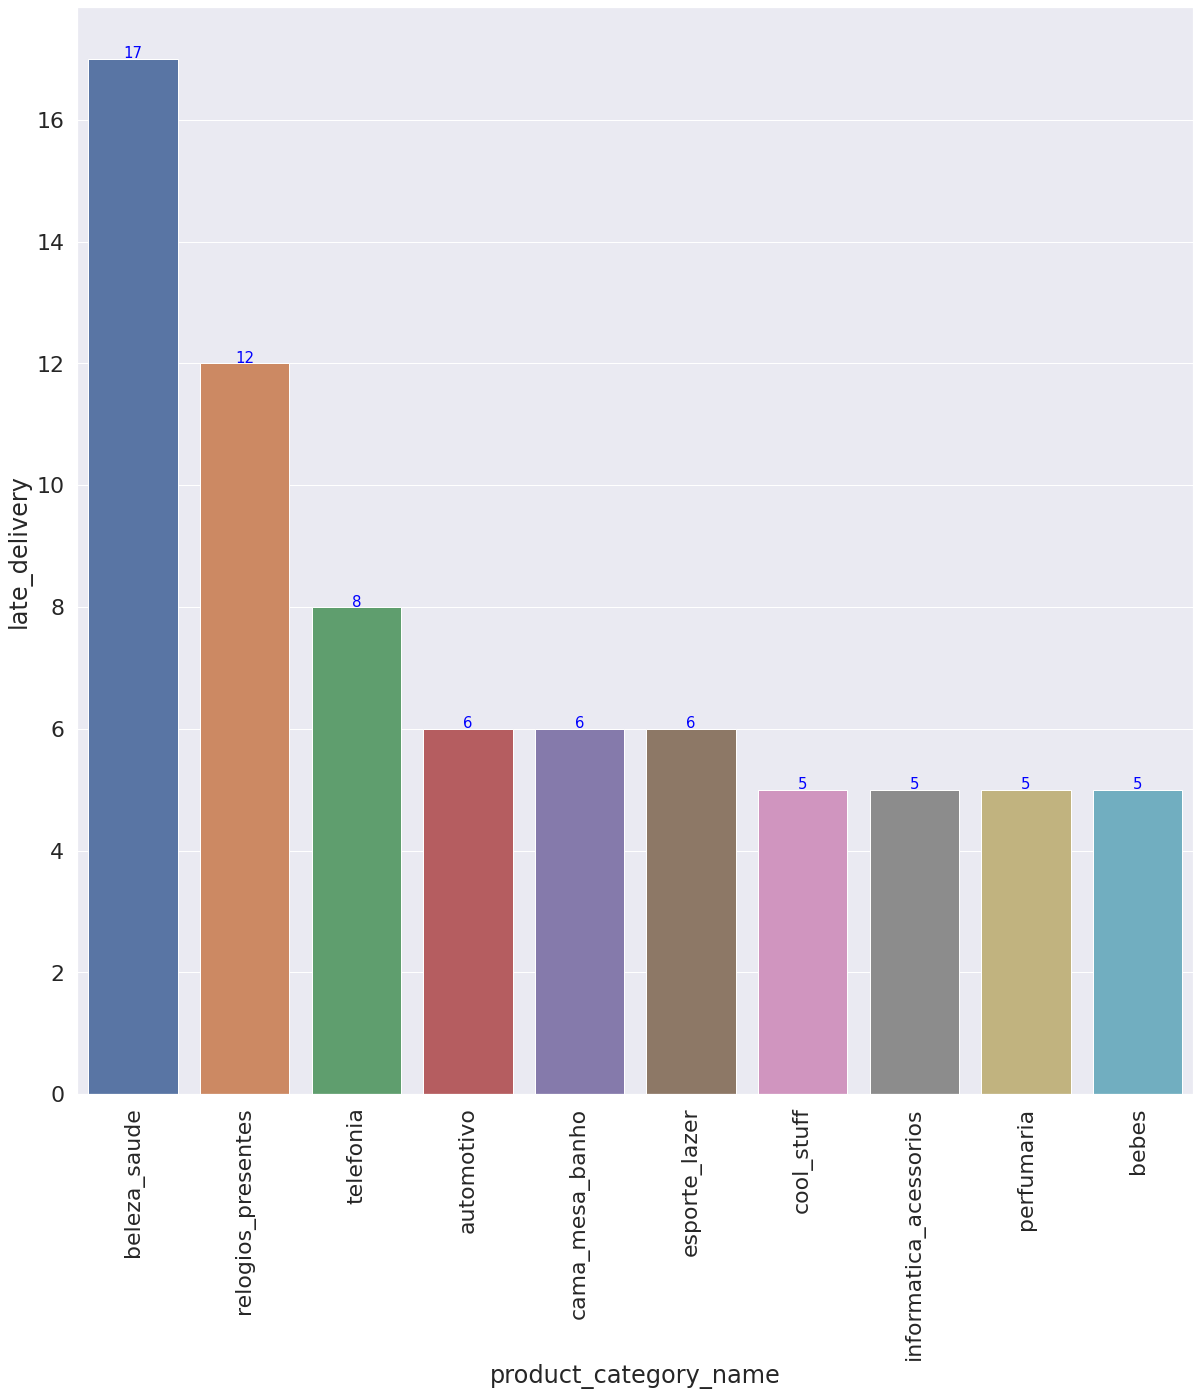

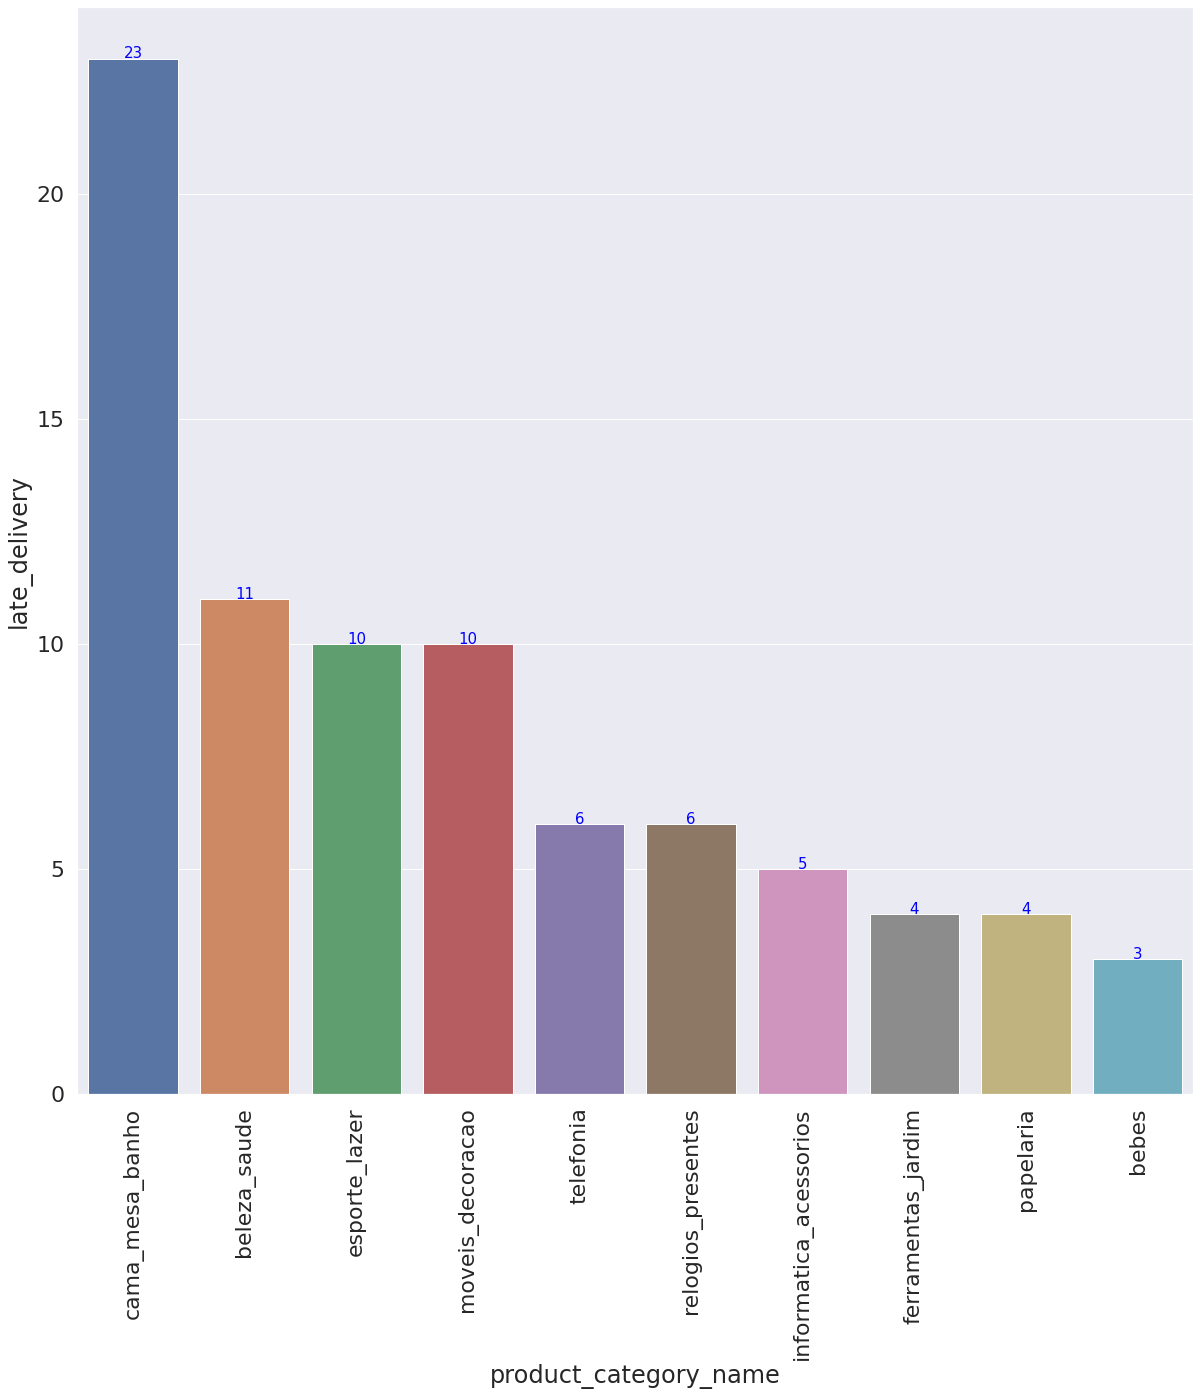

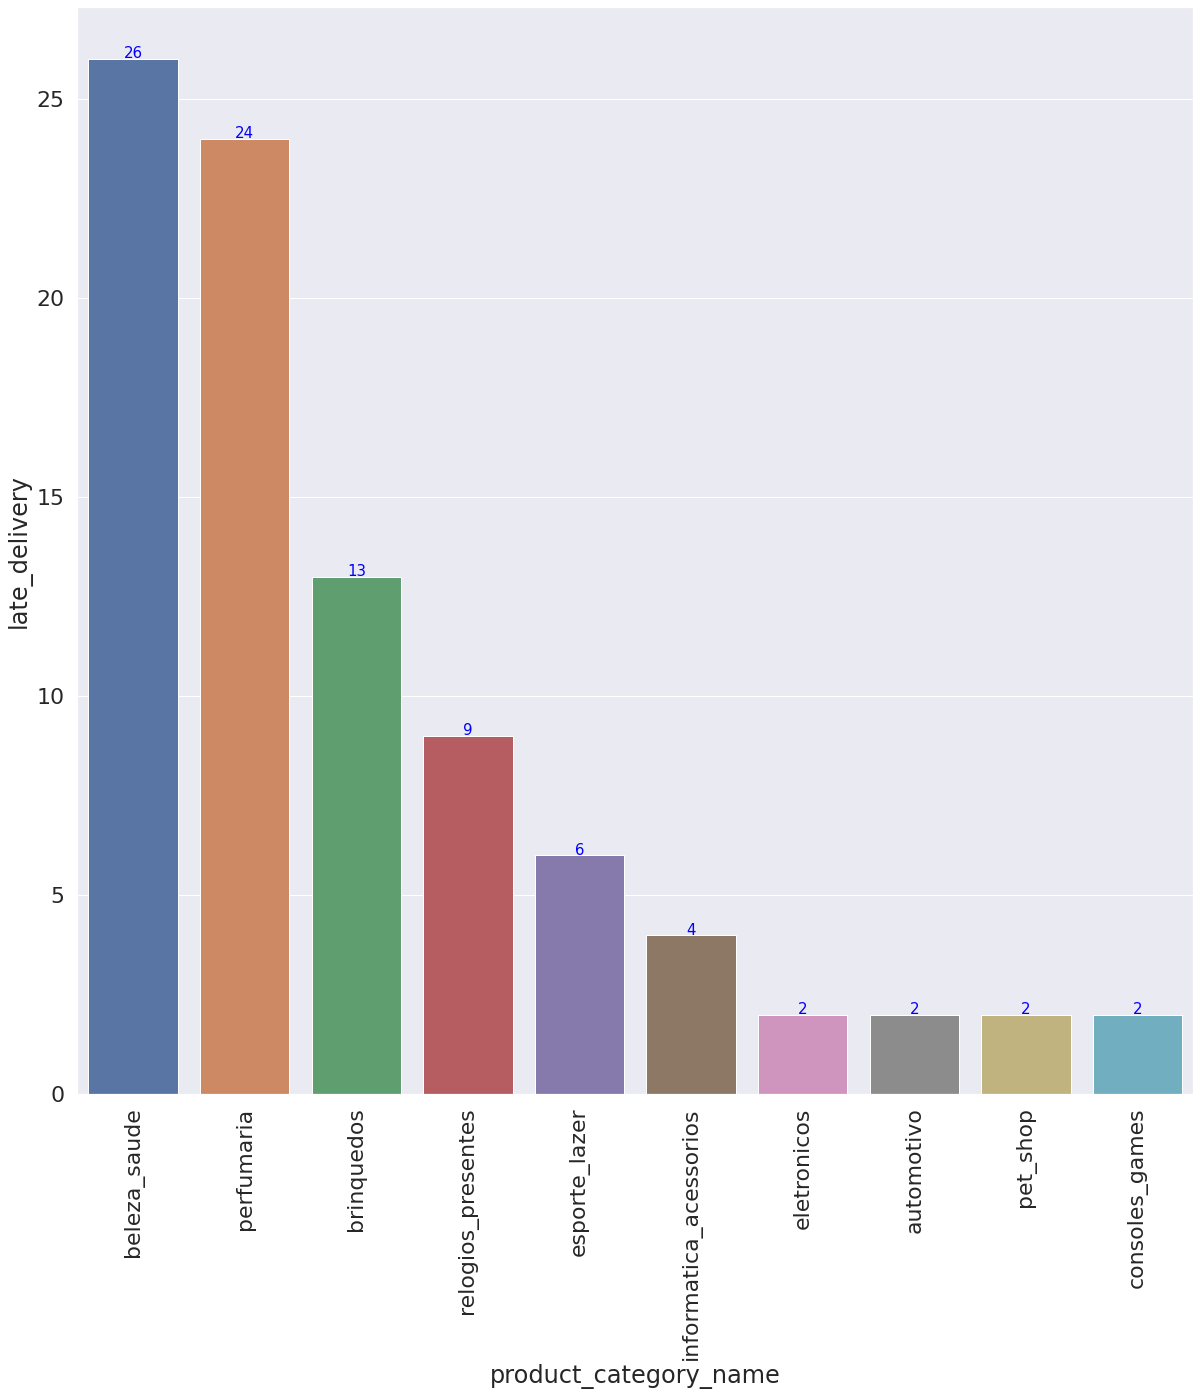

In [317]:
a=data['customer_seller'].unique()
for i in a:
    plt.figure(figsize=(20,20))
    data2=data[data['customer_seller']==i]
    chart=sns.barplot(data=data2,x='product_category_name',y='late_delivery')
    plt.xticks(rotation=90)
    
    for p in chart.patches:
        chart.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', fontsize=15, color='blue', xytext=(0, 5),
            textcoords='offset points')
    plt.show()

# 3. Create variables recency, frequency and amount 

TIPS : Use only recent data to create your segmentation dataset (be careful not to cut off a trend, a sliding year of history is often a good choice).

We use df3 to create the RFM metrics.

## Recency

In [318]:
date_columns = ['order_purchase_timestamp','order_delivered_customer_date']

for col in date_columns:
    df3[col] = pd.to_datetime(df3[col])
df3.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_carrier_date             object
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date            object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
payment_installments                      int64
review_score                              int64
review_score_mean                       float64
installments_mean                       float64
dtype: object

In [319]:
df3[date_columns].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



order_purchase_timestamp order_delivered_customer_date
count                    104485                        101331
unique                    98874                         95663
top         2017-04-20 12:45:34           2017-06-22 16:04:46
freq                         29                            26
first       2016-09-04 21:15:19           2016-10-11 13:46:32
last        2018-10-17 17:30:18           2018-10-17 13:22:46


Looking at order purchase time, our analysis takes place between september 2016 and november 2018, which is 2 years.

In [320]:
df3['order_status'].value_counts()

delivered      101333
shipped          1177
canceled          668
unavailable       651
invoiced          329
processing        320
created             5
approved            2
Name: order_status, dtype: int64

For this analisys we consider 'order purchase date' for Recency column, from which we will remove orders that were cancelled or delivered due to unavailability of the products.


In [321]:
df3.head()

order_id  ... installments_mean
0  e481f51cbdc54678b7cc49136f2d6af7  ...               1.0
1  e481f51cbdc54678b7cc49136f2d6af7  ...               1.0
2  e481f51cbdc54678b7cc49136f2d6af7  ...               1.0
3  53cdb2fc8bc7dce0b6741e2150273451  ...               1.0
4  47770eb9100c2d0c44946d9cf07ec65d  ...               3.0

[5 rows x 16 columns]

Let's remove 'cancelled' and 'unavailable' for our RFM analysis.

In [322]:
df_rfm = df3.query('order_status != "canceled" & order_status != "unavailable"')

In [323]:
df_rfm.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  19
order_delivered_carrier_date      658
order_delivered_customer_date    1841
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
payment_installments                0
review_score                        0
review_score_mean                   0
installments_mean                   0
dtype: int64

No missing values for the order_purchase_timestamp. We have missing values on the order_delivered_customer_date which makes sense.

In [324]:
df_rfm.dropna(inplace=True) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Frequency

For the frequency we look at the number of orders made per unique customer ID, which we did earlier.

We will use the length of the products_id column.

1. Frequency of purchases per customer.

In [325]:
pd.DataFrame(df_rfm.groupby(['customer_id'])['order_id'].count().sort_values(ascending = False))

order_id
customer_id                               
92cd3ec6e2d643d4ebd0e3d6238f69e2        26
2ba91e12e5e4c9f56b82b86d9031d329        24
b246eeed30b362c09d867b9e598bee51        22
270c23a11d024a44c896d1894b261a83        21
13aa59158da63ba0e93ec6ac2c07aacb        19
...                                    ...
a8e9a8abb0f2e70472f4484550eedb73         1
a8e9b749e8a0c101c051957d5e714eaa         1
a8eaaed41944c9f4102f0787aeae30ee         1
a8eb0998c3d6af8fef2e6c696d07a821         1
00012a2ce6f8dcda20d059ce98491703         1

[96454 rows x 1 columns]

2. Time series analysis of orders.
Let's separate date and time from the necessary columns.

In [326]:
import datetime as dt

df_rfm['order_purchase_timestamp'] = pd.to_datetime(df_rfm['order_purchase_timestamp'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [327]:
df_rfm['year_of_purchase'] = pd.DatetimeIndex(df_rfm['order_purchase_timestamp']).year
df_rfm['month_of_purchase'] = pd.DatetimeIndex(df_rfm['order_purchase_timestamp']).month
df_rfm['date_of_purchase'] = pd.DatetimeIndex(df_rfm['order_purchase_timestamp']).day
df_rfm['time_of_purchase'] = pd.DatetimeIndex(df_rfm['order_purchase_timestamp']).hour

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [328]:
monthly_orders = pd.DataFrame(df_rfm.groupby(['month_of_purchase'])['month_of_purchase'].count())

In [329]:
monthly_orders = monthly_orders.rename(index={1: 'January', 2: 'February', 3: 'March', 4: 'April', 5:'May', 6:'June', 7:'July',8:'August', 9:'September', 10:'October', 11:'November', 12:'December'})

Total number of orders per month on our 2 year timeframe.

In [330]:
monthly_orders

month_of_purchase
month_of_purchase                   
January                         8204
February                        8608
March                          10050
April                           9521
May                            10835
June                            9712
July                           10578
August                         10972
September                       4399
October                         5011
November                        7660
December                        5760

In [331]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Scatter(x=monthly_orders.index,
                                y=monthly_orders['month_of_purchase'],
                                mode='lines+markers')) # hover text goes here
fig.update_layout(title='Months With Most Orders cumulated from 2016 to 2018',xaxis_title="Month",yaxis_title="Number of Orders")
fig.update_yaxes(type="log")
fig.show()

In this time series, we can see a trend: customers are less active from August to December, with a scratch from August to September. 

In [332]:
time_purchase= df_rfm.groupby(['time_of_purchase']).agg({'time_of_purchase':'count'}).rename(columns={'time_of_purchase':'Count'})

In [333]:
fig = go.Figure(data=go.Scatter(x=time_purchase.index,
                                y=time_purchase['Count'],
                                mode='markers',
                                marker=dict(
                                size=time_purchase['Count']*0.008))) 
fig.update_layout(title='Purchase Times',xaxis_title="Hour",yaxis_title="Number of Orders")
fig.show()

Customers are more active between 10am and 10pm.

## Monetary Value

In [334]:
payment = ['order_id','payment_sequential','payment_type','payment_installments','payment_value']

In [335]:
df_rfm['payment_value'] = order_payments['payment_value']
df_rfm.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



order_id  ... payment_value
0  e481f51cbdc54678b7cc49136f2d6af7  ...         99.33
1  e481f51cbdc54678b7cc49136f2d6af7  ...         24.39
2  e481f51cbdc54678b7cc49136f2d6af7  ...         65.71
3  53cdb2fc8bc7dce0b6741e2150273451  ...        107.78
4  47770eb9100c2d0c44946d9cf07ec65d  ...        128.45

[5 rows x 21 columns]

#### Check distribution for the payment value

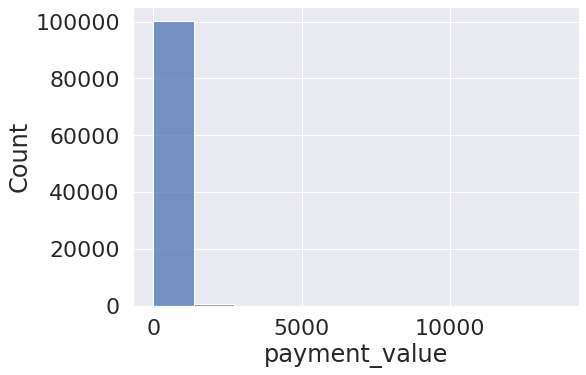

In [336]:
sns.histplot(df_rfm['payment_value'],bins=10)

In [337]:
df_rfm['payment_value'].describe()

count    100730.000000
mean        154.271522
std         217.054785
min           0.000000
25%          56.850000
50%         100.000000
75%         172.100000
max       13664.080000
Name: payment_value, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



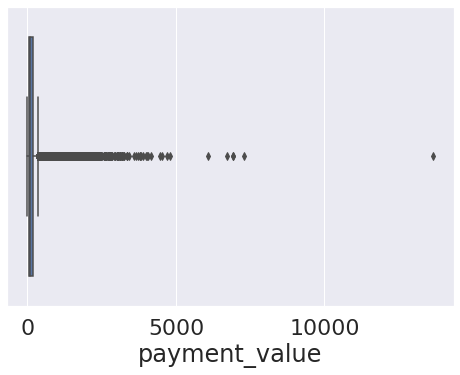

In [338]:
#check outliers
sns.boxplot(df_rfm['payment_value'])

The outliers orders can represent a significant group of clients, so we keep this registers for the analysis

In [339]:
df_credit_card = order_payments[order_payments['payment_type'] == 'credit_card']
df_boleto = order_payments[order_payments['payment_type'] == 'boleto']
df_voucher = order_payments[order_payments['payment_type'] == 'voucher']
df_debit_card = order_payments[order_payments['payment_type'] == 'debit_card']

In [340]:
print('Distribution of payment methods: \n')
print(order_payments['payment_type'].value_counts())

Distribution of payment methods: 

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64


In [341]:
df_type = pd.DataFrame(data=order_payments['payment_type'].value_counts())
df_type['Proportion of payment type'] = order_payments['payment_type'].value_counts()/order_payments['payment_type'].value_counts().sum()*100
df_type

payment_type  Proportion of payment type
credit_card         76795                   73.922376
boleto              19784                   19.043952
voucher              5775                    5.558978
debit_card           1529                    1.471806
not_defined             3                    0.002888

73% of products are purchased with a credit card. 19% are purchased with a bill and the rest are purchased with vounchers or debit cards.

## Create RFM metric

In [342]:
from datetime import date,timedelta
#create RFM Data set
last_date = df_rfm['order_purchase_timestamp'].max() + timedelta(days=1)
#order_payment = order_payment.reset_index()
rfm = df_rfm.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (last_date - x.max()).days,
    'order_id': lambda x: len(x),
    'payment_value': 'sum'
})
rfm.reset_index(inplace=True)

In [343]:
rfm.dropna(inplace=True)

In [344]:
rfm.columns = ['customer_unique_id','Recency','Frequency','MonetaryValue']

In [345]:
rfm.head()

customer_unique_id  Recency  Frequency  MonetaryValue
0  0000366f3b9a7992bf8c76cfdf3221e2      112          1         189.72
1  0000b849f77a49e4a4ce2b2a4ca5be3f      115          1         116.28
2  0000f46a3911fa3c0805444483337064      537          1          15.15
3  0000f6ccb0745a6a4b88665a16c9f078      321          1          55.62
4  0004aac84e0df4da2b147fca70cf8255      288          1         173.53

# 4 Choose the variables of interest in your dataset and create your segmentation dataset

TIPS : Don't use all your variables for your segmentation, use only the varaibles that you think are the most relevant to your marketing team.

Now we chose the variables that we think will be valuable to the marketing teams :
- RFM metrics : Recency, Frequency and Monetary Values associated with unique customers
- Mean review scores per unique customers
- Mean number of installments per unique customers

We create a dataframe with our final features

In [377]:
df3['review_score_mean'] = df3.groupby(by='customer_unique_id')['review_score'].transform('mean')
df3['installments_mean'] = df3.groupby(by='customer_unique_id')['payment_installments'].transform('mean')

In [378]:
x1 = df3[['customer_unique_id','review_score_mean','installments_mean']]
x2 = rfm[['customer_unique_id','Recency','Frequency','MonetaryValue']]
x3 = x1.merge(x2, on='customer_unique_id',how='inner')

In [379]:
X = x3[['installments_mean','review_score_mean','Recency','Frequency','MonetaryValue']]
X

installments_mean  review_score_mean  Recency  Frequency  MonetaryValue
0                     1.0               4.25      332          4         335.80
1                     1.0               4.25      332          4         335.80
2                     1.0               4.25      332          4         335.80
3                     1.0               4.25      332          4         335.80
4                     1.0               4.00       36          1         107.78
...                   ...                ...      ...        ...            ...
101540                3.0               5.00      539          1           0.00
101541                3.0               4.00      205          1           0.00
101542                5.0               5.00      368          1           0.00
101543                4.0               2.00      233          1           0.00
101544                1.0               5.00      174          1           0.00

[101545 rows x 5 columns]

In [380]:
X.describe()

installments_mean  review_score_mean  ...      Frequency  MonetaryValue
count      101545.000000      101545.000000  ...  101545.000000  101545.000000
mean            2.855847           4.136521  ...       1.299020     200.193323
std             2.647616           1.286636  ...       1.413623     342.414264
min             0.000000           1.000000  ...       1.000000       0.000000
25%             1.000000           4.000000  ...       1.000000      61.800000
50%             1.666667           5.000000  ...       1.000000     114.140000
75%             4.000000           5.000000  ...       1.000000     207.660000
max            24.000000           5.000000  ...      33.000000   13664.080000

[8 rows x 5 columns]

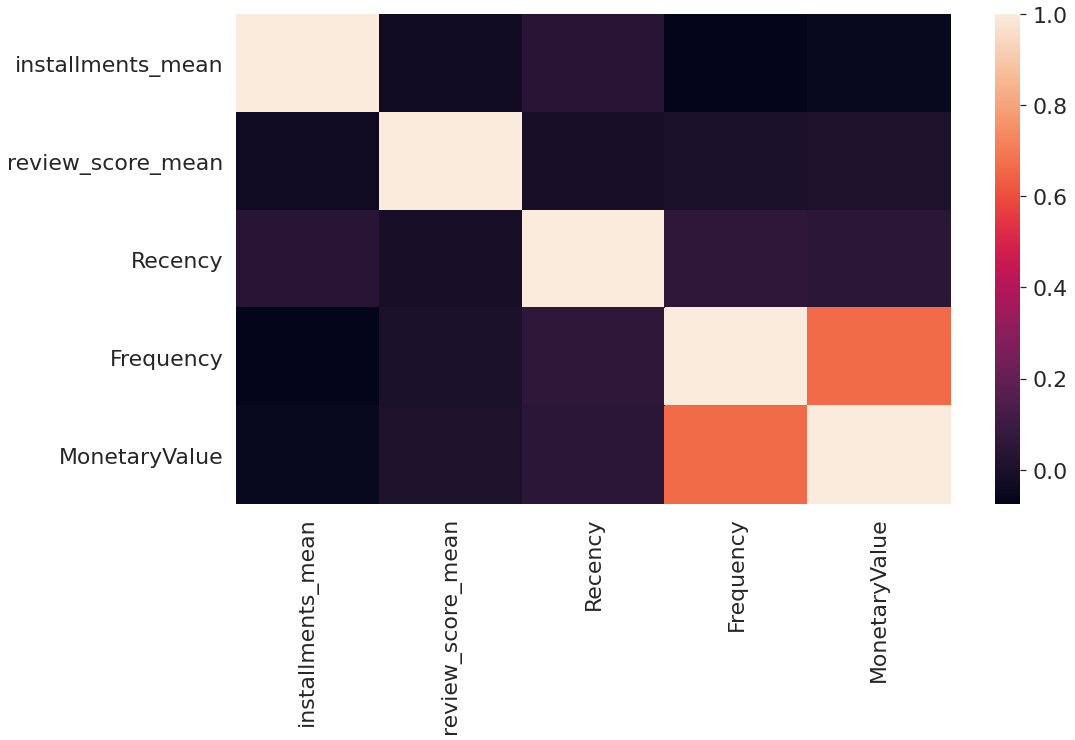

In [351]:
plt.figure(figsize=(16,9))
sns.heatmap(X.corr())

We notice that Monetary Value is positively correlated with Frequency but not so significantly. Thus, we can keep all these features without a risk of multicollinearity.

In [352]:
X.shape

(101545, 5)

In [353]:
X.isna().sum()

installments_mean    0
review_score_mean    0
Recency              0
Frequency            0
MonetaryValue        0
dtype: int64

No NAs!

In [381]:
X_df=pd.DataFrame(X)
X_df.describe()

installments_mean  review_score_mean  ...      Frequency  MonetaryValue
count      101545.000000      101545.000000  ...  101545.000000  101545.000000
mean            2.855847           4.136521  ...       1.299020     200.193323
std             2.647616           1.286636  ...       1.413623     342.414264
min             0.000000           1.000000  ...       1.000000       0.000000
25%             1.000000           4.000000  ...       1.000000      61.800000
50%             1.666667           5.000000  ...       1.000000     114.140000
75%             4.000000           5.000000  ...       1.000000     207.660000
max            24.000000           5.000000  ...      33.000000   13664.080000

[8 rows x 5 columns]

# 5 Test Two different segmentation algorithms

TIPS : Make maximum use of the code seen in the last TPs. You can also use [others algorithms](https://scikit-learn.org/stable/modules/clustering.html) that sklearn offers. 

Scale the data

In [382]:
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

## 1) Hierarchical Clustering

In [357]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [358]:
# Instantiate model with distance_threshold = 0 and n_clusters = None
# model1 = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
# Train the model on the X_scaled using fit
# model1.fit(X_scaled)

The model is too heavy and make our session crash. We have tried many things, such as subsampling our features X or changing laptops but it didn't help.

Below is what we would have done for the hierarchical clustering. We would have looked at the dendrogram to figure out the number of clusters for our final clustering model.

In [359]:
#def plot_dendrogram(model1, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    #counts = np.zeros(model.children_.shape[0])
    #n_samples = len(model.labels_)
    #for i, merge in enumerate(model.children_):
        #current_count = 0
        #for child_idx in merge:
           #if child_idx < n_samples:
                #current_count += 1  # leaf node
            #else:
              #  current_count += counts[child_idx - n_samples]
        #counts[i] = current_count

   # linkage_matrix = np.column_stack([model.children_, model.distances_,
    #                                  counts]).astype(float)

    # Plot the corresponding dendrogram
    # dendrogram(linkage_matrix, **kwargs)

## 2) K-mean

In [360]:
kmeans_kwargs={'init':'random','n_init':10,'max_iter':300,'random_state':42}
sse=[]
for k in range(1,11):
    kmeans=KMeans(n_clusters=k,**kmeans_kwargs)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

#### Choose the optimal number of clusters

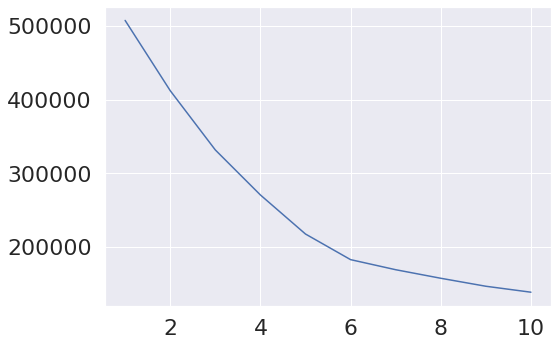

In [361]:
plt.plot(range(1,11),sse)

The sum of squared errors decreases with increasing number of clusters. Yet we are not sure what number of clusters is optimal. This is why we use Knee Locator.

In [362]:
kl=KneeLocator(range(1,11),sse,curve='convex',direction="decreasing")
kl.elbow

5

The optimal number of clusters for the K-mean model is 5.

#### Visualize your data using PCa and coloring the data according to their class

In [363]:
preprocessor=Pipeline([('scaler',StandardScaler()),('pca',PCA(n_components=2,random_state=42))])

In [364]:
clusterer=Pipeline([('kmeans',KMeans(n_clusters=5,init="k-means++",n_init=50,max_iter=500,random_state=42))])

In [143]:
pipe=Pipeline([("preprocessor",preprocessor),("clusterer",clusterer)])

In [369]:
pipe.fit(X_df)

Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('scaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True)),
                                 ('pca',
                                  PCA(copy=True, iterated_power='auto',
                                      n_components=2, random_state=42,
                                      svd_solver='auto', tol=0.0,
                                      whiten=False))],
                          verbose=False)),
                ('clusterer',
                 Pipeline(memory=None,
                          steps=[('kmeans',
                                  KMeans(algorithm='auto', copy_x=True,
                                         init='k-means++', max_iter=500,
                                         n_clusters=5, n_init=50, n_jobs=None,
                                   

In [372]:
pcadf=pd.DataFrame(pipe['preprocessor'].transform(X_df),columns=['PC1','PC2'])
pcadf['cluster']=pipe["clusterer"]["kmeans"].labels_

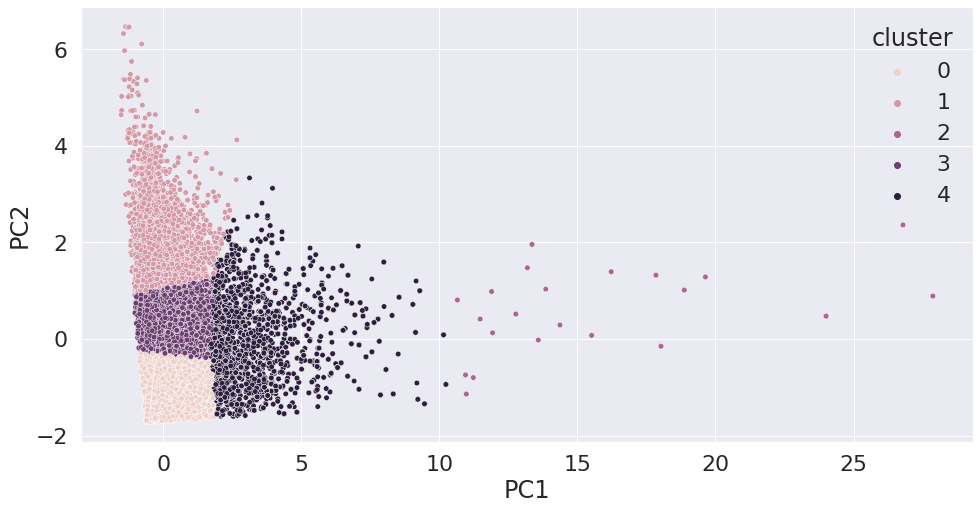

In [373]:
plt.figure(figsize=(16,8))
scat=sns.scatterplot(x='PC1',y='PC2',s=30,data=pcadf,hue='cluster')
plt.show()

## 3) DBSCAN

DBSCAN does not require the number of clusters as a parameter, rather it infers the number of clusters based on the data.

In [149]:
from sklearn.cluster import DBSCAN

In [150]:
model_db = DBSCAN(eps=0.3)

In [151]:
db = model_db.fit_predict(X_scaled)
db

array([0, 0, 0, ..., 2, 7, 2])

In [152]:
db_model = DBSCAN(eps=0.3).fit(X_scaled)
labels = db_model.labels_

With an epsilon of 0.3 the number of clusters is very large. After playing with it, we notice that increasing the epsilon helps reducing the number of clusters. However it remains to high and with an epsilon over 0.9 the notebook crashes.

In [153]:
no_clusters = len(np.unique(labels) )
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 449
Estimated no. of noise points: 4621


# 6 Analyse your customer clusters and find different behaviors

TIPS : You can use additional variables for determining the behavior of your segments than those used for segmentation.

In [383]:
X_df.head()

installments_mean  review_score_mean  Recency  Frequency  MonetaryValue
0                1.0               4.25      332          4         335.80
1                1.0               4.25      332          4         335.80
2                1.0               4.25      332          4         335.80
3                1.0               4.25      332          4         335.80
4                1.0               4.00       36          1         107.78

In [384]:
combinedkmeans=pd.concat([X_df,pcadf],axis=1)
combinedkmeans

installments_mean  review_score_mean  ...       PC2  cluster
0                     1.0               4.25  ... -0.089555        4
1                     1.0               4.25  ... -0.089555        4
2                     1.0               4.25  ... -0.089555        4
3                     1.0               4.25  ... -0.089555        4
4                     1.0               4.00  ... -1.215705        0
...                   ...                ...  ...       ...      ...
101540                3.0               5.00  ...  0.887476        3
101541                3.0               4.00  ... -0.066554        3
101542                5.0               5.00  ...  0.707375        3
101543                4.0               2.00  ...  1.008179        1
101544                1.0               5.00  ... -1.039966        0

[101545 rows x 8 columns]

In [387]:
combinedkmeansclusterresults=combinedkmeans.groupby('cluster').agg({
'Frequency':'mean','Recency':'mean','MonetaryValue':'mean','review_score_mean':'mean','installments_mean':'mean'})
combinedkmeansclusterresults.reset_index(inplace=True)
combinedkmeansclusterresults

cluster  Frequency  ...  review_score_mean  installments_mean
0        0   1.128976  ...           4.713084           1.549552
1        1   1.102492  ...           3.144376           6.649530
2        2  20.245675  ...           4.179931           1.072664
3        3   1.146805  ...           3.914774           2.869082
4        4   4.407174  ...           4.156958           1.848780

[5 rows x 6 columns]

**Cluster 0** has buyers whose rfm metrics are low and who buy in once. Yet their mean review scores are very high so they seem satisfied with Olist products. The marketing team could offer loyalty programs to these customers to make them buy more of their products.

**Cluster 1** has the highest number of installments, which means that these buyers like to pay in several times. The buyers from this cluster 1 have not ordered on Olist in a long time and they do not buy frequently. The marketing team could deploy a strategy in relation with installment options to attract these customers and meet their budgeting constraints.

**Cluster 2** has the highest mean frequency : the customers in cluster 2 have made 20 orders on average on the observed lifetime (2 years). They also spend more on Olist products (almost 4000 reals on average). With high frequency and high monetary value these customers have a lot of potential. Yet their recency is also the highest (380 days, which is more than a year) meaning that they churn more than customers in other clusters. Their review scores are high so they like Olist products. They usually pay in once. This cluster is very promising but Olist need to retain them. The marketing team need to find out why these customers who like the products and buy a lot end churning and design a strategy according to findings (implement targeted marketing strategies).

**Cluster 3** Cluster 3 has customers that don't buy frequently. They buy cheap items in roughly 3 installments on average. Their mean score is lower than the other clusters. The marketing strategy to retain customer might be to send customers newsletter more often to communicate on the cheapest products available.

**Cluster 4** Cluster 4 has customers that buy more frequently quite expensive items. They are the 2nd best cluster after the cluster 2. Their mean review score are high and they buy in roughly twice installments. The best way to make them purchase more products is to enhance their loyalty by implementing a loyalty card.

**Conclusion :** The cluster 2 seems interesting. The marketing team may have strategies to implement to target this cluster.


Let's look at the full statistics for each cluster (min, max, mean, quantiles)

In [388]:
cluster_0 = combinedkmeans[combinedkmeans.cluster == 0]
cluster_0.describe()

installments_mean  review_score_mean  ...           PC2  cluster
count       41845.000000       41845.000000  ...  41845.000000  41845.0
mean            1.549552           4.713084  ...     -0.925105      0.0
std             0.992883           0.563061  ...      0.377492      0.0
min             0.000000           2.000000  ...     -1.718315      0.0
25%             1.000000           5.000000  ...     -1.220881      0.0
50%             1.000000           5.000000  ...     -0.889871      0.0
75%             2.000000           5.000000  ...     -0.610112      0.0
max             6.000000           5.000000  ...     -0.293839      0.0

[8 rows x 8 columns]

In [389]:
cluster_1 = combinedkmeans[combinedkmeans.cluster == 1]

In [390]:
cluster_1.describe()

installments_mean  review_score_mean  ...           PC2  cluster
count        15328.00000       15328.000000  ...  15328.000000  15328.0
mean             6.64953           3.144376  ...      1.761031      1.0
std              3.22628           1.647951  ...      0.631961      0.0
min              1.00000           1.000000  ...      0.939498      1.0
25%              4.00000           1.000000  ...      1.273081      1.0
50%              7.00000           3.000000  ...      1.600292      1.0
75%             10.00000           5.000000  ...      2.094845      1.0
max             24.00000           5.000000  ...      6.469495      1.0

[8 rows x 8 columns]

In [391]:
cluster_2 = combinedkmeans[combinedkmeans.cluster == 2]

In [392]:
cluster_2.describe()

installments_mean  review_score_mean  ...         PC2  cluster
count         289.000000         289.000000  ...  289.000000    289.0
mean            1.072664           4.179931  ...    0.594548      2.0
std             0.568015           1.408766  ...    0.831336      0.0
min             1.000000           1.000000  ...   -1.138951      2.0
25%             1.000000           4.000000  ...    0.075723      2.0
50%             1.000000           5.000000  ...    0.809987      2.0
75%             1.000000           5.000000  ...    1.286468      2.0
max            10.000000           5.000000  ...    2.364673      2.0

[8 rows x 8 columns]

In [393]:
cluster_3 = combinedkmeans[combinedkmeans.cluster == 3]

In [394]:
cluster_3.describe()

installments_mean  review_score_mean  ...           PC2  cluster
count       40598.000000       40598.000000  ...  40598.000000  40598.0
mean            2.869082           3.914774  ...      0.288008      3.0
std             2.238691           1.374133  ...      0.374374      0.0
min             1.000000           1.000000  ...     -0.384235      3.0
25%             1.000000           3.000000  ...     -0.036964      3.0
50%             2.000000           4.000000  ...      0.269838      3.0
75%             4.000000           5.000000  ...      0.583691      3.0
max            11.000000           5.000000  ...      1.266320      3.0

[8 rows x 8 columns]

We can see that 

In [395]:
cluster_4 = combinedkmeans[combinedkmeans.cluster == 4]

In [396]:
cluster_4.describe()

installments_mean  review_score_mean  ...          PC2  cluster
count        3485.000000        3485.000000  ...  3485.000000   3485.0
mean            1.848780           4.156958  ...    -0.042018      4.0
std             1.777032           1.196027  ...     0.832061      0.0
min             1.000000           1.000000  ...    -1.600366      4.0
25%             1.000000           4.000000  ...    -0.697657      4.0
50%             1.000000           5.000000  ...    -0.097698      4.0
75%             2.000000           5.000000  ...     0.542711      4.0
max            10.500000           5.000000  ...     3.337506      4.0

[8 rows x 8 columns]

# Conclusion

The cluster 2 has a great potential but the marketing team needs to find out why these buyers churn even though they seem to like Olist products and buy a lot, through data analytics. They should focus their efforts to retain customers from this cluster through advanced digital marketing strategies.

